In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
import arviz as az
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('pca_data.csv')
df = df[700:]
y = df["Price"].values
df_x = df.drop(columns=["Date", "Price"])
df.head()

,Date,Price,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
700,2020-12-01,19218.8,1.925172,5.451580,-1.142358,0.861027,-0.335091,0.431894,-1.122869,0.912786,-0.619038,-0.434581
701,2020-12-02,19433.3,1.582994,3.559479,-0.653910,1.251390,-0.337836,-1.237844,-0.313913,0.794368,-0.194111,-0.184261
702,2020-12-03,18658.1,1.175193,3.092115,-1.930997,0.743688,-0.094971,-1.303851,-0.833903,1.148260,-0.693432,-0.112931
703,2020-12-04,19146.5,1.046626,2.240449,-0.903165,1.246917,0.051724,-0.401272,-0.090789,0.776876,-0.929971,0.171880
704,2020-12-05,19379.9,0.576253,0.169815,-1.095204,1.964635,0.133399,-1.614727,-0.163228,0.659043,-0.519185,0.786180


In [13]:
X = np.array(df_x)

In [78]:
df.tail()

,Date,Price,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
1020,2021-10-17,62056.3,8.247989,-6.235256,-0.467159,-0.015834,-1.848409,0.520881,-0.291738,0.797574,-0.658913,-0.664539
1021,2021-10-18,64278.5,7.769368,-2.800591,-1.965221,-1.538361,-1.019428,1.423679,1.055461,1.265406,-0.163010,0.122867
1022,2021-10-19,65979.1,9.114730,-1.343815,-1.896115,-1.721794,-3.317679,3.028115,3.559169,3.329187,0.833770,1.369422
1023,2021-10-20,62210.2,8.975927,-2.094760,-1.719892,-1.823947,-3.041510,1.546296,1.514364,0.405193,0.770918,0.181783
1024,2021-10-21,60697.3,9.921635,-1.617694,-0.205104,-1.418701,-0.830756,3.150038,0.674089,1.157297,-0.859862,0.156889


In [14]:
I = np.eye(df_x.shape[1])
α = 5
β = 1 / 10000
num_of_vars = 10
X = X[:,:num_of_vars]
w_mean = np.zeros(num_of_vars)
w_cov = α*I
w_cov

array([[5., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 5., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 5., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 5., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 5., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 5., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 5., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 5.]])

In [159]:
w_mean = az.summary(trace)["mean"]
w_mean

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    494.074
w[1]    -57.609
w[2]    -18.301
w[3]    -26.893
w[4]    -15.743
w[5]      2.141
w[6]     11.003
w[7]     -1.080
w[8]     -4.295
w[9]     -3.688
Name: mean, dtype: float64

In [118]:
with pm.Model() as our_first_model:
    w = pm.MvNormal('w', mu=prior_m_of_w, cov=α*I, shape=(num_of_vars, ))
    mu = pm.math.dot(X, w)
    xTx = pm.math.dot(X.T, X)
    test = xTx*β
    S = (xTx*β + α*I)**-1
    pred_sigma = np.sqrt(1/β + xTx*S)
    likelihood = pm.Normal('likelihood', mu=mu, sigma=1/β, observed=y)
    trace = pm.sample(11000, random_seed=123)

<ipython-input-118-45c6b557d1d0>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 184 seconds.


In [162]:
count = 0
while count < 1000:
    with pm.Model() as our_first_model:
        w = pm.MvNormal('w', mu=w_mean, cov=w_cov, shape=(num_of_vars, ))
        mu = pm.math.dot(X, w)
        likelihood = pm.Normal('likelihood', mu=mu, sigma=1/β, observed=y)
        trace = pm.sample(11000, random_seed=123)
    w_mean= az.summary(trace)["mean"]
    w_T = trace["w"].T
    w_cov = np.cov(w_T)
    print(w_mean)
    print(w_cov)
    count += 1
df = az.summary(trace)
df.to_csv('result2.csv')
axes = az.plot_trace(trace)
fig = axes.ravel()[0].figure
fig.savefig("result2.png")

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 212 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    898.643
w[1]    -85.166
w[2]    -61.140
w[3]    -72.707
w[4]    -74.524
w[5]     -1.330
w[6]     95.976
w[7]    -20.164
w[8]    -13.613
w[9]     61.922
Name: mean, dtype: float64
[[ 3.31411582 -0.12173027 -0.17442279 -0.32243896 -0.57902385 -0.1291837
   0.82032995 -0.16278064 -0.11944143  0.83191378]
 [-0.12173027  2.75640437 -0.43041369  0.81181784 -0.51625793  0.67004036
  -0.89608347  0.21382962 -0.62334957 -0.71301911]
 [-0.17442279 -0.43041369  4.70855746 -0.16006     0.06328913 -1.02415171
   0.65514783  0.42838605  0.47902187  0.53782599]
 [-0.32243896  0.81181784 -0.16006     3.17994868 -0.30511814  0.221281
  -0.34983102  0.27394758 -0.14071098 -0.86295795]
 [-0.57902385 -0.51625793  0.06328913 -0.30511814  4.41776879 -0.00838553
   1.31283638 -0.31774818 -0.33342619  0.38134599]
 [-0.1291837   0.67004036 -1.02415171  0.221281   -0.00838553  2.78840521
  -0.89856651  0.32006064 -0.77191631 -0.11855963]
 [ 0.82032995 -0.89608347  0.65514783 -0.34983102  1.31283638 -0.8

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 185 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    901.536
w[1]    -85.563
w[2]    -61.424
w[3]    -73.186
w[4]    -75.075
w[5]     -1.483
w[6]     96.841
w[7]    -20.333
w[8]    -13.688
w[9]     62.692
Name: mean, dtype: float64
[[ 3.2792343  -0.13075525 -0.14586496 -0.32280449 -0.57820588 -0.14238707
   0.85809573 -0.12907136 -0.12711759  0.85333339]
 [-0.13075525  2.76997456 -0.44863732  0.8241377  -0.55120362  0.67696338
  -0.92862726  0.21978139 -0.64536457 -0.73458192]
 [-0.14586496 -0.44863732  4.63618775 -0.18001464  0.08509469 -1.02557859
   0.73042409  0.40177005  0.48719479  0.61246401]
 [-0.32280449  0.8241377  -0.18001464  3.15733443 -0.33768692  0.22652708
  -0.37688616  0.27669227 -0.13971879 -0.88881549]
 [-0.57820588 -0.55120362  0.08509469 -0.33768692  4.39672184 -0.01140844
   1.25223347 -0.33926624 -0.32553422  0.38640975]
 [-0.14238707  0.67696338 -1.02557859  0.22652708 -0.01140844  2.78459926
  -0.93149925  0.31753843 -0.77501426 -0.14852342]
 [ 0.85809573 -0.92862726  0.73042409 -0.37688616  1.25223347 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 182 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    904.403
w[1]    -85.978
w[2]    -61.670
w[3]    -73.673
w[4]    -75.613
w[5]     -1.655
w[6]     97.747
w[7]    -20.470
w[8]    -13.753
w[9]     63.502
Name: mean, dtype: float64
[[ 3.21219236 -0.1058392  -0.14329005 -0.30734289 -0.56593948 -0.13699467
   0.8495915  -0.09660461 -0.13005522  0.8201071 ]
 [-0.1058392   2.76729719 -0.4561709   0.83240959 -0.56317143  0.67727301
  -0.96063169  0.2164217  -0.65326947 -0.75560632]
 [-0.14329005 -0.4561709   4.67240757 -0.17081015  0.14383347 -1.00714033
   0.7915593   0.41121731  0.4731276   0.60872415]
 [-0.30734289  0.83240959 -0.17081015  3.1153869  -0.3395555   0.22368685
  -0.33497733  0.28337939 -0.13180748 -0.87530228]
 [-0.56593948 -0.56317143  0.14383347 -0.3395555   4.39868834 -0.0374786
   1.24362403 -0.32154301 -0.31676766  0.39603284]
 [-0.13699467  0.67727301 -1.00714033  0.22368685 -0.0374786   2.72158533
  -0.97073566  0.30152764 -0.78303971 -0.17109612]
 [ 0.8495915  -0.96063169  0.7915593  -0.33497733  1.24362403 -0

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 205 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    907.202
w[1]    -86.380
w[2]    -61.910
w[3]    -74.147
w[4]    -76.138
w[5]     -1.819
w[6]     98.646
w[7]    -20.589
w[8]    -13.846
w[9]     64.290
Name: mean, dtype: float64
[[ 3.2439455  -0.12315145 -0.18573022 -0.30764821 -0.57152299 -0.1420933
   0.89431397 -0.13000519 -0.12046804  0.82727438]
 [-0.12315145  2.74000217 -0.45639312  0.82409528 -0.57234294  0.67175342
  -0.93776343  0.24232827 -0.65675979 -0.76958461]
 [-0.18573022 -0.45639312  4.67221177 -0.13774848  0.14032826 -1.01527496
   0.82846106  0.4439512   0.50412757  0.60340091]
 [-0.30764821  0.82409528 -0.13774848  3.08458241 -0.30397609  0.22772395
  -0.32369329  0.30330143 -0.12350907 -0.84831526]
 [-0.57152299 -0.57234294  0.14032826 -0.30397609  4.32632196 -0.03012
   1.27453998 -0.2851338  -0.3307906   0.3886286 ]
 [-0.1420933   0.67175342 -1.01527496  0.22772395 -0.03012     2.72023047
  -0.94569027  0.28949544 -0.79937416 -0.17905371]
 [ 0.89431397 -0.93776343  0.82846106 -0.32369329  1.27453998 -0.94

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 187 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    910.042
w[1]    -86.792
w[2]    -62.194
w[3]    -74.630
w[4]    -76.658
w[5]     -1.982
w[6]     99.582
w[7]    -20.754
w[8]    -13.916
w[9]     65.092
Name: mean, dtype: float64
[[ 3.25984929 -0.12882438 -0.16347959 -0.34354111 -0.59056553 -0.16002979
   0.93667261 -0.11278067 -0.11310606  0.83767801]
 [-0.12882438  2.74488158 -0.49608263  0.84490032 -0.58361997  0.6617587
  -0.9814047   0.22484465 -0.65466283 -0.80262327]
 [-0.16347959 -0.49608263  4.71326628 -0.13903358  0.13270345 -1.01630412
   0.86792362  0.45341067  0.49423448  0.67177432]
 [-0.34354111  0.84490032 -0.13903358  3.0919465  -0.33418525  0.23245524
  -0.30345591  0.28258255 -0.10490368 -0.88589652]
 [-0.59056553 -0.58361997  0.13270345 -0.33418525  4.29491474 -0.03823631
   1.26899509 -0.30161483 -0.32130892  0.40676126]
 [-0.16002979  0.6617587  -1.01630412  0.23245524 -0.03823631  2.71090519
  -1.00137827  0.29011488 -0.76873193 -0.2148391 ]
 [ 0.93667261 -0.9814047   0.86792362 -0.30345591  1.26899509 -1

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 190 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    912.877
w[1]    -87.201
w[2]    -62.448
w[3]    -75.125
w[4]    -77.188
w[5]     -2.157
w[6]    100.547
w[7]    -20.894
w[8]    -13.977
w[9]     65.879
Name: mean, dtype: float64
[[ 3.26823086 -0.15059687 -0.18376186 -0.35427597 -0.58276361 -0.15750183
   0.96379887 -0.11447718 -0.10576934  0.83570433]
 [-0.15059687  2.76870558 -0.49141412  0.87859113 -0.6242101   0.68635664
  -1.02026193  0.24690267 -0.67948575 -0.80746908]
 [-0.18376186 -0.49141412  4.66619489 -0.15146568  0.16206635 -0.99036571
   0.86284087  0.48635274  0.509097    0.68896765]
 [-0.35427597  0.87859113 -0.15146568  3.09664625 -0.35039639  0.24893217
  -0.30530924  0.27749884 -0.12216592 -0.913225  ]
 [-0.58276361 -0.6242101   0.16206635 -0.35039639  4.27761376 -0.04079564
   1.29780158 -0.31549921 -0.28317417  0.41170674]
 [-0.15750183  0.68635664 -0.99036571  0.24893217 -0.04079564  2.75839889
  -0.98790601  0.33772768 -0.80523083 -0.22155332]
 [ 0.96379887 -1.02026193  0.86284087 -0.30530924  1.29780158 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 201 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    915.739
w[1]    -87.635
w[2]    -62.719
w[3]    -75.653
w[4]    -77.713
w[5]     -2.344
w[6]    101.533
w[7]    -21.037
w[8]    -14.023
w[9]     66.688
Name: mean, dtype: float64
[[ 3.22981109 -0.13746084 -0.1774742  -0.37781724 -0.59236841 -0.18632576
   0.93853158 -0.13271559 -0.06617409  0.81196419]
 [-0.13746084  2.73300679 -0.51648682  0.82774827 -0.64589098  0.66481073
  -1.0200774   0.23308121 -0.68683296 -0.80885088]
 [-0.1774742  -0.51648682  4.69000625 -0.15603207  0.17604702 -0.99550685
   0.88775849  0.47433977  0.48766077  0.73267115]
 [-0.37781724  0.82774827 -0.15603207  3.03991154 -0.33715472  0.25770276
  -0.32124043  0.29229239 -0.12477137 -0.8843647 ]
 [-0.59236841 -0.64589098  0.17604702 -0.33715472  4.21487633 -0.07118605
   1.31097918 -0.31328792 -0.25634899  0.38772321]
 [-0.18632576  0.66481073 -0.99550685  0.25770276 -0.07118605  2.74189757
  -1.03254747  0.34152676 -0.79311432 -0.23370239]
 [ 0.93853158 -1.0200774   0.88775849 -0.32124043  1.31097918 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 184 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    918.553
w[1]    -88.056
w[2]    -62.987
w[3]    -76.191
w[4]    -78.247
w[5]     -2.541
w[6]    102.497
w[7]    -21.175
w[8]    -14.041
w[9]     67.470
Name: mean, dtype: float64
[[ 3.18294065 -0.12667548 -0.19828654 -0.36472057 -0.59254167 -0.16092537
   0.95575003 -0.08078162 -0.11093455  0.78065223]
 [-0.12667548  2.66633562 -0.52051332  0.80472716 -0.64704461  0.62643561
  -0.99872171  0.21975153 -0.66604218 -0.80876406]
 [-0.19828654 -0.52051332  4.62388497 -0.16393405  0.14323538 -0.95777027
   0.86906004  0.44604428  0.47367981  0.72198325]
 [-0.36472057  0.80472716 -0.16393405  2.98640559 -0.3478547   0.21890813
  -0.29997284  0.29809792 -0.10917753 -0.87143539]
 [-0.59254167 -0.64704461  0.14323538 -0.3478547   4.231875   -0.07348524
   1.35919637 -0.32156408 -0.27014371  0.40321652]
 [-0.16092537  0.62643561 -0.95777027  0.21890813 -0.07348524  2.66549651
  -1.00224221  0.31732432 -0.78296073 -0.21763864]
 [ 0.95575003 -0.99872171  0.86906004 -0.29997284  1.35919637 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 185 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    921.325
w[1]    -88.443
w[2]    -63.280
w[3]    -76.699
w[4]    -78.778
w[5]     -2.706
w[6]    103.464
w[7]    -21.276
w[8]    -14.112
w[9]     68.220
Name: mean, dtype: float64
[[ 3.16372798 -0.12893377 -0.14768723 -0.34888755 -0.6151312  -0.17578234
   0.98193895 -0.08195569 -0.07958719  0.76445391]
 [-0.12893377  2.65427019 -0.57211853  0.79644632 -0.64630887  0.65231983
  -1.00470386  0.23572451 -0.6801975  -0.84270674]
 [-0.14768723 -0.57211853  4.67036303 -0.2085777   0.18693101 -0.97632408
   0.96445637  0.44105333  0.45723707  0.75284801]
 [-0.34888755  0.79644632 -0.2085777   2.91806746 -0.34694223  0.26748543
  -0.31076786  0.29252694 -0.12257502 -0.88277308]
 [-0.6151312  -0.64630887  0.18693101 -0.34694223  4.15047819 -0.08296006
   1.32470917 -0.3420219  -0.24660153  0.39929342]
 [-0.17578234  0.65231983 -0.97632408  0.26748543 -0.08296006  2.66291469
  -1.03401688  0.28541066 -0.79613106 -0.23250528]
 [ 0.98193895 -1.00470386  0.96445637 -0.31076786  1.32470917 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 217 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    924.073
w[1]    -88.823
w[2]    -63.525
w[3]    -77.179
w[4]    -79.319
w[5]     -2.885
w[6]    104.453
w[7]    -21.382
w[8]    -14.146
w[9]     68.955
Name: mean, dtype: float64
[[ 3.13170744 -0.13763189 -0.15818838 -0.3186213  -0.61178461 -0.16438687
   0.95975278 -0.0835807  -0.08014102  0.761421  ]
 [-0.13763189  2.66359345 -0.61657103  0.83307579 -0.68095839  0.70181218
  -1.03750399  0.2439669  -0.68752752 -0.86638346]
 [-0.15818838 -0.61657103  4.65395633 -0.26223739  0.21098882 -0.99546699
   0.98579169  0.41233793  0.5159635   0.78339709]
 [-0.3186213   0.83307579 -0.26223739  2.91754721 -0.35731446  0.30064761
  -0.33081458  0.27992315 -0.11577411 -0.90277219]
 [-0.61178461 -0.68095839  0.21098882 -0.35731446  4.12851964 -0.1334659
   1.35572416 -0.37299456 -0.24019425  0.44517601]
 [-0.16438687  0.70181218 -0.99546699  0.30064761 -0.1334659   2.66865473
  -1.05904806  0.30548662 -0.81854654 -0.26519596]
 [ 0.95975278 -1.03750399  0.98579169 -0.33081458  1.35572416 -1

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 189 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    926.809
w[1]    -89.220
w[2]    -63.753
w[3]    -77.651
w[4]    -79.861
w[5]     -3.082
w[6]    105.442
w[7]    -21.493
w[8]    -14.177
w[9]     69.695
Name: mean, dtype: float64
[[ 3.08011452 -0.11501992 -0.15527748 -0.32934225 -0.59519785 -0.16299385
   0.96685693 -0.09558502 -0.03901697  0.75804376]
 [-0.11501992  2.63816806 -0.6168607   0.83953676 -0.67090598  0.67490331
  -1.03527609  0.21556507 -0.65765507 -0.87682251]
 [-0.15527748 -0.6168607   4.63945712 -0.24370836  0.22130775 -0.9474874
   0.99937352  0.42578367  0.47746574  0.82253889]
 [-0.32934225  0.83953676 -0.24370836  2.91979805 -0.33800343  0.30289085
  -0.33552788  0.23766754 -0.14584111 -0.88400655]
 [-0.59519785 -0.67090598  0.22130775 -0.33800343  4.12670625 -0.13062361
   1.35974314 -0.35786287 -0.25239058  0.47027091]
 [-0.16299385  0.67490331 -0.9474874   0.30289085 -0.13062361  2.65377725
  -1.0695658   0.28392785 -0.77828961 -0.25636403]
 [ 0.96685693 -1.03527609  0.99937352 -0.33552788  1.35974314 -1

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 187 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    929.483
w[1]    -89.582
w[2]    -63.995
w[3]    -78.125
w[4]    -80.381
w[5]     -3.262
w[6]    106.421
w[7]    -21.600
w[8]    -14.185
w[9]     70.414
Name: mean, dtype: float64
[[ 3.00800088 -0.1437377  -0.12782106 -0.33541639 -0.57528903 -0.18902669
   0.97254495 -0.10130091 -0.01700342  0.74858046]
 [-0.1437377   2.61379815 -0.6263039   0.85288257 -0.68196411  0.69278584
  -1.07953785  0.21718139 -0.65250023 -0.90956948]
 [-0.12782106 -0.6263039   4.60674441 -0.27490641  0.22303684 -0.94672093
   1.05575828  0.42879847  0.48389341  0.85726527]
 [-0.33541639  0.85288257 -0.27490641  2.95090962 -0.34273541  0.3255255
  -0.35870863  0.23294694 -0.15068064 -0.92212253]
 [-0.57528903 -0.68196411  0.22303684 -0.34273541  4.08698537 -0.14685593
   1.37722623 -0.37388556 -0.24567023  0.48961223]
 [-0.18902669  0.69278584 -0.94672093  0.3255255  -0.14685593  2.6739765
  -1.09860982  0.29388959 -0.8205895  -0.29793996]
 [ 0.97254495 -1.07953785  1.05575828 -0.35870863  1.37722623 -1.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 225 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    932.099
w[1]    -89.975
w[2]    -64.201
w[3]    -78.605
w[4]    -80.898
w[5]     -3.467
w[6]    107.422
w[7]    -21.720
w[8]    -14.161
w[9]     71.150
Name: mean, dtype: float64
[[ 3.00553517 -0.15601977 -0.16706534 -0.30936696 -0.62215486 -0.18001804
   0.94720718 -0.09204865 -0.04686576  0.7363324 ]
 [-0.15601977  2.58141754 -0.65362004  0.85315178 -0.70153672  0.70346012
  -1.07323389  0.21700484 -0.64373955 -0.94317463]
 [-0.16706534 -0.65362004  4.57288306 -0.25788689  0.26039858 -0.95907334
   1.06023853  0.41295715  0.50738041  0.8687444 ]
 [-0.30936696  0.85315178 -0.25788689  2.8984342  -0.35058751  0.31926975
  -0.36986786  0.23173482 -0.14963781 -0.92297224]
 [-0.62215486 -0.70153672  0.26039858 -0.35058751  4.07450188 -0.17400422
   1.38873323 -0.38726407 -0.18285693  0.55381943]
 [-0.18001804  0.70346012 -0.95907334  0.31926975 -0.17400422  2.66580804
  -1.06650673  0.31571325 -0.83102902 -0.29784414]
 [ 0.94720718 -1.07323389  1.06023853 -0.36986786  1.38873323 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 215 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    934.723
w[1]    -90.370
w[2]    -64.459
w[3]    -79.073
w[4]    -81.459
w[5]     -3.661
w[6]    108.397
w[7]    -21.834
w[8]    -14.169
w[9]     71.872
Name: mean, dtype: float64
[[ 3.03087306 -0.20974499 -0.16246958 -0.30752927 -0.60549373 -0.18801452
   0.99811967 -0.10243458 -0.05495183  0.76844197]
 [-0.20974499  2.57354761 -0.67625365  0.86705258 -0.72616948  0.72079722
  -1.13272624  0.23444714 -0.65219118 -0.97852155]
 [-0.16246958 -0.67625365  4.54843518 -0.26514778  0.33532717 -0.96496817
   1.11657665  0.41408146  0.50294159  0.91512764]
 [-0.30752927  0.86705258 -0.26514778  2.92517502 -0.363416    0.33712963
  -0.42265991  0.22155401 -0.1744919  -0.93815746]
 [-0.60549373 -0.72616948  0.33532717 -0.363416    4.03394181 -0.18579418
   1.3894014  -0.40350409 -0.16824401  0.58414591]
 [-0.18801452  0.72079722 -0.96496817  0.33712963 -0.18579418  2.67007559
  -1.09830129  0.31147148 -0.84667353 -0.32422733]
 [ 0.99811967 -1.13272624  1.11657665 -0.42265991  1.3894014  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 193 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    937.371
w[1]    -90.824
w[2]    -64.687
w[3]    -79.549
w[4]    -81.987
w[5]     -3.870
w[6]    109.430
w[7]    -21.948
w[8]    -14.192
w[9]     72.624
Name: mean, dtype: float64
[[ 2.99420371 -0.19642169 -0.15649695 -0.29881541 -0.5884725  -0.16550445
   1.00202762 -0.08377743 -0.06175808  0.75958244]
 [-0.19642169  2.57316936 -0.72553661  0.88748383 -0.7441911   0.73972324
  -1.18036471  0.22210061 -0.67223358 -0.995964  ]
 [-0.15649695 -0.72553661  4.51121836 -0.28341387  0.34062067 -0.98951436
   1.14403933  0.4028179   0.55393814  0.91427922]
 [-0.29881541  0.88748383 -0.28341387  2.93000863 -0.35623959  0.35987059
  -0.45066198  0.2526875  -0.21459478 -0.94098754]
 [-0.5884725  -0.7441911   0.34062067 -0.35623959  4.00713086 -0.21672783
   1.44172656 -0.39606717 -0.14241362  0.60416358]
 [-0.16550445  0.73972324 -0.98951436  0.35987059 -0.21672783  2.69373407
  -1.12868417  0.2835313  -0.86640026 -0.33635   ]
 [ 1.00202762 -1.18036471  1.14403933 -0.45066198  1.44172656 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 202 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    939.986
w[1]    -91.251
w[2]    -64.915
w[3]    -80.010
w[4]    -82.507
w[5]     -4.061
w[6]    110.471
w[7]    -22.050
w[8]    -14.209
w[9]     73.372
Name: mean, dtype: float64
[[ 2.97984523 -0.19453729 -0.13364234 -0.31474362 -0.61804225 -0.17423682
   1.03781045 -0.06071484 -0.06355086  0.780751  ]
 [-0.19453729  2.58808762 -0.75164745  0.91707384 -0.76975541  0.7633396
  -1.21210992  0.20337639 -0.68480445 -1.02897977]
 [-0.13364234 -0.75164745  4.51723292 -0.29478997  0.3598166  -0.990182
   1.18666026  0.4040247   0.55598203  0.93820271]
 [-0.31474362  0.91707384 -0.29478997  2.93946646 -0.34073399  0.36186438
  -0.46405591  0.25465212 -0.24587893 -0.95677841]
 [-0.61804225 -0.76975541  0.3598166  -0.34073399  3.99419095 -0.23087012
   1.45420797 -0.37501315 -0.1192988   0.58359558]
 [-0.17423682  0.7633396  -0.990182    0.36186438 -0.23087012  2.68616805
  -1.13736356  0.2694422  -0.86688579 -0.35402303]
 [ 1.03781045 -1.21210992  1.18666026 -0.46405591  1.45420797 -1.1

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 187 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    942.576
w[1]    -91.680
w[2]    -65.105
w[3]    -80.478
w[4]    -83.043
w[5]     -4.261
w[6]    111.529
w[7]    -22.131
w[8]    -14.223
w[9]     74.137
Name: mean, dtype: float64
[[ 2.94838984 -0.20446857 -0.14164504 -0.31939533 -0.59404643 -0.18965354
   1.09916716 -0.06791647 -0.06111475  0.80229273]
 [-0.20446857  2.60879202 -0.8068235   0.93657769 -0.78464303  0.80824074
  -1.27805987  0.20936424 -0.71736828 -1.06517862]
 [-0.14164504 -0.8068235   4.53015867 -0.34567419  0.42585434 -1.02813511
   1.27890885  0.35772464  0.57994249  0.98743917]
 [-0.31939533  0.93657769 -0.34567419  2.90830563 -0.36606594  0.3965673
  -0.52908769  0.2426736  -0.24484365 -0.96833952]
 [-0.59404643 -0.78464303  0.42585434 -0.36606594  3.96526704 -0.263055
   1.47554799 -0.33688616 -0.06353926  0.60035617]
 [-0.18965354  0.80824074 -1.02813511  0.3965673  -0.263055    2.70261112
  -1.19686398  0.25908043 -0.89914898 -0.39735186]
 [ 1.09916716 -1.27805987  1.27890885 -0.52908769  1.47554799 -1.1

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 192 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    945.132
w[1]    -92.122
w[2]    -65.300
w[3]    -80.942
w[4]    -83.545
w[5]     -4.476
w[6]    112.658
w[7]    -22.207
w[8]    -14.236
w[9]     74.923
Name: mean, dtype: float64
[[ 2.92646729 -0.21209605 -0.09893541 -0.31676641 -0.56900077 -0.18901787
   1.12855985 -0.0188849  -0.05339275  0.814889  ]
 [-0.21209605  2.64682136 -0.87801742  0.98499799 -0.81384551  0.83825269
  -1.32969034  0.20115788 -0.73852145 -1.11556692]
 [-0.09893541 -0.87801742  4.61759132 -0.38350229  0.48141896 -1.03402134
   1.36602187  0.36290003  0.58374477  1.08537656]
 [-0.31676641  0.98499799 -0.38350229  2.90172322 -0.3966169   0.41427116
  -0.55872074  0.22611187 -0.26063024 -1.00787056]
 [-0.56900077 -0.81384551  0.48141896 -0.3966169   3.92020787 -0.28067084
   1.46762035 -0.37453062 -0.05410086  0.66887986]
 [-0.18901787  0.83825269 -1.03402134  0.41427116 -0.28067084  2.72090954
  -1.27291219  0.25315294 -0.91612326 -0.46502195]
 [ 1.12855985 -1.32969034  1.36602187 -0.55872074  1.46762035 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 211 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    947.683
w[1]    -92.584
w[2]    -65.465
w[3]    -81.429
w[4]    -84.034
w[5]     -4.692
w[6]    113.808
w[7]    -22.250
w[8]    -14.247
w[9]     75.726
Name: mean, dtype: float64
[[ 2.93012137e+00 -2.38768155e-01 -8.07624794e-02 -3.44021442e-01
  -5.47559861e-01 -2.16168332e-01  1.15250967e+00  7.31254527e-03
  -3.15019402e-02  8.55179068e-01]
 [-2.38768155e-01  2.67757954e+00 -9.69647704e-01  1.02864509e+00
  -8.42530982e-01  8.87712087e-01 -1.41285202e+00  2.18852698e-01
  -7.53570339e-01 -1.15924350e+00]
 [-8.07624794e-02 -9.69647704e-01  4.69724598e+00 -4.38573118e-01
   5.17135311e-01 -1.07189419e+00  1.44892365e+00  3.82518466e-01
   5.96522334e-01  1.16960625e+00]
 [-3.44021442e-01  1.02864509e+00 -4.38573118e-01  2.87317327e+00
  -4.28905940e-01  4.81399927e-01 -6.47083590e-01  2.52633376e-01
  -2.85860058e-01 -1.06535263e+00]
 [-5.47559861e-01 -8.42530982e-01  5.17135311e-01 -4.28905940e-01
   3.89992158e+00 -3.12322849e-01  1.50976681e+00 -3.43908638e-01
  -2.75314524

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 189 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    950.230
w[1]    -93.082
w[2]    -65.575
w[3]    -81.946
w[4]    -84.499
w[5]     -4.956
w[6]    115.004
w[7]    -22.276
w[8]    -14.216
w[9]     76.569
Name: mean, dtype: float64
[[ 2.95823765e+00 -2.50245336e-01 -8.82211242e-02 -3.50060405e-01
  -5.37496599e-01 -2.26234826e-01  1.17960913e+00  1.60690559e-03
  -2.02928163e-02  8.39836605e-01]
 [-2.50245336e-01  2.72844458e+00 -1.00665811e+00  1.06621097e+00
  -8.76500082e-01  9.33271063e-01 -1.49468254e+00  2.26222937e-01
  -7.71193443e-01 -1.23199984e+00]
 [-8.82211242e-02 -1.00665811e+00  4.73087986e+00 -4.46194173e-01
   5.61526728e-01 -1.11043483e+00  1.46733627e+00  3.68575146e-01
   6.33581453e-01  1.22352560e+00]
 [-3.50060405e-01  1.06621097e+00 -4.46194173e-01  2.90935402e+00
  -4.72162742e-01  5.32953081e-01 -6.96034150e-01  2.68606044e-01
  -3.19269211e-01 -1.07899128e+00]
 [-5.37496599e-01 -8.76500082e-01  5.61526728e-01 -4.72162742e-01
   3.85244543e+00 -3.47480035e-01  1.54362707e+00 -3.65058762e-01
  -7.16097200

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 193 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    952.805
w[1]    -93.574
w[2]    -65.714
w[3]    -82.458
w[4]    -84.956
w[5]     -5.217
w[6]    116.212
w[7]    -22.303
w[8]    -14.177
w[9]     77.388
Name: mean, dtype: float64
[[ 2.92623015 -0.2740655  -0.04465588 -0.34494804 -0.52463707 -0.25446806
   1.19630634 -0.01677459 -0.01447508  0.85257883]
 [-0.2740655   2.76765569 -1.06050307  1.11677234 -0.92003814  0.99279215
  -1.58403959  0.22083005 -0.80308553 -1.28163547]
 [-0.04465588 -1.06050307  4.70572883 -0.47146368  0.62531436 -1.1511131
   1.53464804  0.34473986  0.6578151   1.30869521]
 [-0.34494804  1.11677234 -0.47146368  2.90497289 -0.48863538  0.5603809
  -0.72016906  0.25220355 -0.33353295 -1.07611424]
 [-0.52463707 -0.92003814  0.62531436 -0.48863538  3.83845616 -0.36845814
   1.61952273 -0.38108305  0.02107472  0.80995629]
 [-0.25446806  0.99279215 -1.1511131   0.5603809  -0.36845814  2.7353849
  -1.47888425  0.24120339 -0.95475158 -0.63962919]
 [ 1.19630634 -1.58403959  1.53464804 -0.72016906  1.61952273 -1.4

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 204 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    955.356
w[1]    -94.095
w[2]    -65.805
w[3]    -82.969
w[4]    -85.395
w[5]     -5.502
w[6]    117.445
w[7]    -22.330
w[8]    -14.132
w[9]     78.227
Name: mean, dtype: float64
[[ 2.94173594e+00 -2.97959560e-01 -7.41180978e-03 -3.69288139e-01
  -5.14270357e-01 -2.93960609e-01  1.22528971e+00 -2.97192844e-02
  -3.80174316e-03  8.86809611e-01]
 [-2.97959560e-01  2.84416771e+00 -1.14545518e+00  1.14757926e+00
  -9.69707975e-01  1.06161221e+00 -1.73112245e+00  2.51228918e-01
  -8.40054023e-01 -1.37748044e+00]
 [-7.41180978e-03 -1.14545518e+00  4.78410879e+00 -4.86170769e-01
   6.34729685e-01 -1.20830682e+00  1.61643375e+00  3.20730176e-01
   6.98994673e-01  1.39198871e+00]
 [-3.69288139e-01  1.14757926e+00 -4.86170769e-01  2.89430549e+00
  -5.29541898e-01  5.84807144e-01 -8.12443214e-01  2.55684892e-01
  -3.51164915e-01 -1.10351213e+00]
 [-5.14270357e-01 -9.69707975e-01  6.34729685e-01 -5.29541898e-01
   3.89551603e+00 -3.98397769e-01  1.73932611e+00 -4.08180056e-01
   4.28152969

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 198 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    957.919
w[1]    -94.629
w[2]    -65.858
w[3]    -83.499
w[4]    -85.818
w[5]     -5.837
w[6]    118.709
w[7]    -22.384
w[8]    -14.090
w[9]     79.094
Name: mean, dtype: float64
[[ 2.97354477 -0.31127026  0.01251548 -0.39877591 -0.49919777 -0.32814624
   1.26464587 -0.0332548   0.01473705  0.91464139]
 [-0.31127026  2.92276133 -1.1935363   1.20010847 -0.98600951  1.12327472
  -1.80865386  0.25956642 -0.87708375 -1.43836115]
 [ 0.01251548 -1.1935363   4.80032287 -0.52053591  0.64973408 -1.29702421
   1.70516428  0.29306687  0.74499172  1.45482373]
 [-0.39877591  1.20010847 -0.52053591  2.94082082 -0.53754773  0.63340993
  -0.89090296  0.27486761 -0.37721072 -1.15686939]
 [-0.49919777 -0.98600951  0.64973408 -0.53754773  3.85383983 -0.417936
   1.78522612 -0.39211904  0.05728562  0.90557522]
 [-0.32814624  1.12327472 -1.29702421  0.63340993 -0.417936    2.83206053
  -1.66662731  0.26365944 -1.04092981 -0.72689286]
 [ 1.26464587 -1.80865386  1.70516428 -0.89090296  1.78522612 -1.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 196 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    960.507
w[1]    -95.194
w[2]    -65.877
w[3]    -84.065
w[4]    -86.238
w[5]     -6.217
w[6]    120.025
w[7]    -22.442
w[8]    -14.012
w[9]     80.005
Name: mean, dtype: float64
[[ 2.95102525 -0.31818455 -0.01202969 -0.39236655 -0.45581718 -0.34468341
   1.29648299 -0.02641161  0.03836963  0.91809636]
 [-0.31818455  2.97562898 -1.28976497  1.24067725 -1.02687391  1.16090504
  -1.91094393  0.24661869 -0.9029505  -1.48717389]
 [-0.01202969 -1.28976497  4.93217311 -0.57923991  0.72222484 -1.36153671
   1.80772737  0.30338648  0.78358553  1.54915804]
 [-0.39236655  1.24067725 -0.57923991  2.92568666 -0.55481749  0.64299804
  -0.97365171  0.23595783 -0.39771941 -1.16186078]
 [-0.45581718 -1.02687391  0.72222484 -0.55481749  3.8649787  -0.44993443
   1.8486444  -0.42525383  0.07205678  0.99330226]
 [-0.34468341  1.16090504 -1.36153671  0.64299804 -0.44993443  2.84253616
  -1.7749096   0.26942511 -1.0903359  -0.81503168]
 [ 1.29648299 -1.91094393  1.80772737 -0.97365171  1.8486444  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 207 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    963.083
w[1]    -95.777
w[2]    -65.915
w[3]    -84.623
w[4]    -86.596
w[5]     -6.621
w[6]    121.399
w[7]    -22.496
w[8]    -13.917
w[9]     80.923
Name: mean, dtype: float64
[[ 2.93829560e+00 -3.54310734e-01  2.60054969e-02 -4.16775017e-01
  -4.62589391e-01 -3.72171299e-01  1.33156556e+00 -1.42994211e-03
   3.94147745e-02  9.32318086e-01]
 [-3.54310734e-01  3.00868559e+00 -1.35630039e+00  1.28503339e+00
  -1.04903353e+00  1.23716765e+00 -2.03009435e+00  2.74568367e-01
  -9.37570514e-01 -1.56163365e+00]
 [ 2.60054969e-02 -1.35630039e+00  4.96511610e+00 -6.59012305e-01
   7.53325101e-01 -1.42418222e+00  1.90757144e+00  3.00395102e-01
   8.29156126e-01  1.63950845e+00]
 [-4.16775017e-01  1.28503339e+00 -6.59012305e-01  2.93581146e+00
  -5.96284899e-01  6.85193261e-01 -1.06376564e+00  2.24219546e-01
  -4.54732539e-01 -1.21070887e+00]
 [-4.62589391e-01 -1.04903353e+00  7.53325101e-01 -5.96284899e-01
   3.87504388e+00 -4.76683073e-01  1.90608787e+00 -4.33425615e-01
   8.79442815

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 193 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    965.640
w[1]    -96.367
w[2]    -65.935
w[3]    -85.196
w[4]    -86.968
w[5]     -7.025
w[6]    122.781
w[7]    -22.523
w[8]    -13.825
w[9]     81.825
Name: mean, dtype: float64
[[ 2.9147687  -0.39708     0.0460324  -0.43748974 -0.46082556 -0.40711302
   1.35066825 -0.01422056  0.05941479  0.95303415]
 [-0.39708     3.08387725 -1.42138014  1.33746645 -1.1193646   1.29902632
  -2.13540938  0.28874045 -0.98512615 -1.62693456]
 [ 0.0460324  -1.42138014  4.99404819 -0.69929599  0.83769363 -1.46336894
   2.0155038   0.26812777  0.89543864  1.70905888]
 [-0.43748974  1.33746645 -0.69929599  2.96812754 -0.65644774  0.7181157
  -1.18773007  0.23898866 -0.50154291 -1.26422389]
 [-0.46082556 -1.1193646   0.83769363 -0.65644774  3.96027185 -0.52544524
   2.01788508 -0.44337574  0.11155727  1.09534529]
 [-0.40711302  1.29902632 -1.46336894  0.7181157  -0.52544524  2.94991136
  -1.95164433  0.32048685 -1.18176056 -0.9150828 ]
 [ 1.35066825 -2.13540938  2.0155038  -1.18773007  2.01788508 -1

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 198 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    968.186
w[1]    -97.022
w[2]    -65.922
w[3]    -85.806
w[4]    -87.339
w[5]     -7.474
w[6]    124.199
w[7]    -22.565
w[8]    -13.698
w[9]     82.774
Name: mean, dtype: float64
[[ 2.91137114 -0.42558443  0.060245   -0.45038641 -0.44463788 -0.40148949
   1.37624913 -0.02258621  0.07354933  0.99059882]
 [-0.42558443  3.18362649 -1.51173386  1.4150939  -1.20583304  1.37943294
  -2.30062636  0.32083694 -1.03580399 -1.73816435]
 [ 0.060245   -1.51173386  5.03290002 -0.73872423  0.93187114 -1.52946521
   2.1446855   0.23017399  0.92702952  1.79859354]
 [-0.45038641  1.4150939  -0.73872423  2.99180855 -0.69570518  0.75728985
  -1.28836394  0.2613926  -0.53138952 -1.36794064]
 [-0.44463788 -1.20583304  0.93187114 -0.69570518  3.96619418 -0.61388252
   2.17239768 -0.46082976  0.14064327  1.18952089]
 [-0.40148949  1.37943294 -1.52946521  0.75728985 -0.61388252  3.01399454
  -2.04265647  0.34171128 -1.22211851 -1.01042343]
 [ 1.37624913 -2.30062636  2.1446855  -1.28836394  2.17239768 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 213 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    970.722
w[1]    -97.701
w[2]    -65.889
w[3]    -86.413
w[4]    -87.684
w[5]     -7.924
w[6]    125.648
w[7]    -22.614
w[8]    -13.567
w[9]     83.756
Name: mean, dtype: float64
[[ 2.86772141 -0.44054073  0.0591054  -0.47320613 -0.41336025 -0.41082422
   1.40593261 -0.02623595  0.06721213  1.00505679]
 [-0.44054073  3.29091417 -1.62108347  1.47335951 -1.30092209  1.45601427
  -2.48196217  0.33338489 -1.07151834 -1.84825437]
 [ 0.0591054  -1.62108347  5.15129624 -0.80711898  1.05495168 -1.61784658
   2.36499561  0.23507376  0.98167786  1.92067924]
 [-0.47320613  1.47335951 -0.80711898  3.00963926 -0.76964846  0.81803498
  -1.41549639  0.27678393 -0.56318888 -1.4342433 ]
 [-0.41336025 -1.30092209  1.05495168 -0.76964846  4.01676025 -0.71754701
   2.31588097 -0.49487763  0.20341984  1.26171335]
 [-0.41082422  1.45601427 -1.61784658  0.81803498 -0.71754701  3.07154694
  -2.19358084  0.3420147  -1.25496177 -1.11161282]
 [ 1.40593261 -2.48196217  2.36499561 -1.41549639  2.31588097 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 195 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    973.236
w[1]    -98.414
w[2]    -65.849
w[3]    -87.046
w[4]    -87.991
w[5]     -8.399
w[6]    127.137
w[7]    -22.673
w[8]    -13.439
w[9]     84.771
Name: mean, dtype: float64
[[ 2.81586934 -0.47080585  0.07173902 -0.47966231 -0.39052312 -0.42728528
   1.45746441  0.01459565  0.11650722  0.98750274]
 [-0.47080585  3.39928278 -1.7666577   1.55727033 -1.4002374   1.56671567
  -2.65237732  0.3640613  -1.11991787 -1.96359777]
 [ 0.07173902 -1.7666577   5.2720837  -0.92395558  1.19353291 -1.71368647
   2.58935083  0.18254153  1.04392204  2.07156013]
 [-0.47966231  1.55727033 -0.92395558  3.04998266 -0.84169421  0.90024134
  -1.54825413  0.30487223 -0.61359789 -1.51211705]
 [-0.39052312 -1.4002374   1.19353291 -0.84169421  4.06444505 -0.81086628
   2.45704609 -0.54254909  0.22706665  1.39369041]
 [-0.42728528  1.56671567 -1.71368647  0.90024134 -0.81086628  3.16465193
  -2.3299494   0.36038032 -1.32491281 -1.21873986]
 [ 1.45746441 -2.65237732  2.58935083 -1.54825413  2.45704609 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 202 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    975.696
w[1]    -99.149
w[2]    -65.785
w[3]    -87.694
w[4]    -88.277
w[5]     -8.877
w[6]    128.664
w[7]    -22.696
w[8]    -13.255
w[9]     85.764
Name: mean, dtype: float64
[[ 2.83574427e+00 -5.43889571e-01  1.44482856e-01 -5.33679586e-01
  -3.67428541e-01 -4.92160374e-01  1.56940751e+00  9.56326418e-03
   1.46068680e-01  1.05633772e+00]
 [-5.43889571e-01  3.54387565e+00 -1.93000922e+00  1.65467793e+00
  -1.47950836e+00  1.70581149e+00 -2.90422939e+00  3.61614225e-01
  -1.22729584e+00 -2.13728113e+00]
 [ 1.44482856e-01 -1.93000922e+00  5.38059243e+00 -1.04049016e+00
   1.31117215e+00 -1.83037101e+00  2.88505463e+00  2.05001607e-01
   1.09924450e+00  2.24389671e+00]
 [-5.33679586e-01  1.65467793e+00 -1.04049016e+00  3.07974051e+00
  -8.96701875e-01  1.01460719e+00 -1.76134052e+00  3.18001978e-01
  -6.76448346e-01 -1.66082996e+00]
 [-3.67428541e-01 -1.47950836e+00  1.31117215e+00 -8.96701875e-01
   4.13485134e+00 -8.84122222e-01  2.66503380e+00 -5.53843651e-01
   2.59234581

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 210 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    978.176
w[1]    -99.920
w[2]    -65.668
w[3]    -88.369
w[4]    -88.553
w[5]     -9.390
w[6]    130.246
w[7]    -22.728
w[8]    -13.062
w[9]     86.808
Name: mean, dtype: float64
[[ 2.80874578 -0.58255667  0.20358781 -0.53837339 -0.33785832 -0.52943684
   1.60337981  0.0255053   0.19401663  1.0657546 ]
 [-0.58255667  3.68415053 -2.07946933  1.7573226  -1.58797109  1.82996866
  -3.13696693  0.37784773 -1.30609117 -2.3130656 ]
 [ 0.20358781 -2.07946933  5.46586038 -1.16242141  1.43859441 -1.93862442
   3.12973334  0.15988967  1.16024592  2.42238991]
 [-0.53837339  1.7573226  -1.16242141  3.12260571 -0.97811501  1.1196716
  -1.93092219  0.32587688 -0.75410542 -1.78112523]
 [-0.33785832 -1.58797109  1.43859441 -0.97811501  4.20854495 -0.96045167
   2.82266694 -0.59769255  0.29088595  1.70125367]
 [-0.52943684  1.82996866 -1.93862442  1.1196716  -0.96045167  3.33082044
  -2.74550835  0.38409242 -1.44392569 -1.51614751]
 [ 1.60337981 -3.13696693  3.12973334 -1.93092219  2.82266694 -2

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 218 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    980.648
w[1]   -100.776
w[2]    -65.435
w[3]    -89.083
w[4]    -88.769
w[5]    -10.006
w[6]    131.968
w[7]    -22.738
w[8]    -12.789
w[9]     87.911
Name: mean, dtype: float64
[[ 2.83520745 -0.62246405  0.27294039 -0.57435333 -0.31860491 -0.59715015
   1.6721815   0.05190364  0.21833507  1.12800809]
 [-0.62246405  3.82648827 -2.24370166  1.87542241 -1.71052102  1.97390106
  -3.35808318  0.40182785 -1.40682829 -2.49888904]
 [ 0.27294039 -2.24370166  5.61280417 -1.28352595  1.56224992 -2.07016922
   3.36625467  0.09564026  1.25407829  2.62287949]
 [-0.57435333  1.87542241 -1.28352595  3.18906076 -1.076052    1.2163983
  -2.10006703  0.33212831 -0.83740956 -1.90426986]
 [-0.31860491 -1.71052102  1.56224992 -1.076052    4.27705504 -1.04749114
   2.94480793 -0.60928281  0.35463639  1.83581164]
 [-0.59715015  1.97390106 -2.07016922  1.2163983  -1.04749114  3.43048409
  -2.93980011  0.40600618 -1.50558611 -1.67545841]
 [ 1.6721815  -3.35808318  3.36625467 -2.10006703  2.94480793 -2

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 222 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    983.152
w[1]   -101.693
w[2]    -65.131
w[3]    -89.852
w[4]    -88.941
w[5]    -10.694
w[6]    133.790
w[7]    -22.720
w[8]    -12.487
w[9]     89.096
Name: mean, dtype: float64
[[ 2.82046523 -0.64592371  0.29845121 -0.59679323 -0.26765009 -0.63378748
   1.69346504  0.04467049  0.23242395  1.13707636]
 [-0.64592371  3.93275174 -2.35238159  1.97816273 -1.82565691  2.05828906
  -3.52945368  0.41452397 -1.46133803 -2.61625901]
 [ 0.29845121 -2.35238159  5.7099228  -1.41164789  1.69719237 -2.16957721
   3.588756    0.09938937  1.31869258  2.76078694]
 [-0.59679323  1.97816273 -1.41164789  3.24067195 -1.17401754  1.32524596
  -2.2441081   0.35466663 -0.88453661 -2.01660563]
 [-0.26765009 -1.82565691  1.69719237 -1.17401754  4.39190331 -1.14708346
   3.10910333 -0.63640249  0.39149576  1.99025707]
 [-0.63378748  2.05828906 -2.16957721  1.32524596 -1.14708346  3.48554702
  -3.08361082  0.39864903 -1.54494295 -1.78730793]
 [ 1.69346504 -3.52945368  3.588756   -2.2441081   3.10910333 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 196 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    985.624
w[1]   -102.606
w[2]    -64.818
w[3]    -90.625
w[4]    -89.093
w[5]    -11.385
w[6]    135.588
w[7]    -22.715
w[8]    -12.189
w[9]     90.262
Name: mean, dtype: float64
[[ 2.83269341 -0.6257054   0.30790342 -0.59793189 -0.27812466 -0.64427633
   1.68989321  0.04816043  0.23852533  1.1223681 ]
 [-0.6257054   4.03984208 -2.4804823   2.03335367 -1.93607815  2.16488494
  -3.68998622  0.45514969 -1.51260867 -2.75162475]
 [ 0.30790342 -2.4804823   5.82454636 -1.51336615  1.82568411 -2.28746229
   3.82919306  0.03123431  1.36606824  2.95783337]
 [-0.59793189  2.03335367 -1.51336615  3.25290429 -1.25903677  1.40820726
  -2.36572861  0.38153062 -0.92443652 -2.11811518]
 [-0.27812466 -1.93607815  1.82568411 -1.25903677  4.49551704 -1.25841912
   3.28313951 -0.66490177  0.44094932  2.13253625]
 [-0.64427633  2.16488494 -2.28746229  1.40820726 -1.25841912  3.57107979
  -3.25621335  0.46111194 -1.58441339 -1.92962437]
 [ 1.68989321 -3.68998622  3.82919306 -2.36572861  3.28313951 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 198 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    988.107
w[1]   -103.511
w[2]    -64.493
w[3]    -91.401
w[4]    -89.237
w[5]    -12.090
w[6]    137.396
w[7]    -22.720
w[8]    -11.877
w[9]     91.430
Name: mean, dtype: float64
[[ 2.81566515e+00 -6.56403976e-01  3.34357389e-01 -6.36509527e-01
  -2.35166587e-01 -6.75074198e-01  1.76169576e+00  4.43372641e-02
   2.57707316e-01  1.17120673e+00]
 [-6.56403976e-01  4.21714745e+00 -2.68206108e+00  2.16442229e+00
  -2.08153703e+00  2.29371209e+00 -3.93417861e+00  4.93493721e-01
  -1.59064250e+00 -2.94105329e+00]
 [ 3.34357389e-01 -2.68206108e+00  5.98620709e+00 -1.65876500e+00
   1.97795451e+00 -2.45019709e+00  4.09220890e+00 -2.46416815e-03
   1.46439051e+00  3.13688210e+00]
 [-6.36509527e-01  2.16442229e+00 -1.65876500e+00  3.31289661e+00
  -1.35931992e+00  1.50194079e+00 -2.57147350e+00  4.12413615e-01
  -1.00691247e+00 -2.27698789e+00]
 [-2.35166587e-01 -2.08153703e+00  1.97795451e+00 -1.35931992e+00
   4.60613175e+00 -1.36301401e+00  3.47052973e+00 -7.15794008e-01
   4.88771167

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 221 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    990.572
w[1]   -104.459
w[2]    -64.115
w[3]    -92.222
w[4]    -89.336
w[5]    -12.844
w[6]    139.279
w[7]    -22.734
w[8]    -11.547
w[9]     92.665
Name: mean, dtype: float64
[[ 2.81228161 -0.71239675  0.40006753 -0.66935782 -0.19060958 -0.71566954
   1.83747426  0.04832673  0.28626387  1.24161428]
 [-0.71239675  4.42610076 -2.90711211  2.29878187 -2.23926657  2.4449102
  -4.19185931  0.52923331 -1.68329785 -3.13485487]
 [ 0.40006753 -2.90711211  6.14671622 -1.80869972  2.14939228 -2.59941025
   4.44338376 -0.03090729  1.55700421  3.33872213]
 [-0.66935782  2.29878187 -1.80869972  3.38061172 -1.478224    1.61859018
  -2.76556865  0.43106636 -1.06956602 -2.42232738]
 [-0.19060958 -2.23926657  2.14939228 -1.478224    4.73506621 -1.46135284
   3.66503919 -0.76442881  0.53362379  2.47528346]
 [-0.71566954  2.4449102  -2.59941025  1.61859018 -1.46135284  3.7773968
  -3.628512    0.51600326 -1.71982446 -2.23276469]
 [ 1.83747426 -4.19185931  4.44338376 -2.76556865  3.66503919 -3.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 208 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    993.059
w[1]   -105.493
w[2]    -63.632
w[3]    -93.093
w[4]    -89.376
w[5]    -13.664
w[6]    141.272
w[7]    -22.733
w[8]    -11.161
w[9]     93.993
Name: mean, dtype: float64
[[ 2.80069999 -0.79683352  0.47675527 -0.7177321  -0.1079453  -0.7621472
   1.9477623   0.02342335  0.3191793   1.33452386]
 [-0.79683352  4.68305341 -3.16871321  2.49233567 -2.44655821  2.65289297
  -4.54451295  0.5708629  -1.79733298 -3.3888533 ]
 [ 0.47675527 -3.16871321  6.40630586 -2.03355999  2.37955267 -2.84344471
   4.88711909 -0.09902693  1.69592426  3.60508214]
 [-0.7177321   2.49233567 -2.03355999  3.48905537 -1.64989012  1.77523336
  -3.0743538   0.45676617 -1.14496042 -2.63534144]
 [-0.1079453  -2.44655821  2.37955267 -1.64989012  4.85272384 -1.64670371
   3.97757232 -0.77250798  0.62126894  2.69873703]
 [-0.7621472   2.65289297 -2.84344471  1.77523336 -1.64670371  3.9466091
  -3.94313845  0.56418    -1.80191637 -2.4511296 ]
 [ 1.9477623  -4.54451295  4.88711909 -3.0743538   3.97757232 -3.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 203 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    995.525
w[1]   -106.600
w[2]    -63.093
w[3]    -94.006
w[4]    -89.328
w[5]    -14.521
w[6]    143.364
w[7]    -22.769
w[8]    -10.751
w[9]     95.413
Name: mean, dtype: float64
[[ 2.8027721  -0.8534515   0.52904817 -0.77967263 -0.05520763 -0.80345191
   2.05572204  0.04986079  0.3178846   1.40078545]
 [-0.8534515   4.84641383 -3.3439945   2.61183381 -2.56370342  2.82280598
  -4.79181835  0.59574419 -1.89852095 -3.58322081]
 [ 0.52904817 -3.3439945   6.55238104 -2.17924036  2.49472838 -2.99308786
   5.14133012 -0.11964421  1.81264299  3.76591294]
 [-0.77967263  2.61183381 -2.17924036  3.56352274 -1.73455897  1.90933589
  -3.28742477  0.4762815  -1.20217566 -2.7835607 ]
 [-0.05520763 -2.56370342  2.49472838 -1.73455897  4.92755039 -1.78712098
   4.17592136 -0.77360698  0.71536256  2.82254689]
 [-0.80345191  2.82280598 -2.99308786  1.90933589 -1.78712098  4.06792733
  -4.18666224  0.59055518 -1.88794839 -2.64920765]
 [ 2.05572204 -4.79181835  5.14133012 -3.28742477  4.17592136 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 215 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    997.987
w[1]   -107.758
w[2]    -62.497
w[3]    -94.977
w[4]    -89.239
w[5]    -15.430
w[6]    145.551
w[7]    -22.770
w[8]    -10.346
w[9]     96.891
Name: mean, dtype: float64
[[ 2.78971257 -0.95587303  0.63081943 -0.83713829  0.04299045 -0.90181771
   2.212482    0.0259872   0.38324959  1.48612082]
 [-0.95587303  5.16109216 -3.65418314  2.88642713 -2.82571431  3.09713406
  -5.28796531  0.67242228 -2.08748782 -3.92777889]
 [ 0.63081943 -3.65418314  6.7938501  -2.42341969  2.7422959  -3.25605668
   5.60430913 -0.19719106  1.98024119  4.08013558]
 [-0.83713829  2.88642713 -2.42341969  3.74200051 -1.94389266  2.11975863
  -3.66772329  0.53709313 -1.35761209 -3.05899301]
 [ 0.04299045 -2.82571431  2.7422959  -1.94389266  5.09187127 -1.98577895
   4.53776528 -0.82229657  0.85473175  3.10494124]
 [-0.90181771  3.09713406 -3.25605668  2.11975863 -1.98577895  4.29047878
  -4.57591948  0.63335252 -2.03475921 -2.91844739]
 [ 2.212482   -5.28796531  5.60430913 -3.66772329  4.53776528 -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 244 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1000.446
w[1]    -109.008
w[2]     -61.814
w[3]     -95.994
w[4]     -89.056
w[5]     -16.421
w[6]     147.883
w[7]     -22.802
w[8]      -9.882
w[9]      98.425
Name: mean, dtype: float64
[[ 2.76230798e+00 -1.03938442e+00  7.43415246e-01 -9.01569745e-01
   1.20139435e-01 -9.79945242e-01  2.34797508e+00  8.55770251e-03
   4.28222004e-01  1.57430194e+00]
 [-1.03938442e+00  5.52623410e+00 -4.02851693e+00  3.16707803e+00
  -3.08158497e+00  3.37526121e+00 -5.83005182e+00  7.45670331e-01
  -2.28550251e+00 -4.30029926e+00]
 [ 7.43415246e-01 -4.02851693e+00  7.15552000e+00 -2.69433803e+00
   2.98906633e+00 -3.57073993e+00  6.14232303e+00 -2.87907921e-01
   2.18408016e+00  4.46392540e+00]
 [-9.01569745e-01  3.16707803e+00 -2.69433803e+00  3.91414290e+00
  -2.15614239e+00  2.32198443e+00 -4.09575070e+00  5.78184271e-01
  -1.49396463e+00 -3.33861766e+00]
 [ 1.20139435e-01 -3.08158497e+00  2.98906633e+00 -2.15614239e+00
   5.26833638e+00 -2.17497579e+00  4.96523720e+00 -8.83014625e-01
   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 272 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1002.898
w[1]    -110.393
w[2]     -60.963
w[3]     -97.118
w[4]     -88.763
w[5]     -17.520
w[6]     150.436
w[7]     -22.854
w[8]      -9.348
w[9]     100.111
Name: mean, dtype: float64
[[ 2.76565329e+00 -1.17901552e+00  9.20012733e-01 -9.95869527e-01
   2.12205611e-01 -1.10303744e+00  2.51572324e+00  4.69771417e-04
   5.14368865e-01  1.70579048e+00]
 [-1.17901552e+00  5.83602647e+00 -4.33153636e+00  3.42755954e+00
  -3.27113929e+00  3.64902788e+00 -6.28817769e+00  7.69422740e-01
  -2.46623369e+00 -4.62215796e+00]
 [ 9.20012733e-01 -4.33153636e+00  7.46346499e+00 -2.96371346e+00
   3.19750234e+00 -3.84601044e+00  6.61522610e+00 -3.23437995e-01
   2.38634482e+00  4.81412351e+00]
 [-9.95869527e-01  3.42755954e+00 -2.96371346e+00  4.11895155e+00
  -2.33278359e+00  2.52719234e+00 -4.45027777e+00  5.87453565e-01
  -1.65228979e+00 -3.58535675e+00]
 [ 2.12205611e-01 -3.27113929e+00  3.19750234e+00 -2.33278359e+00
   5.35053073e+00 -2.35463157e+00  5.24956895e+00 -9.10492012e-01
   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 207 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1005.369
w[1]    -111.941
w[2]     -59.906
w[3]     -98.356
w[4]     -88.367
w[5]     -18.761
w[6]     153.183
w[7]     -22.922
w[8]      -8.707
w[9]     101.959
Name: mean, dtype: float64
[[ 2.78800952 -1.29052017  1.02551584 -1.07912408  0.28747925 -1.18409483
   2.64347925 -0.01733377  0.55863349  1.81056049]
 [-1.29052017  6.21435256 -4.72019471  3.7245057  -3.56733735  3.97063336
  -6.84342403  0.84928667 -2.68265071 -5.06870992]
 [ 1.02551584 -4.72019471  7.80567847 -3.28946861  3.50176109 -4.17770826
   7.16488182 -0.41593137  2.60786063  5.2329388 ]
 [-1.07912408  3.7245057  -3.28946861  4.32577544 -2.55987824  2.79941404
  -4.87263316  0.66077428 -1.79971558 -3.91454528]
 [ 0.28747925 -3.56733735  3.50176109 -2.55987824  5.52332623 -2.61236194
   5.65082421 -0.99599993  1.24762593  3.97323308]
 [-1.18409483  3.97063336 -4.17770826  2.79941404 -2.61236194  4.98379948
  -5.81198897  0.73690854 -2.51809072 -3.82501738]
 [ 2.64347925 -6.84342403  7.16488182 -4.87263316  5.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 206 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1007.856
w[1]    -113.576
w[2]     -58.783
w[3]     -99.652
w[4]     -87.914
w[5]     -20.074
w[6]     156.008
w[7]     -23.009
w[8]      -8.036
w[9]     103.881
Name: mean, dtype: float64
[[ 2.81517312e+00 -1.41950041e+00  1.16827077e+00 -1.18642322e+00
   3.95440539e-01 -1.28651661e+00  2.83872187e+00 -1.14478204e-02
   6.39757387e-01  1.94281416e+00]
 [-1.41950041e+00  6.64779229e+00 -5.17365789e+00  4.03199279e+00
  -3.87673432e+00  4.32066286e+00 -7.41065642e+00  9.35124387e-01
  -2.89291846e+00 -5.52656788e+00]
 [ 1.16827077e+00 -5.17365789e+00  8.28465315e+00 -3.63353449e+00
   3.81702229e+00 -4.55273379e+00  7.79685733e+00 -4.88624008e-01
   2.85306101e+00  5.69112634e+00]
 [-1.18642322e+00  4.03199279e+00 -3.63353449e+00  4.53740109e+00
  -2.81720572e+00  3.03146804e+00 -5.33021424e+00  7.32862557e-01
  -1.96418693e+00 -4.27012723e+00]
 [ 3.95440539e-01 -3.87673432e+00  3.81702229e+00 -2.81720572e+00
   5.74876011e+00 -2.88892518e+00  6.06301806e+00 -1.09058898e+00
   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 224 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1010.361
w[1]    -115.359
w[2]     -57.505
w[3]    -101.059
w[4]     -87.325
w[5]     -21.487
w[6]     159.067
w[7]     -23.086
w[8]      -7.279
w[9]     105.956
Name: mean, dtype: float64
[[ 2.84608127 -1.55427869  1.2934416  -1.27574839  0.49799416 -1.38238291
   3.03658979 -0.0318929   0.71423521  2.06006853]
 [-1.55427869  7.12033564 -5.69578615  4.37315029 -4.24380891  4.72175553
  -8.17450026  1.03645751 -3.14362688 -6.04408776]
 [ 1.2934416  -5.69578615  8.71731606 -4.00194227  4.21250395 -4.94330321
   8.53608943 -0.57590126  3.12248835  6.18801037]
 [-1.27574839  4.37315029 -4.00194227  4.77825845 -3.11700631  3.33830088
  -5.85459332  0.79431493 -2.16591072 -4.63932611]
 [ 0.49799416 -4.24380891  4.21250395 -3.11700631  6.0531034  -3.19161035
   6.61027492 -1.18389689  1.56547368  4.72664274]
 [-1.38238291  4.72175553 -4.94330321  3.33830088 -3.19161035  5.56397389
  -6.83559907  0.88185687 -2.88584322 -4.58849677]
 [ 3.03658979 -8.17450026  8.53608943 -5.85459332  6.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 203 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1012.934
w[1]    -117.337
w[2]     -56.025
w[3]    -102.604
w[4]     -86.596
w[5]     -23.056
w[6]     162.417
w[7]     -23.214
w[8]      -6.420
w[9]     108.224
Name: mean, dtype: float64
[[ 2.87818472 -1.60979666  1.31659796 -1.31453422  0.52287585 -1.40261965
   3.12089834 -0.01971844  0.73445318  2.12046969]
 [-1.60979666  7.3285023  -5.91318435  4.5348012  -4.42420218  4.89040696
  -8.49839071  1.07074059 -3.28254615 -6.28471029]
 [ 1.31659796 -5.91318435  8.88887105 -4.1680357   4.39652493 -5.13147738
   8.78033774 -0.62483851  3.2711591   6.40947132]
 [-1.31453422  4.5348012  -4.1680357   4.86416034 -3.25765723  3.49766545
  -6.09632361  0.82613219 -2.2819339  -4.80022415]
 [ 0.52287585 -4.42420218  4.39652493 -3.25765723  6.17495355 -3.34756048
   6.8188724  -1.27336054  1.65798732  4.91489027]
 [-1.40261965  4.89040696 -5.13147738  3.49766545 -3.34756048  5.69176323
  -7.08149757  0.90047092 -3.01382451 -4.79651848]
 [ 3.12089834 -8.49839071  8.78033774 -6.09632361  6.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 208 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1015.529
w[1]    -119.339
w[2]     -54.544
w[3]    -104.171
w[4]     -85.851
w[5]     -24.627
w[6]     165.828
w[7]     -23.313
w[8]      -5.544
w[9]     110.532
Name: mean, dtype: float64
[[ 2.92324217 -1.75360019  1.44076399 -1.42371167  0.62415927 -1.52670281
   3.33412813 -0.01886456  0.81429028  2.24264714]
 [-1.75360019  7.78294393 -6.35449507  4.876043   -4.76817984  5.27304542
  -9.18162556  1.15761699 -3.51849402 -6.79252071]
 [ 1.44076399 -6.35449507  9.30625662 -4.51658958  4.74348282 -5.5070188
   9.39720331 -0.71533766  3.51313926  6.8774214 ]
 [-1.42371167  4.876043   -4.51658958  5.09601839 -3.55832387  3.80880313
  -6.6489662   0.91124605 -2.44532826 -5.18471829]
 [ 0.62415927 -4.76817984  4.74348282 -3.55832387  6.45317736 -3.63647674
   7.36675137 -1.38296999  1.8200174   5.35725372]
 [-1.52670281  5.27304542 -5.5070188   3.80880313 -3.63647674  6.03144384
  -7.68473525  0.9651177  -3.2215479  -5.24283177]
 [ 3.33412813 -9.18162556  9.39720331 -6.6489662   7.3

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 221 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1018.177
w[1]    -121.503
w[2]     -52.920
w[3]    -105.842
w[4]     -85.004
w[5]     -26.344
w[6]     169.466
w[7]     -23.418
w[8]      -4.578
w[9]     112.984
Name: mean, dtype: float64
[[ 2.98626212 -1.91349568  1.5947324  -1.53812836  0.75142004 -1.6522985
   3.57488614 -0.02572025  0.88871049  2.4163524 ]
 [-1.91349568  8.18257661 -6.75932978  5.20220127 -5.06662762  5.62069632
  -9.75179255  1.25886839 -3.7539582  -7.24073478]
 [ 1.5947324  -6.75932978  9.69925848 -4.84400445  5.02371745 -5.86607718
   9.96197317 -0.80112443  3.71747619  7.31570902]
 [-1.53812836  5.20220127 -4.84400445  5.33011014 -3.77531677  4.07577867
  -7.09919105  0.9856049  -2.63144807 -5.53318439]
 [ 0.75142004 -5.06662762  5.02371745 -3.77531677  6.58406185 -3.89824139
   7.73585745 -1.48583262  1.98061254  5.66829809]
 [-1.6522985   5.62069632 -5.86607718  4.07577867 -3.89824139  6.30387588
  -8.1555539   1.0478192  -3.42033549 -5.62427848]
 [ 3.57488614 -9.75179255  9.96197317 -7.09919105  7.7

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 227 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1020.865
w[1]    -123.822
w[2]     -51.139
w[3]    -107.631
w[4]     -84.020
w[5]     -28.182
w[6]     173.326
w[7]     -23.541
w[8]      -3.530
w[9]     115.595
Name: mean, dtype: float64
[[  3.05401706  -2.09336061   1.73964232  -1.67558819   0.85433046
   -1.78442267   3.80799174  -0.02255875   0.98629042   2.58251633]
 [ -2.09336061   8.68040682  -7.26380758   5.58070761  -5.43882404
    6.00148707 -10.44643542   1.34884763  -3.99504772  -7.77527724]
 [  1.73964232  -7.26380758  10.24650205  -5.25045685   5.40369309
   -6.28666655  10.67554448  -0.89842178   3.9855775    7.87474947]
 [ -1.67558819   5.58070761  -5.25045685   5.62227801  -4.0820584
    4.37860072  -7.66272339   1.04828513  -2.81366089  -5.96278664]
 [  0.85433046  -5.43882404   5.40369309  -4.0820584    6.849404
   -4.1931353    8.2504433   -1.60553681   2.17964085   6.07786295]
 [ -1.78442267   6.00148707  -6.28666655   4.37860072  -4.1931353
    6.57303341  -8.69114909   1.11129647  -3.61074928  -6.0593727

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 235 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1023.649
w[1]    -126.382
w[2]     -49.153
w[3]    -109.610
w[4]     -82.891
w[5]     -30.202
w[6]     177.507
w[7]     -23.684
w[8]      -2.358
w[9]     118.449
Name: mean, dtype: float64
[[  3.14584376  -2.35499114   2.02581455  -1.87496193   1.03858664
   -2.00662151   4.21355322  -0.06042221   1.11440533   2.86702723]
 [ -2.35499114   9.43636179  -8.06202253   6.14306666  -6.02874899
    6.63266753 -11.63082283   1.52111333  -4.3705066   -8.61814425]
 [  2.02581455  -8.06202253  11.03512678  -5.84870558   5.99387196
   -6.96889678  11.86489434  -1.06853726   4.41978334   8.73957001]
 [ -1.87496193   6.14306666  -5.84870558   6.04009343  -4.54251077
    4.84047622  -8.53646392   1.17401825  -3.06985829  -6.60266277]
 [  1.03858664  -6.02874899   5.99387196  -4.54251077   7.31456778
   -4.68292189   9.12927702  -1.76288974   2.48389688   6.71901433]
 [ -2.00662151   6.63266753  -6.96889678   4.84047622  -4.68292189
    7.07247803  -9.6543953    1.23701784  -3.93067082  -6.762

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 207 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1026.533
w[1]    -129.222
w[2]     -46.847
w[3]    -111.791
w[4]     -81.554
w[5]     -32.449
w[6]     182.134
w[7]     -23.867
w[8]      -1.057
w[9]     121.611
Name: mean, dtype: float64
[[  3.18358074  -2.52868983   2.21125802  -1.99962216   1.14017641
   -2.14555875   4.45761008  -0.04794097   1.20449113   3.03400369]
 [ -2.52868983   9.96706129  -8.6310584    6.54298967  -6.41766605
    7.0805276  -12.43670928   1.60960109  -4.67146428  -9.22864806]
 [  2.21125802  -8.6310584   11.62081855  -6.2532898    6.43403106
   -7.44712605  12.75080981  -1.19428591   4.76212866   9.38717944]
 [ -1.99962216   6.54298967  -6.2532898    6.31707617  -4.83621432
    5.18002287  -9.15195326   1.24103312  -3.29897616  -7.02604077]
 [  1.14017641  -6.41766605   6.43403106  -4.83621432   7.61403053
   -5.01417632   9.71469249  -1.87714973   2.68514903   7.17087783]
 [ -2.14555875   7.0805276   -7.44712605   5.18002287  -5.01417632
    7.44051729 -10.31155072   1.30660032  -4.18208875  -7.266

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 208 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1029.436
w[1]    -132.143
w[2]     -44.449
w[3]    -114.039
w[4]     -80.167
w[5]     -34.781
w[6]     186.900
w[7]     -24.031
w[8]       0.286
w[9]     124.853
Name: mean, dtype: float64
[[  3.29041497  -2.84646033   2.52532262  -2.24653312   1.33357779
   -2.4140755    4.91238277  -0.03852109   1.39759092   3.3426876 ]
 [ -2.84646033  10.85895246  -9.48680993   7.20197153  -7.00702612
    7.81519091 -13.65389915   1.7152097   -5.15866229 -10.16376542]
 [  2.52532262  -9.48680993  12.42844804  -6.90566642   6.99242545
   -8.16508947  13.96363967  -1.27999141   5.26466481  10.25923326]
 [ -2.24653312   7.20197153  -6.90566642   6.7937628   -5.26459531
    5.7302372  -10.08162646   1.30592639  -3.66827317  -7.71865517]
 [  1.33357779  -7.00702612   6.99242545  -5.26459531   7.98660942
   -5.52576679  10.51321319  -1.96824547   2.97034983   7.76763792]
 [ -2.4140755    7.81519091  -8.16508947   5.7302372   -5.52576679
    8.01301923 -11.35372638   1.37345061  -4.59074536  -8.027

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 233 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1032.453
w[1]    -135.457
w[2]     -41.658
w[3]    -116.581
w[4]     -78.523
w[5]     -37.442
w[6]     192.208
w[7]     -24.201
w[8]       1.866
w[9]     128.479
Name: mean, dtype: float64
[[ 3.39688358e+00 -3.02661557e+00  2.75032395e+00 -2.38412599e+00
   1.45927042e+00 -2.57508838e+00  5.23215386e+00  8.32751579e-03
   1.48892850e+00  3.54817425e+00]
 [-3.02661557e+00  1.14653146e+01 -1.01394880e+01  7.66419232e+00
  -7.54720447e+00  8.35766043e+00 -1.46314482e+01  1.80145068e+00
  -5.49558525e+00 -1.08398845e+01]
 [ 2.75032395e+00 -1.01394880e+01  1.31124989e+01 -7.40130154e+00
   7.53097421e+00 -8.73781141e+00  1.49739593e+01 -1.32277012e+00
   5.61513766e+00  1.09443035e+01]
 [-2.38412599e+00  7.66419232e+00 -7.40130154e+00  7.13110317e+00
  -5.66907735e+00  6.14211707e+00 -1.07880307e+01  1.35391610e+00
  -3.90871063e+00 -8.20118737e+00]
 [ 1.45927042e+00 -7.54720447e+00  7.53097421e+00 -5.66907735e+00
   8.38883952e+00 -5.96311364e+00  1.12789285e+01 -2.08782898e+00
   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 224 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1035.609
w[1]    -139.017
w[2]     -38.568
w[3]    -119.329
w[4]     -76.694
w[5]     -40.311
w[6]     197.952
w[7]     -24.342
w[8]       3.573
w[9]     132.400
Name: mean, dtype: float64
[[ 3.51107095e+00 -3.28593206e+00  3.04202926e+00 -2.58538731e+00
   1.61925026e+00 -2.81347122e+00  5.64120979e+00  5.23416427e-03
   1.65192099e+00  3.80645576e+00]
 [-3.28593206e+00  1.24018886e+01 -1.10554463e+01  8.32056706e+00
  -8.23697500e+00  9.08536647e+00 -1.59012474e+01  1.98702172e+00
  -5.97126172e+00 -1.17831808e+01]
 [ 3.04202926e+00 -1.10554463e+01  1.39913439e+01 -8.03648903e+00
   8.22020907e+00 -9.46512417e+00  1.62228611e+01 -1.49104479e+00
   6.09893651e+00  1.18303698e+01]
 [-2.58538731e+00  8.32056706e+00 -8.03648903e+00  7.58767561e+00
  -6.16254591e+00  6.66923340e+00 -1.17174746e+01  1.49730586e+00
  -4.23628895e+00 -8.87677982e+00]
 [ 1.61925026e+00 -8.23697500e+00  8.22020907e+00 -6.16254591e+00
   8.91487476e+00 -6.50072097e+00  1.22111574e+01 -2.31084168e+00
   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 216 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1038.862
w[1]    -142.841
w[2]     -35.217
w[3]    -122.264
w[4]     -74.697
w[5]     -43.419
w[6]     204.088
w[7]     -24.506
w[8]       5.436
w[9]     136.583
Name: mean, dtype: float64
[[  3.64044122  -3.51907328   3.31176242  -2.76476629   1.75720014
   -2.98453543   6.03675634   0.05685997   1.7554284    4.05481719]
 [ -3.51907328  13.00414774 -11.73458804   8.79183357  -8.75007806
    9.57180418 -16.89629146   2.10017563  -6.25040067 -12.47689928]
 [  3.31176242 -11.73458804  14.66530986  -8.56486102   8.77413534
  -10.00062304  17.28071767  -1.61881043   6.42492057  12.58137471]
 [ -2.76476629   8.79183357  -8.56486102   7.9454511   -6.56124983
    7.04085225 -12.49434543   1.57570456  -4.46314743  -9.41328483]
 [  1.75720014  -8.75007806   8.77413534  -6.56124983   9.31803972
   -6.91778305  12.98521828  -2.46166647   3.83246228   9.65896116]
 [ -2.98453543   9.57180418 -10.00062304   7.04085225  -6.91778305
    9.37076584 -13.90413756   1.63669576  -5.44328012  -9.904

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 231 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1042.229
w[1]    -146.891
w[2]     -31.586
w[3]    -125.376
w[4]     -72.572
w[5]     -46.693
w[6]     210.591
w[7]     -24.629
w[8]       7.411
w[9]     140.991
Name: mean, dtype: float64
[[  3.70048109  -3.62046082   3.41894366  -2.83865635   1.78027994
   -3.04535335   6.18567171   0.10835739   1.82599418   4.14498434]
 [ -3.62046082  13.55267181 -12.32412545   9.20661739  -9.17573657
   10.01841542 -17.70071723   2.21999591  -6.55299403 -13.02934226]
 [  3.41894366 -12.32412545  15.2338214   -9.00321604   9.18788035
  -10.45726914  18.06251851  -1.7211979    6.71676378  13.15050657]
 [ -2.83865635   9.20661739  -9.00321604   8.24402875  -6.88665866
    7.37469881 -13.11062548   1.66271965  -4.67032588  -9.84131715]
 [  1.78027994  -9.17573657   9.18788035  -6.88665866   9.65306544
   -7.25108865  13.54262486  -2.62310492   4.03967067  10.10438687]
 [ -3.04535335  10.01841542 -10.45726914   7.37469881  -7.25108865
    9.72071287 -14.532718     1.71032672  -5.67156866 -10.372

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 236 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1045.675
w[1]    -151.095
w[2]     -27.799
w[3]    -128.599
w[4]     -70.371
w[5]     -50.074
w[6]     217.346
w[7]     -24.706
w[8]       9.482
w[9]     145.550
Name: mean, dtype: float64
[[  3.84344219  -3.87615663   3.66452457  -3.01845203   1.94055583
   -3.26205652   6.60241988   0.14297637   1.95475573   4.38933418]
 [ -3.87615663  14.42439064 -13.1581403    9.84067311  -9.8122021
   10.73415887 -18.98314478   2.34998413  -7.0198893  -13.92414392]
 [  3.66452457 -13.1581403   16.02423417  -9.62127059   9.81398903
  -11.15391917  19.26936712  -1.82018582   7.19596333  13.9519135 ]
 [ -3.01845203   9.84067311  -9.62127059   8.71072129  -7.36636834
    7.91521826 -14.00954373   1.75811639  -5.00881303 -10.48342415]
 [  1.94055583  -9.8122021    9.81398903  -7.36636834  10.16172672
   -7.78093478  14.41917723  -2.78944702   4.3895606   10.76533395]
 [ -3.26205652  10.73415887 -11.15391917   7.91521826  -7.78093478
   10.31716121 -15.57294011   1.81479234  -6.05900673 -11.0836

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 226 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1049.250
w[1]    -155.577
w[2]     -23.760
w[3]    -132.015
w[4]     -68.001
w[5]     -53.670
w[6]     224.519
w[7]     -24.773
w[8]      11.677
w[9]     150.377
Name: mean, dtype: float64
[[  4.01631368  -4.19049295   3.99376953  -3.25271264   2.13063857
   -3.53798287   7.11023004   0.15353108   2.12095926   4.71881092]
 [ -4.19049295  15.42126347 -14.19457218  10.57402656 -10.57230476
   11.59781019 -20.46741345   2.49785685  -7.57294306 -14.9698927 ]
 [  3.99376953 -14.19457218  17.07902888 -10.39187654  10.61192688
  -12.05704586  20.82879178  -1.94641041   7.77059689  15.01228191]
 [ -3.25271264  10.57402656 -10.39187654   9.22964095  -7.94497511
    8.56454243 -15.14575784   1.86690448  -5.42389339 -11.2608424 ]
 [  2.13063857 -10.57230476  10.61192688  -7.94497511  10.78421506
   -8.45033469  15.547192    -2.96090934   4.78510998  11.58780589]
 [ -3.53798287  11.59781019 -12.05704586   8.56454243  -8.45033469
   11.06133441 -16.87083948   1.95028451  -6.53529482 -12.024

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 211 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1052.978
w[1]    -160.361
w[2]     -19.391
w[3]    -135.662
w[4]     -65.434
w[5]     -57.541
w[6]     232.166
w[7]     -24.834
w[8]      14.041
w[9]     155.511
Name: mean, dtype: float64
[[  4.19292802  -4.37942522   4.17227447  -3.40254026   2.20211696
   -3.69955177   7.42806129   0.19979338   2.24287556   4.91651149]
 [ -4.37942522  16.13607934 -14.91730444  11.11753593 -11.12067992
   12.17518208 -21.48515834   2.67994198  -7.9510398  -15.69987346]
 [  4.17227447 -14.91730444  17.7603101  -10.95594916  11.16380954
  -12.60429519  21.83228459  -2.11443217   8.15967562  15.7275882 ]
 [ -3.40254026  11.11753593 -10.95594916   9.62133446  -8.38466401
    8.99277299 -15.92266114   1.98804295  -5.69674051 -11.8311975 ]
 [  2.20211696 -11.12067992  11.16380954  -8.38466401  11.24740628
   -8.88653784  16.28549255  -3.1647374    5.03801512  12.1670682 ]
 [ -3.69955177  12.17518208 -12.60429519   8.99277299  -8.88653784
   11.49968627 -17.68781115   2.0757647   -6.8352119  -12.602

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 214 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1056.839
w[1]    -165.260
w[2]     -14.896
w[3]    -139.392
w[4]     -62.837
w[5]     -61.517
w[6]     240.029
w[7]     -24.852
w[8]      16.493
w[9]     160.789
Name: mean, dtype: float64
[[  4.39047258  -4.77643731   4.53130406  -3.71915114   2.44057631
   -4.02839609   8.03909152   0.15580636   2.45363941   5.32911701]
 [ -4.77643731  17.50556379 -16.22991749  12.15944923 -12.17556067
   13.31312161 -23.47073956   3.05832002  -8.7097352  -17.19153594]
 [  4.53130406 -16.22991749  19.01918613 -11.9532895   12.17675232
  -13.67759253  23.7230851   -2.46297811   8.90927703  17.16685272]
 [ -3.71915114  12.15944923 -11.9532895   10.38833924  -9.1589855
    9.83237409 -17.4463219    2.27333121  -6.25871395 -12.96411089]
 [  2.44057631 -12.17556067  12.17675232  -9.1589855   12.07618668
   -9.73859455  17.78883254  -3.52794945   5.58537112  13.33690372]
 [ -4.02839609  13.31312161 -13.67759253   9.83237409  -9.73859455
   12.39921304 -19.31772266   2.35443491  -7.46079308 -13.8259

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 234 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1060.945
w[1]    -170.711
w[2]      -9.908
w[3]    -143.550
w[4]     -59.878
w[5]     -65.955
w[6]     248.731
w[7]     -24.962
w[8]      19.235
w[9]     166.629
Name: mean, dtype: float64
[[  4.53757172  -4.93891722   4.66983739  -3.83115882   2.50073617
   -4.15736684   8.32641129   0.20151321   2.53204715   5.48426545]
 [ -4.93891722  18.46090921 -17.21052841  12.85845389 -12.98592476
   14.12148693 -24.83242594   3.31863784  -9.24436486 -18.20615004]
 [  4.66983739 -17.21052841  20.00352647 -12.69477677  13.02422416
  -14.49815754  25.11481622  -2.72330797   9.47137187  18.19146865]
 [ -3.83115882  12.85845389 -12.69477677  10.85354994  -9.76522204
   10.42621054 -18.44527215   2.46313987  -6.63430464 -13.69809931]
 [  2.50073617 -12.98592476  13.02422416  -9.76522204  12.8225814
  -10.42431025  18.89949146  -3.83129008   6.03089524  14.21644622]
 [ -4.15736684  14.12148693 -14.49815754  10.42621054 -10.42431025
   13.03998952 -20.44953375   2.56062093  -7.90283854 -14.6651

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 229 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1065.180
w[1]    -176.432
w[2]      -4.659
w[3]    -147.900
w[4]     -56.749
w[5]     -70.617
w[6]     257.852
w[7]     -25.083
w[8]      22.115
w[9]     172.742
Name: mean, dtype: float64
[[  4.78608423  -5.23210062   4.98269096  -4.08591877   2.64653913
   -4.40740582   8.82735494   0.28118327   2.71285348   5.78744628]
 [ -5.23210062  19.28333272 -18.09707408  13.51581228 -13.60212587
   14.80489897 -26.08590299   3.38326132  -9.74049216 -19.04607549]
 [  4.98269096 -18.09707408  20.95475964 -13.38409937  13.65888334
  -15.24519342  26.45299904  -2.77829776  10.01453697  19.09882803]
 [ -4.08591877  13.51581228 -13.38409937  11.35263839 -10.24025896
   10.94479545 -19.43256022   2.49116672  -7.02869132 -14.35433964]
 [  2.64653913 -13.60212587  13.65888334 -10.24025896  13.27065296
  -10.9258218   19.74877126  -3.96815878   6.38176187  14.84785234]
 [ -4.40740582  14.80489897 -15.24519342  10.94479545 -10.9258218
   13.61838166 -21.47823945   2.5974665   -8.30143143 -15.3844

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 254 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1069.594
w[1]    -182.271
w[2]       0.738
w[3]    -152.377
w[4]     -53.592
w[5]     -75.387
w[6]     267.226
w[7]     -25.073
w[8]      25.098
w[9]     178.974
Name: mean, dtype: float64
[[  5.02525451  -5.66550886   5.4464213   -4.43603845   2.93226569
   -4.77529035   9.55095161   0.29690849   2.95002686   6.27514947]
 [ -5.66550886  20.75677602 -19.67118392  14.66110279 -14.79393546
   16.05581128 -28.30030945   3.72536808 -10.51517161 -20.69582359]
 [  5.4464213  -19.67118392  22.57919937 -14.59329927  14.88677259
  -16.56200091  28.7771927   -3.14092235  10.86224604  20.83431848]
 [ -4.43603845  14.66110279 -14.59329927  12.22329189 -11.15159106
   11.90413663 -21.13811829   2.75262745  -7.62692234 -15.64317908]
 [  2.93226569 -14.79393546  14.88677259 -11.15159106  14.26694887
  -11.94779091  21.47425709  -4.36771483   6.9851967   16.19808848]
 [ -4.77529035  16.05581128 -16.56200091  11.90413663 -11.94779091
   14.6701623  -23.36045715   2.89050904  -8.96687958 -16.796

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 247 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1074.270
w[1]    -188.663
w[2]       6.718
w[3]    -157.293
w[4]     -50.045
w[5]     -80.610
w[6]     277.492
w[7]     -25.114
w[8]      28.371
w[9]     185.829
Name: mean, dtype: float64
[[  5.25407969  -5.82494921   5.57674382  -4.56102763   2.93872918
   -4.93403695   9.90629562   0.39583732   3.04281319   6.43524121]
 [ -5.82494921  21.54309985 -20.43658626  15.26071617 -15.33965542
   16.70113174 -29.42533524   3.8308497  -10.95667686 -21.46013006]
 [  5.57674382 -20.43658626  23.29583108 -15.18021797  15.44853175
  -17.20139886  29.8680044   -3.26019439  11.33441358  21.58769783]
 [ -4.56102763  15.26071617 -15.18021797  12.65114232 -11.57618253
   12.40344455 -22.01897322   2.84233382  -7.95674208 -16.2218966 ]
 [  2.93872918 -15.33965542  15.44853175 -11.57618253  14.72687814
  -12.39768871  22.22566934  -4.56052072   7.26554295  16.76295247]
 [ -4.93403695  16.70113174 -17.20139886  12.40344455 -12.39768871
   15.22424878 -24.31582392   2.95893634  -9.33416186 -17.431

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 233 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1079.123
w[1]    -195.148
w[2]      12.757
w[3]    -162.278
w[4]     -46.525
w[5]     -85.938
w[6]     287.981
w[7]     -25.050
w[8]      31.706
w[9]     192.757
Name: mean, dtype: float64
[[  5.52206256  -6.13965519   5.88309141  -4.81378147   3.09474049
   -5.21217163  10.46517804   0.43594567   3.21665498   6.76548725]
 [ -6.13965519  22.05413831 -20.96463783  15.64977026 -15.7162387
   17.12456374 -30.31512962   3.92075387 -11.23391458 -22.05765376]
 [  5.88309141 -20.96463783  23.78401403 -15.57576196  15.81173233
  -17.61993636  30.72339731  -3.32952453  11.61625672  22.16885257]
 [ -4.81378147  15.64977026 -15.57576196  12.93322584 -11.84724984
   12.73869808 -22.74215544   2.89535767  -8.17626161 -16.68341942]
 [  3.09474049 -15.7162387   15.81173233 -11.84724984  15.01939525
  -12.68823124  22.82828461  -4.68802941   7.4215046   17.19596509]
 [ -5.21217163  17.12456374 -17.61993636  12.73869808 -12.68823124
   15.59323065 -25.06961017   3.00790277  -9.5758441  -17.9264

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 232 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1084.254
w[1]    -202.018
w[2]      19.198
w[3]    -167.577
w[4]     -42.771
w[5]     -91.607
w[6]     299.146
w[7]     -24.969
w[8]      35.250
w[9]     200.119
Name: mean, dtype: float64
[[  5.64061472  -6.38217777   6.14789099  -5.01647276   3.2745953
   -5.40772234  10.82477807   0.46710834   3.34443428   7.01942027]
 [ -6.38217777  23.07892064 -22.02640156  16.43216736 -16.63071483
   17.94297285 -31.77754354   4.1727261  -11.75220793 -23.15014098]
 [  6.14789099 -22.02640156  24.88233729 -16.39869486  16.73490837
  -18.47361217  32.20510188  -3.54727723  12.17462242  23.28662673]
 [ -5.01647276  16.43216736 -16.39869486  13.52153086 -12.55544049
   13.37751234 -23.85628084   3.08889406  -8.56970787 -17.53974366]
 [  3.2745953  -16.63071483  16.73490837 -12.55544049  15.83450773
  -13.41450177  24.10408215  -5.00044408   7.88881183  18.21487749]
 [ -5.40772234  17.94297285 -18.47361217  13.37751234 -13.41450177
   16.24228869 -26.21307986   3.19864626  -9.99929346 -18.8183

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 231 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1089.491
w[1]    -209.140
w[2]      25.901
w[3]    -173.074
w[4]     -38.852
w[5]     -97.471
w[6]     310.663
w[7]     -24.882
w[8]      38.914
w[9]     207.733
Name: mean, dtype: float64
[[  5.92841247  -6.76290486   6.49434106  -5.2847613    3.44167602
   -5.72140439  11.44462372   0.53316076   3.55023303   7.40528427]
 [ -6.76290486  24.35704332 -23.27303749  17.33754869 -17.48549649
   18.94226467 -33.53474584   4.33584336 -12.42157226 -24.4068138 ]
 [  6.49434106 -23.27303749  26.04136007 -17.27142177  17.56344195
  -19.42563814  33.86074867  -3.7043533   12.85526179  24.47767655]
 [ -5.2847613   17.33754869 -17.27142177  14.14934354 -13.15706276
   14.07685429 -25.10342194   3.20510554  -9.05986118 -18.43270243]
 [  3.44167602 -17.48549649  17.56344195 -13.15706276  16.49866311
  -14.05994188  25.2605804   -5.25557801   8.31083476  19.08808783]
 [ -5.72140439  18.94226467 -19.42563814  14.07685429 -14.05994188
   16.99503048 -27.57321845   3.30362785 -10.5188304  -19.759

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 248 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1095.004
w[1]    -216.720
w[2]      33.047
w[3]    -178.895
w[4]     -34.687
w[5]    -103.709
w[6]     322.926
w[7]     -24.747
w[8]      42.836
w[9]     215.810
Name: mean, dtype: float64
[[  6.20731068  -7.0787247    6.82703432  -5.53986257   3.54392583
   -5.992076    11.99921596   0.64614632   3.75114017   7.75334353]
 [ -7.0787247   25.6761209  -24.64196432  18.3582935  -18.50734386
   20.00603347 -35.44877821   4.55213906 -13.19368064 -25.82490215]
 [  6.82703432 -24.64196432  27.45294295 -18.32739689  18.59366652
  -20.5331725   35.84466671  -3.84725606  13.66939882  25.88561373]
 [ -5.53986257  18.3582935  -18.32739689  14.92566033 -13.94203417
   14.89610028 -26.5888815    3.3595866   -9.63802211 -19.50922011]
 [  3.54392583 -18.50734386  18.59366652 -13.94203417  17.37489722
  -14.85884621  26.65433189  -5.59850861   8.82428395  20.19665736]
 [ -5.992076    20.00603347 -20.5331725   14.89610028 -14.85884621
   17.82379084 -29.10529707   3.44990024 -11.13624752 -20.875

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 239 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1100.765
w[1]    -224.654
w[2]      40.545
w[3]    -185.001
w[4]     -30.341
w[5]    -110.253
w[6]     335.758
w[7]     -24.554
w[8]      46.975
w[9]     224.290
Name: mean, dtype: float64
[[  6.62231606  -7.56312867   7.28888997  -5.89203357   3.6962281
   -6.41174705  12.76419076   0.84965241   4.03503661   8.18749234]
 [ -7.56312867  27.48635173 -26.44066556  19.65363239 -19.84923866
   21.48164604 -37.89191679   4.88172672 -14.16388143 -27.6501446 ]
 [  7.28888997 -26.44066556  29.19641467 -19.63184733  19.91671696
  -21.9909115   38.24974873  -4.16697143  14.66479171  27.68334216]
 [ -5.89203357  19.65363239 -19.63184733  15.86488732 -14.91740506
   15.97450112 -28.38498669   3.59154154 -10.34031578 -20.84159734]
 [  3.6962281  -19.84923866  19.91671696 -14.91740506  18.49738906
  -15.9498983   28.38396343  -6.09812256   9.49824645  21.62068455]
 [ -6.41174705  21.48164604 -21.9909115   15.97450112 -15.9498983
   19.04126006 -31.13821868   3.6860108  -11.93097105 -22.38189

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 267 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1106.931
w[1]    -233.088
w[2]      48.546
w[3]    -191.469
w[4]     -25.804
w[5]    -117.227
w[6]     349.374
w[7]     -24.185
w[8]      51.394
w[9]     233.219
Name: mean, dtype: float64
[[  6.88992729  -7.83390235   7.56707027  -6.10566608   3.76063078
   -6.66432825  13.29413567   0.97223996   4.21385329   8.45926165]
 [ -7.83390235  28.73390639 -27.75989424  20.55527824 -20.74431177
   22.5675739  -39.68075956   5.08064242 -14.94083738 -28.88644462]
 [  7.56707027 -27.75989424  30.5477503  -20.60294217  20.84766107
  -23.13584433  40.10970208  -4.3836943   15.49989465  28.96699469]
 [ -6.10566608  20.55527824 -20.60294217  16.51177506 -15.58190373
   16.75991945 -29.70583277   3.74136043 -10.88929302 -21.74064441]
 [  3.76063078 -20.74431177  20.84766107 -15.58190373  19.2438104
  -16.71373676  29.59577299  -6.38140418  10.04568064  22.5546383 ]
 [ -6.66432825  22.5675739  -23.13584433  16.75991945 -16.71373676
   19.9638609  -32.68808621   3.83652514 -12.59856395 -23.4673

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 236 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1113.258
w[1]    -241.719
w[2]      56.748
w[3]    -198.076
w[4]     -21.223
w[5]    -124.380
w[6]     363.374
w[7]     -23.736
w[8]      55.945
w[9]     242.339
Name: mean, dtype: float64
[[  7.2262487   -8.11028757   7.81256409  -6.32635094   3.86548581
   -6.9022052   13.82595956   1.06322768   4.30307978   8.78672698]
 [ -8.11028757  29.93129182 -28.9896092   21.45113057 -21.66559612
   23.5469251  -41.33189875   5.3031837  -15.61346399 -30.12973799]
 [  7.81256409 -28.9896092   31.76146893 -21.5020396   21.76340532
  -24.11183142  41.80168716  -4.55600845  16.21722963  30.17817979]
 [ -6.32635094  21.45113057 -21.5020396   17.17940932 -16.27404211
   17.50268527 -30.96191432   3.90617975 -11.38135343 -22.66293238]
 [  3.86548581 -21.66559612  21.76340532 -16.27404211  19.97736787
  -17.45883664  30.79204418  -6.67711434  10.55419023  23.5292902 ]
 [ -6.9022052   23.5469251  -24.11183142  17.50268527 -17.45883664
   20.73801294 -34.04254005   3.97628341 -13.15820507 -24.478

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 264 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1119.938
w[1]    -250.843
w[2]      65.427
w[3]    -205.063
w[4]     -16.375
w[5]    -131.954
w[6]     378.186
w[7]     -23.241
w[8]      60.734
w[9]     252.004
Name: mean, dtype: float64
[[  7.65163778  -8.64828593   8.3438376   -6.76792181   4.13947289
   -7.35052604  14.81076504   1.20953237   4.59001675   9.35428452]
 [ -8.64828593  31.65180706 -30.71676103  22.75676829 -22.89292287
   24.93822922 -43.90904326   5.49497423 -16.55401687 -31.89537963]
 [  8.3438376  -30.71676103  33.44607521 -22.78882204  22.969071
  -25.48458727  44.37080272  -4.71432078  17.21241997  31.90088807]
 [ -6.76792181  22.75676829 -22.78882204  18.16419764 -17.18611569
   18.56421698 -32.92257185   4.04363209 -12.09535107 -24.00609769]
 [  4.13947289 -22.89292287  22.969071   -17.18611569  20.91030569
  -18.44225438  32.56974907  -6.97401175  11.21082815  24.80206653]
 [ -7.35052604  24.93822922 -25.48458727  18.56421698 -18.44225438
   21.86765861 -36.13960549   4.09954549 -13.93526437 -25.87618

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 236 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1126.961
w[1]    -260.347
w[2]      74.481
w[3]    -212.375
w[4]     -11.358
w[5]    -139.839
w[6]     393.731
w[7]     -22.594
w[8]      65.736
w[9]     262.056
Name: mean, dtype: float64
[[  8.11494802  -9.17741789   8.89465626  -7.19331859   4.38369333
   -7.86179364  15.7780323    1.31747399   4.9171052    9.95783511]
 [ -9.17741789  33.80821375 -33.01598862  24.39775119 -24.56397138
   26.84361945 -47.11573122   5.98953851 -17.84200709 -34.27457025]
 [  8.89465626 -33.01598862  35.85192861 -24.52012437  24.70126754
  -27.46676391  47.70828175  -5.21098807  18.58995285  34.37437498]
 [ -7.19331859  24.39775119 -24.52012437  19.3903561  -18.44636728
   20.00277481 -35.34653921   4.40524939 -13.0573408  -25.7996445 ]
 [  4.38369333 -24.56397138  24.70126754 -18.44636728  22.30654041
  -19.86679483  34.92663     -7.54987683  12.11888799  26.66647568]
 [ -7.86179364  26.84361945 -27.46676391  20.00277481 -19.86679483
   23.52206648 -38.95057691   4.47875795 -15.07520976 -27.936

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 243 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1134.388
w[1]    -270.409
w[2]      84.117
w[3]    -220.143
w[4]      -6.040
w[5]    -148.271
w[6]     410.252
w[7]     -21.904
w[8]      71.085
w[9]     272.754
Name: mean, dtype: float64
[[  8.54926044  -9.72946822   9.42581522  -7.60414608   4.64334268
   -8.33502468  16.70489365   1.43336234   5.23988188  10.53583408]
 [ -9.72946822  35.96266084 -35.22305539  25.99813676 -26.20712807
   28.59213592 -50.17204265   6.44449379 -18.98619899 -36.54668516]
 [  9.42581522 -35.22305539  38.06855767 -26.14246518  26.35095715
  -29.25481598  50.77865246  -5.59748032  19.82721928  36.6411021 ]
 [ -7.60414608  25.99813676 -26.14246518  20.56336294 -19.6726771
   21.29681452 -37.62234324   4.76216268 -13.9012834  -27.51508202]
 [  4.64334268 -26.20712807  26.35095715 -19.6726771   23.66590347
  -21.14924676  37.15778163  -8.12296184  12.90118423  28.45879505]
 [ -8.33502468  28.59213592 -29.25481598  21.29681452 -21.14924676
   24.94812317 -41.43447464   4.77271203 -16.03966048 -29.7802

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 252 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1142.205
w[1]    -281.047
w[2]      94.303
w[3]    -228.321
w[4]      -0.397
w[5]    -157.170
w[6]     427.705
w[7]     -21.175
w[8]      76.725
w[9]     284.061
Name: mean, dtype: float64
[[  8.9932686  -10.3194876   10.01640529  -8.05663094   4.94965187
   -8.83744313  17.68639872   1.50925442   5.59614202  11.14655485]
 [-10.3194876   38.27967607 -37.45863268  27.70781907 -28.0933663
   30.48963201 -53.48427706   7.18207646 -20.16488056 -39.0612546 ]
 [ 10.01640529 -37.45863268  40.20974578 -27.80309859  28.15010867
  -31.09133564  53.9840042   -6.24355685  20.99118773  39.06141494]
 [ -8.05663094  27.70781907 -27.80309859  21.7862591  -21.04708899
   22.69031311 -40.08899129   5.30076225 -14.76793173 -29.35636427]
 [  4.94965187 -28.0933663   28.15010867 -21.04708899  25.34836987
  -22.67847891  39.78996855  -8.99372226  13.76613254  30.56907877]
 [ -8.83744313  30.48963201 -31.09133564  22.69031311 -22.67847891
   26.49091115 -44.1577886    5.33910789 -16.99065953 -31.8152

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 256 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1150.394
w[1]    -292.324
w[2]     105.152
w[3]    -236.988
w[4]       5.624
w[5]    -166.634
w[6]     446.175
w[7]     -20.427
w[8]      82.766
w[9]     296.025
Name: mean, dtype: float64
[[  9.39487869 -10.96291704  10.62755159  -8.54062076   5.34600667
   -9.37593745  18.71537271   1.51705096   5.93474865  11.83784433]
 [-10.96291704  40.85385631 -40.03388646  29.56596904 -30.05212698
   32.59363134 -57.13658399   7.69728659 -21.65202993 -41.73972413]
 [ 10.62755159 -40.03388646  42.82093824 -29.647337    30.08744296
  -33.19643174  57.59035586  -6.69894049  22.51668432  41.68000477]
 [ -8.54062076  29.56596904 -29.647337    23.07998704 -22.44326913
   24.20817616 -42.73204922   5.68828581 -15.82461693 -31.27974646]
 [  5.34600667 -30.05212698  30.08744296 -22.44326913  26.87905865
  -24.25803119  42.48826435  -9.52870678  14.86875708  32.62296126]
 [ -9.37593745  32.59363134 -33.19643174  24.20817616 -24.25803119
   28.21670954 -47.1206909    5.73182601 -18.2023731  -33.980

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 294 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1158.984
w[1]    -304.297
w[2]     116.661
w[3]    -246.173
w[4]      12.079
w[5]    -176.671
w[6]     465.744
w[7]     -19.675
w[8]      89.184
w[9]     308.734
Name: mean, dtype: float64
[[  9.91378121 -11.53571666  11.15615609  -9.02323361   5.59398221
   -9.87570667  19.7418275    1.59729541   6.21116629  12.47260175]
 [-11.53571666  42.83494139 -42.05115151  31.14269107 -31.55944867
   34.2688431  -60.13313506   8.05184779 -22.73560864 -43.8281584 ]
 [ 11.15615609 -42.05115151  44.82752354 -31.22560416  31.60836279
  -34.88760262  60.58998338  -7.00557143  23.66700609  43.74304513]
 [ -9.02323361  31.14269107 -31.22560416  24.33306519 -23.64136477
   25.53931908 -45.09338755   5.99596136 -16.66632545 -32.96413659]
 [  5.59398221 -31.55944867  31.60836279 -23.64136477  28.15498837
  -25.51357086  44.67398099 -10.03668478  15.66981217  34.27360856]
 [ -9.87570667  34.2688431  -34.88760262  25.53931908 -25.51357086
   29.61627106 -49.63879902   5.98978104 -19.11466162 -35.738

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 253 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1168.013
w[1]    -316.859
w[2]     128.725
w[3]    -255.856
w[4]      18.853
w[5]    -187.220
w[6]     486.348
w[7]     -18.910
w[8]      95.881
w[9]     322.094
Name: mean, dtype: float64
[[ 10.45187865 -12.16338006  11.75892137  -9.53758482   5.89296915
  -10.41491537  20.86968946   1.74309299   6.53328395  13.18769734]
 [-12.16338006  44.42542302 -43.67527048  32.32831228 -32.52295225
   35.61861958 -62.52636566   7.99793803 -23.75319921 -45.46473023]
 [ 11.75892137 -43.67527048  46.41443873 -32.42651719  32.60678872
  -36.22329133  62.99333846  -6.93329949  24.73152131  45.3582192 ]
 [ -9.53758482  32.32831228 -32.42651719  25.22413742 -24.35485098
   26.55592436 -46.91089259   5.95935607 -17.40553275 -34.19678775]
 [  5.89296915 -32.52295225  32.60678872 -24.35485098  28.77071071
  -26.32891613  46.04903035 -10.11263261  16.29786507  35.27721897]
 [-10.41491537  35.61861958 -36.22329133  26.55592436 -26.32891613
   30.72935175 -51.65540363   5.93488824 -19.99404978 -37.099

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 274 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1177.498
w[1]    -329.984
w[2]     141.323
w[3]    -265.994
w[4]      25.901
w[5]    -198.244
w[6]     507.902
w[7]     -18.048
w[8]     102.870
w[9]     336.103
Name: mean, dtype: float64
[[ 11.09838518 -13.11137756  12.61941199 -10.27725206   6.42644034
  -11.18555728  22.41629379   1.70289798   6.96530565  14.24473021]
 [-13.11137756  47.30680973 -46.54424523  34.5276811  -34.59057851
   38.00149897 -66.69060707   8.47202365 -25.37316025 -48.54554938]
 [ 12.61941199 -46.54424523  49.25911855 -34.58344039  34.62460748
  -38.56576032  67.02567903  -7.33698459  26.40137934  48.35434936]
 [-10.27725206  34.5276811  -34.58344039  26.88791794 -25.90072523
   28.36934058 -50.06676154   6.3152405  -18.61732436 -36.53983614]
 [  6.42644034 -34.59057851  34.62460748 -25.90072523  30.30448999
  -28.01292268  48.90049257 -10.60586356  17.42937528  37.48051679]
 [-11.18555728  38.00149897 -38.56576032  28.36934058 -28.01292268
   32.66675659 -55.04717839   6.28076851 -21.34539015 -39.601

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 256 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1187.488
w[1]    -343.811
w[2]     154.560
w[3]    -276.687
w[4]      33.332
w[5]    -209.839
w[6]     530.630
w[7]     -17.194
w[8]     110.169
w[9]     350.892
Name: mean, dtype: float64
[[ 11.62396013 -13.94295791  13.42198997 -10.94252534   6.93791864
  -11.88664583  23.76644752   1.65440999   7.35570798  15.19489024]
 [-13.94295791  51.02635151 -50.29889819  37.3672411  -37.64334432
   41.08724988 -72.08138001   9.3519848  -27.32947931 -52.55606295]
 [ 13.42198997 -50.29889819  53.04451919 -37.44620764  37.66395489
  -41.66855503  72.40645842  -8.15539922  28.40383672  52.34094863]
 [-10.94252534  37.3672411  -37.44620764  29.03058805 -28.20200414
   30.71504792 -54.1755539    6.97470357 -20.09951933 -39.57719846]
 [  6.93791864 -37.64334432  37.66395489 -28.20200414  32.92292107
  -30.52728293  53.23361663 -11.52710188  18.9828817   40.77224812]
 [-11.88664583  41.08724988 -41.66855503  30.71504792 -30.52728293
   35.19480052 -59.51765206   6.98690012 -22.96699871 -42.910

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 305 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1198.022
w[1]    -358.759
w[2]     168.898
w[3]    -288.254
w[4]      41.517
w[5]    -222.376
w[6]     555.098
w[7]     -16.472
w[8]     118.032
w[9]     366.931
Name: mean, dtype: float64
[[ 12.2220748  -14.9316838   14.38343839 -11.70487274   7.45333498
  -12.7209759   25.33034206   1.76312355   7.91406007  16.18937673]
 [-14.9316838   53.85987283 -53.17464924  39.56497351 -39.64689763
   43.46623546 -76.35639842   9.69210006 -28.9250597  -55.47114674]
 [ 14.38343839 -53.17464924  55.95988968 -39.66469544  39.67764262
  -44.08213835  76.71169758  -8.43708471  30.07981991  55.25222978]
 [-11.70487274  39.56497351 -39.66469544  30.71741502 -29.75275269
   32.57003434 -57.49022691   7.23711253 -21.33277855 -41.82723994]
 [  7.45333498 -39.64689763  39.67764262 -29.75275269  34.50770016
  -32.19385307  56.22210692 -12.02047474  20.05197632  42.89587857]
 [-12.7209759   43.46623546 -44.08213835  32.57003434 -32.19385307
   37.18282778 -63.08335833   7.21779218 -24.32586351 -45.357

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 302 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1209.066
w[1]    -374.648
w[2]     184.159
w[3]    -300.541
w[4]      50.224
w[5]    -235.706
w[6]     581.030
w[7]     -15.685
w[8]     126.431
w[9]     383.912
Name: mean, dtype: float64
[[ 12.97841036 -15.81417043  15.21893141 -12.41758312   7.90804501
  -13.50358347  26.88599404   1.77419852   8.28378751  17.24368638]
 [-15.81417043  57.58163323 -56.90147096  42.37181239 -42.47682135
   46.53498619 -81.65074692  10.61406003 -30.944076   -59.4086295 ]
 [ 15.21893141 -56.90147096  59.71614559 -42.48585822  42.47324971
  -47.16700081  82.01194191  -9.29403884  32.16624681  59.16126056]
 [-12.41758312  42.37181239 -42.48585822  32.84023783 -31.87457359
   34.89650981 -61.53420473   7.90474758 -22.85856995 -44.81153678]
 [  7.90804501 -42.47682135  42.47324971 -31.87457359  36.82750707
  -34.48875064  60.11436339 -12.96731212  21.55346587  45.90262907]
 [-13.50358347  46.53498619 -47.16700081  34.89650981 -34.48875064
   39.73915622 -67.480233     7.88880236 -26.02527538 -48.584

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 296 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1220.711
w[1]    -391.144
w[2]     199.997
w[3]    -313.337
w[4]      59.211
w[5]    -249.589
w[6]     608.095
w[7]     -14.841
w[8]     135.082
w[9]     401.639
Name: mean, dtype: float64
[[ 13.64999143 -16.53332756  15.89638074 -12.99241387   8.28810835
  -14.11754129  28.17544086   1.84772859   8.56609195  18.07743475]
 [-16.53332756  60.8520988  -60.17563477  44.80780757 -45.25081327
   49.19719753 -86.4265405   11.52615573 -32.61665249 -62.93663849]
 [ 15.89638074 -60.17563477  63.02466412 -44.90442737  45.21224395
  -49.82778231  86.77427292 -10.12215489  33.9223115   62.61855897]
 [-12.99241387  44.80780757 -44.90442737  34.65112633 -33.93731205
   36.89905939 -65.10523883   8.60204994 -24.09923044 -47.45439278]
 [  8.28810835 -45.25081327  45.21224395 -33.93731205  39.29110065
  -36.72527547  64.03838548 -13.98464947  22.95646944  48.89523887]
 [-14.11754129  49.19719753 -49.82778231  36.89905939 -36.72527547
   41.88816234 -71.37755562   8.57850933 -27.39919091 -51.456

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 253 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1232.886
w[1]    -408.419
w[2]     216.567
w[3]    -326.736
w[4]      68.704
w[5]    -264.116
w[6]     636.442
w[7]     -14.055
w[8]     144.034
w[9]     420.261
Name: mean, dtype: float64
[[ 14.39107244 -17.19761033  16.55812825 -13.56738922   8.51355693
  -14.70091736  29.44254595   2.0884761    8.93400601  18.79853026]
 [-17.19761033  63.70162815 -63.20955241  47.05902617 -47.59540084
   51.59556873 -90.64157596  12.28859788 -34.24715282 -66.12624516]
 [ 16.55812825 -63.20955241  66.22541453 -47.26420357  47.64240256
  -52.3786815   91.23199344 -10.80495412  35.72638178  65.90733558]
 [-13.56738922  47.05902617 -47.26420357  36.39141415 -35.72548149
   38.7781375  -68.43754883   9.15542739 -25.36538986 -49.94162653]
 [  8.51355693 -47.59540084  47.64240256 -35.72548149  41.37908352
  -38.61397422  67.29675779 -14.98019795  24.17800612  51.5522744 ]
 [-14.70091736  51.59556873 -52.3786815   38.7781375  -38.61397422
   43.91313239 -74.92377655   9.10451765 -28.79943223 -54.095

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 227 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1245.643
w[1]    -426.311
w[2]     233.787
w[3]    -340.679
w[4]      78.487
w[5]    -279.188
w[6]     665.944
w[7]     -13.116
w[8]     153.344
w[9]     439.553
Name: mean, dtype: float64
[[ 15.0233653  -17.74307738  17.08882772 -14.04936654   8.77691339
  -15.15489945  30.59228542   2.24176767   9.16181793  19.46142063]
 [-17.74307738  65.58512121 -65.11209064  48.50271041 -49.09707414
   53.1090355  -93.60632005  12.69739656 -35.19266793 -68.21143919]
 [ 17.08882772 -65.11209064  68.17583873 -48.71330028  49.11548149
  -53.94262235  94.21066453 -11.11793686  36.77280177  67.97663992]
 [-14.04936654  48.50271041 -48.71330028  37.49210844 -36.86487955
   39.94483544 -70.75031596   9.45553143 -26.08104016 -51.55439963]
 [  8.77691339 -49.09707414  49.11548149 -36.86487955  42.66294042
  -39.79206062  69.49617007 -15.56875223  24.87928752  53.2479982 ]
 [-15.15489945  53.1090355  -53.94262235  39.94483544 -39.79206062
   45.13952797 -77.34455042   9.36977501 -29.60148722 -55.752

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 247 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1258.909
w[1]    -444.574
w[2]     251.358
w[3]    -354.956
w[4]      88.420
w[5]    -294.572
w[6]     696.281
w[7]     -12.034
w[8]     162.802
w[9]     459.329
Name: mean, dtype: float64
[[  15.8265448   -18.73064034   18.02926413  -14.80142462    9.26195188
   -15.99567113   32.28177078    2.36133971    9.68135551   20.54214547]
 [ -18.73064034   70.37316395  -69.92856771   52.04836362  -52.92079624
    57.07787878 -100.51156985   13.95575814  -37.91856479  -73.27568901]
 [  18.02926413  -69.92856771   73.04683213  -52.26651322   52.91132253
   -57.93725007  101.1201434   -12.26218044   39.59616111   72.99271453]
 [ -14.80142462   52.04836362  -52.26651322   40.08232286  -39.67028618
    42.86354492  -75.8284004    10.37730687  -28.07986205  -55.28054423]
 [   9.26195188  -52.92079624   52.91132253  -39.67028618   45.89348019
   -42.92022594   74.83990143  -16.91562652   26.96208512   57.29479431]
 [ -15.99567113   57.07787878  -57.93725007   42.86354492  -42.92022594
    48

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 258 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1272.819
w[1]    -463.807
w[2]     269.854
w[3]    -369.965
w[4]      98.899
w[5]    -310.779
w[6]     728.219
w[7]     -10.922
w[8]     172.779
w[9]     480.145
Name: mean, dtype: float64
[[  16.53934596  -19.05093796   18.30089196  -15.11570675    9.22046351
   -16.24075254   33.08128166    2.65910855    9.7658754    20.97484112]
 [ -19.05093796   72.49422757  -72.11885196   53.67515908  -54.7871503
    58.7289638  -103.559024     14.65242211  -39.02108632  -75.6542978 ]
 [  18.30089196  -72.11885196   75.31120535  -53.91908955   54.79643235
   -59.63905452  104.21787984  -12.91159575   40.82192309   75.36383977]
 [ -15.11570675   53.67515908  -53.91908955   41.31488502  -41.0895529
    44.12049521  -78.17739083   10.91727004  -28.89899609  -57.09946763]
 [   9.22046351  -54.7871503    54.79643235  -41.0895529    47.76880492
   -44.3658543    77.35439637  -17.96792076   27.84707837   59.46384017]
 [ -16.24075254   58.7289638   -59.63905452   44.12049521  -44.3658543
    49.68

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 260 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1287.218
w[1]    -483.254
w[2]     288.536
w[3]    -385.183
w[4]     109.357
w[5]    -327.131
w[6]     760.693
w[7]      -9.634
w[8]     182.790
w[9]     501.278
Name: mean, dtype: float64
[[  17.24170653  -19.71355684   18.91558583  -15.65643205    9.55750955
   -16.78985535   34.35879829    2.74446966   10.03972524   21.75496439]
 [ -19.71355684   75.78456639  -75.37577092   56.06355196  -57.49847301
    61.41811557 -108.38368306   15.3634951   -40.82845009  -79.08737009]
 [  18.91558583  -75.37577092   78.53241396  -56.27383273   57.46924158
   -62.30730629  108.95997506  -13.56257391   42.66483764   78.71031084]
 [ -15.65643205   56.06355196  -56.27383273   43.05018339  -43.05072986
    46.0725939   -81.72043843   11.45000185  -30.18042773  -59.6207244 ]
 [   9.55750955  -57.49847301   57.46924158  -43.05072986   50.13909903
   -46.57863833   81.21115331  -18.77812161   29.29006004   62.3272615 ]
 [ -16.78985535   61.41811557  -62.30730629   46.0725939   -46.57863833
    51

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 265 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1302.198
w[1]    -503.374
w[2]     307.851
w[3]    -400.943
w[4]     120.204
w[5]    -344.041
w[6]     794.414
w[7]      -8.308
w[8]     193.099
w[9]     523.180
Name: mean, dtype: float64
[[  18.26934846  -21.32463148   20.42531041  -16.88714794   10.53280162
   -18.09497445   36.96065312    2.75034963   10.82924096   23.48177673]
 [ -21.32463148   80.7765253   -80.41246352   59.7798176   -61.11989562
    65.45776548 -115.61336171   16.07759438  -43.67114679  -84.24255696]
 [  20.42531041  -80.41246352   83.60576641  -60.0008564    61.12345941
   -66.37648572  116.16588171  -14.23645202   45.62098695   83.8263685 ]
 [ -16.88714794   59.7798176   -60.0008564    45.80882152  -45.76680549
    49.07995537  -87.13422594   12.00734494  -32.25793953  -63.50854835]
 [  10.53280162  -61.11989562   61.12345941  -45.76680549   52.91315811
   -49.51362697   86.33178257  -19.59884744   31.2856929    66.15353187]
 [ -18.09497445   65.45776548  -66.37648572   49.07995537  -49.51362697
    55

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 296 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1317.983
w[1]    -524.919
w[2]     328.518
w[3]    -417.780
w[4]     131.943
w[5]    -362.100
w[6]     830.363
w[7]      -6.994
w[8]     204.146
w[9]     546.579
Name: mean, dtype: float64
[[  19.60363074  -22.82652034   21.91445637  -18.10578643   11.22252796
   -19.38586087   39.67087299    3.11230869   11.62759028   25.12316742]
 [ -22.82652034   85.00608502  -84.70599918   62.94784063  -64.11527203
    69.00706197 -121.97536952   16.62089427  -46.04351387  -88.60706973]
 [  21.91445637  -84.70599918   88.02639421  -63.20519653   64.09909419
   -70.00184157  122.63328507  -14.64733477   48.17107443   88.19283166]
 [ -18.10578643   62.94784063  -63.20519653   48.18751977  -47.98476251
    51.74762684  -91.96290637   12.39493972  -34.02247241  -66.81893147]
 [  11.22252796  -64.11527203   64.09909419  -47.98476251   55.30707168
   -51.99232961   90.61695594  -20.52401355   32.84319749   69.3290072 ]
 [ -19.38586087   69.00706197  -70.00184157   51.74762684  -51.99232961
    58

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 427 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1334.755
w[1]    -547.488
w[2]     350.203
w[3]    -435.455
w[4]     144.128
w[5]    -381.045
w[6]     868.216
w[7]      -5.420
w[8]     215.714
w[9]     571.111
Name: mean, dtype: float64
[[  20.85360513  -23.84623898   22.87754254  -18.96280697   11.62422752
   -20.31413456   41.70844292    3.36291844   12.0577696    26.37201494]
 [ -23.84623898   91.21275595  -91.15579201   67.56068143  -69.28085202
    74.13922335 -130.79378399   18.29123745  -49.38378382  -95.22220372]
 [  22.87754254  -91.15579201   94.74963574  -67.96463116   69.39724028
   -75.34535695  131.70509513  -16.23875578   51.73814947   94.94254711]
 [ -18.96280697   67.56068143  -67.96463116   51.60211827  -51.79484775
    55.56489375  -98.55497547   13.6178528   -36.47443976  -71.74215262]
 [  11.62422752  -69.28085202   69.39724028  -51.79484775   59.91555462
   -56.1714625    97.71338014  -22.48126492   35.4973194    74.92319606]
 [ -20.31413456   74.13922335  -75.34535695   55.56489375  -56.1714625
    62.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 324 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1352.508
w[1]    -571.013
w[2]     372.824
w[3]    -453.922
w[4]     156.787
w[5]    -400.855
w[6]     907.906
w[7]      -3.700
w[8]     227.702
w[9]     596.806
Name: mean, dtype: float64
[[  22.05416252  -24.64263908   23.69832112  -19.63523644   11.63110592
   -21.07118767   43.34338081    4.035671     12.58770971   27.19243752]
 [ -24.64263908   93.95640182  -94.0986123    69.62011775  -71.05187153
    76.54095206 -134.67342728   18.4153383   -51.18657595  -97.87767389]
 [  23.69832112  -94.0986123    97.92871722  -70.17238734   71.24965649
   -77.91222055  135.86103483  -16.23195698   53.75952415   97.71805108]
 [ -19.63523644   69.62011775  -70.17238734   53.15683851  -53.11917553
    57.36712511 -101.54162804   13.71079798  -37.79725565  -73.78584112]
 [  11.63110592  -71.05187153   71.24965649  -53.11917553   61.45561101
   -57.670888     99.96184258  -23.22034379   36.48423197   76.77631118]
 [ -21.07118767   76.54095206  -77.91222055   57.36712511  -57.670888
    64.4

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 484 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1371.146
w[1]    -595.097
w[2]     396.036
w[3]    -472.856
w[4]     169.384
w[5]    -421.203
w[6]     948.738
w[7]      -1.404
w[8]     240.112
w[9]     623.033
Name: mean, dtype: float64
[[  23.10179994  -25.75930103   24.83845618  -20.54847046   12.0836265
   -22.0514313    45.38734716    4.4356928    13.25183125   28.38889638]
 [ -25.75930103  100.89616995 -101.16979289   74.80581382  -76.92832454
    82.27650387 -144.48967587   20.59622024  -54.87228678 -105.35872087]
 [  24.83845618 -101.16979289  105.14838033  -75.43915203   77.16049288
   -83.75761753  145.82168356  -18.30671586   57.59036798  105.2508627 ]
 [ -20.54847046   74.80581382  -75.43915203   57.01900266  -57.48790347
    61.63499512 -108.91292709   15.33084636  -40.50558121  -79.39220372]
 [  12.0836265   -76.92832454   77.16049288  -57.48790347   66.85411045
   -62.45746406  108.01995774  -25.79998299   39.37744127   83.26127272]
 [ -22.0514313    82.27650387  -83.75761753   61.63499512  -62.45746406
    69.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 385 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1390.489
w[1]    -620.152
w[2]     420.224
w[3]    -492.576
w[4]     182.503
w[5]    -442.395
w[6]     991.245
w[7]       1.044
w[8]     253.064
w[9]     650.318
Name: mean, dtype: float64
[[  24.57999328  -26.63333881   25.74884317  -21.28274064   12.06811881
   -22.8525493    47.28746809    5.2172586    13.7777769    29.33524751]
 [ -26.63333881  107.44539335 -108.14095264   79.73175276  -82.45183303
    87.74370834 -153.70947774   22.35273554  -58.6704592  -112.31366057]
 [  25.74884317 -108.14095264  112.62531507  -80.64708528   82.92073487
   -89.60095827  155.57256388  -19.9295502    61.79974259  112.52587493]
 [ -21.28274064   79.73175276  -80.64708528   60.71334741  -61.60486886
    65.7409341  -115.8522253    16.6415747   -43.32457775  -84.64198869]
 [  12.06811881  -82.45183303   82.92073487  -61.60486886   72.060769
   -66.97323451  115.39200978  -28.23482181   42.30661151   89.29770618]
 [ -22.8525493    87.74370834  -89.60095827   65.7409341   -66.97323451
    73.7

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 372 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1410.927
w[1]    -645.866
w[2]     445.119
w[3]    -512.858
w[4]     195.635
w[5]    -464.194
w[6]    1035.199
w[7]       4.058
w[8]     266.424
w[9]     678.325
Name: mean, dtype: float64
[[  25.95416829  -27.77431618   26.82887309  -22.19955488   12.36883552
   -23.83094198   49.50316755    5.73468753   14.37428557   30.54574372]
 [ -27.77431618  114.01579058 -114.83093537   84.57130306  -87.68743188
    93.04228175 -163.0022184    23.8595691   -62.43236314 -119.0880341 ]
 [  26.82887309 -114.83093537  119.47253196  -85.57338164   88.19274505
   -95.02162876  164.99413728  -21.3070711    65.76832234  119.32150285]
 [ -22.19955488   84.57130306  -85.57338164   64.28945712  -65.45116876
    69.64543736 -122.76233149   17.74384053  -46.07770551  -89.66493127]
 [  12.36883552  -87.68743188   88.19274505  -65.45116876   76.7034687
   -71.10668277  122.50102669  -30.20288952   45.12270284   94.86085278]
 [ -23.83094198   93.04228175  -95.02162876   69.64543736  -71.10668277
    78.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 357 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1432.347
w[1]    -672.416
w[2]     470.808
w[3]    -533.796
w[4]     208.984
w[5]    -486.700
w[6]    1080.754
w[7]       7.445
w[8]     280.231
w[9]     707.214
Name: mean, dtype: float64
[[  27.66074296  -29.63327959   28.6252876   -23.67275904   13.16095337
   -25.40800087   52.7852045     6.14832326   15.35042415   32.52015339]
 [ -29.63327959  123.9888415  -124.77302739   91.99977241  -96.00043165
   101.13191506 -177.10368294   26.9780909   -67.60468683 -129.79539529]
 [  28.6252876  -124.77302739  129.4409683   -92.97251115   96.39282297
  -103.11852366  179.00806591  -24.23225735   71.05301579  129.87324195]
 [ -23.67275904   91.99977241  -92.97251115   69.82161818  -71.59005276
    75.67167803 -133.27987706   20.02668239  -49.92038733  -97.63398247]
 [  13.16095337  -96.00043165   96.39282297  -71.59005276   84.13586235
   -77.74125552  133.84248856  -33.68607884   49.22552322  103.90592547]
 [ -25.40800087  101.13191506 -103.11852366   75.67167803  -77.74125552
    84

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 370 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1455.010
w[1]    -700.482
w[2]     497.972
w[3]    -555.922
w[4]     223.065
w[5]    -510.494
w[6]    1128.926
w[7]      11.072
w[8]     294.825
w[9]     737.705
Name: mean, dtype: float64
[[  29.60746343  -32.01193988   30.87142148  -25.60564108   14.54990706
   -27.38337552   56.96224006    6.22897331   16.40475848   35.25725625]
 [ -32.01193988  132.9929984  -133.9469553    98.85524801 -103.00592852
   108.48776479 -190.1392363    28.84999473  -72.51726085 -139.33993543]
 [  30.87142148 -133.9469553   138.87221332  -99.93986774  103.50314598
  -110.62106329  192.22573108  -25.95728792   76.24049089  139.46299364]
 [ -25.60564108   98.85524801  -99.93986774   75.04898224  -76.90400546
    81.27410001 -143.28287842   21.45391898  -53.6143122  -104.95199995]
 [  14.54990706 -103.00592852  103.50314598  -76.90400546   89.90969213
   -83.40695173  143.7400063   -35.72748387   52.92247121  111.4372463 ]
 [ -27.38337552  108.48776479 -110.62106329   81.27410001  -83.40695173
    90

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 334 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1478.987
w[1]    -730.383
w[2]     526.899
w[3]    -579.538
w[4]     238.316
w[5]    -535.799
w[6]    1180.229
w[7]      14.658
w[8]     310.251
w[9]     770.295
Name: mean, dtype: float64
[[  30.71891739  -32.50146779   31.44998844  -26.05035569   14.27745473
   -27.95369344   58.21419287    7.19333045   16.91771025   35.67665236]
 [ -32.50146779  138.09779416 -139.31015385  102.5804941  -107.14163393
   112.76274518 -197.06079997   29.85923122  -75.75805553 -144.46602936]
 [  31.44998844 -139.31015385  144.53488171 -103.82213615  107.6924043
  -115.12745226  199.52187086  -26.736812     79.79780575  144.72051197]
 [ -26.05035569  102.5804941  -103.82213615   77.76255527  -79.88565287
    84.38240386 -148.36725087   22.18389772  -55.94632072 -108.71026744]
 [  14.27745473 -107.14163393  107.6924043   -79.88565287   93.83580725
   -86.7365585   148.96872835  -37.57866957   55.21281101  115.80081343]
 [ -27.95369344  112.76274518 -115.12745226   84.38240386  -86.7365585
    94.1

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 517 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1503.760
w[1]    -760.547
w[2]     556.136
w[3]    -603.405
w[4]     253.273
w[5]    -561.444
w[6]    1232.291
w[7]      18.983
w[8]     326.003
w[9]     803.081
Name: mean, dtype: float64
[[  32.16620117  -34.16975618   33.05344303  -27.42160342   15.19669676
   -29.38310208   61.20190591    7.23554087   17.63590354   37.63866351]
 [ -34.16975618  146.46083624 -147.72168184  108.8427967  -114.10232727
   119.57806125 -208.98511272   32.3644362   -80.05064485 -153.49830669]
 [  33.05344303 -147.72168184  153.06629444 -110.10669573  114.60660144
  -122.00542609  211.43764097  -29.00247257   84.30372235  153.6518356 ]
 [ -27.42160342  108.8427967  -110.10669573   82.4655756   -85.0833859
    89.48948659 -157.34209036   24.06115998  -59.11247919 -115.52175045]
 [  15.19669676 -114.10232727  114.60660144  -85.0833859   100.03077813
   -92.32462206  158.64716933  -40.35693115   58.56876719  123.46754856]
 [ -29.38310208  119.57806125 -122.00542609   89.48948659  -92.32462206
    99.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 554 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1529.263
w[1]    -791.304
w[2]     585.928
w[3]    -627.790
w[4]     268.529
w[5]    -587.602
w[6]    1285.569
w[7]      23.321
w[8]     341.907
w[9]     836.666
Name: mean, dtype: float64
[[  34.10079335  -35.66313311   34.50472434  -28.71356137   15.69003976
   -30.69327678   64.23740375    7.9024743    18.29877279   39.40077069]
 [ -35.66313311  154.52890146 -156.07494961  114.84720927 -120.5689161
   126.22849386 -220.35915299   34.0713223   -84.68877047 -161.96441339]
 [  34.50472434 -156.07494961  161.77288965 -116.2869404   121.16255803
  -128.89215478  223.1328987   -30.44556087   89.33545793  162.22816452]
 [ -28.71356137  114.84720927 -116.2869404    86.94710318  -89.85361386
    94.43853024 -165.92014639   25.32810362  -62.48630992 -121.88789885]
 [  15.69003976 -120.5689161   121.16255803  -89.85361386  105.80586428
   -97.56309145  167.36100202  -42.83347726   61.96617612  130.5126591 ]
 [ -30.69327678  126.22849386 -128.89215478   94.43853024  -97.56309145
   105.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 528 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1556.116
w[1]    -823.254
w[2]     616.881
w[3]    -653.195
w[4]     284.270
w[5]    -614.804
w[6]    1341.165
w[7]      28.054
w[8]     358.360
w[9]     871.647
Name: mean, dtype: float64
[[  36.47228508  -37.55893572   36.24969066  -30.29150333   16.26989316
   -32.34642644   67.95725162    8.58098882   19.14845064   41.51580335]
 [ -37.55893572  162.20358807 -163.88575831  120.64077105 -126.43081222
   132.63235266 -231.44993995   35.59105785  -88.95282953 -169.98806421]
 [  36.24969066 -163.88575831  169.82997227 -122.14875575  127.00551792
  -135.44977632  234.27453552  -31.67970389   93.96364756  170.18543843]
 [ -30.29150333  120.64077105 -122.14875575   91.33713983  -94.26372897
    99.25804919 -174.3749773    26.51237682  -65.63835325 -128.01684158]
 [  16.26989316 -126.43081222  127.00551792  -94.26372897  110.96381766
  -102.3304942   175.39808577  -45.18054648   64.88577271  136.90058005]
 [ -32.34642644  132.63235266 -135.44977632   99.25804919 -102.3304942
   110.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 555 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1584.474
w[1]    -856.008
w[2]     648.560
w[3]    -679.313
w[4]     300.020
w[5]    -642.752
w[6]    1398.607
w[7]      33.385
w[8]     375.142
w[9]     907.560
Name: mean, dtype: float64
[[  37.65745538  -37.65732414   36.30567101  -30.49599816   15.79395522
   -32.51661203   68.73614439    9.23740022   19.13251742   41.75499719]
 [ -37.65732414  164.69828955 -166.70106098  122.57661252 -128.50384624
   134.82133841 -234.91188617   36.28959087  -90.52877532 -172.57990711]
 [  36.30567101 -166.70106098  173.02722397 -124.29837514  129.24704207
  -137.93991846  238.12977073  -32.23585708   95.89087735  172.95207283]
 [ -30.49599816  122.57661252 -124.29837514   92.8454167   -95.84240132
   100.94628073 -177.12249245   27.07081352  -66.80568221 -130.06161346]
 [  15.79395522 -128.50384624  129.24704207  -95.84240132  113.16056509
  -104.03246039  178.00101173  -46.60755584   65.94040522  139.21068173]
 [ -32.51661203  134.82133841 -137.93991846  100.94628073 -104.03246039
   112

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 553 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1613.433
w[1]    -888.804
w[2]     680.266
w[3]    -705.538
w[4]     315.502
w[5]    -670.786
w[6]    1456.441
w[7]      39.079
w[8]     391.928
w[9]     943.578
Name: mean, dtype: float64
[[  38.95664731  -38.62155175   37.18836588  -31.29112743   15.9550161
   -33.3822999    70.6208661     9.79433741   19.67534937   42.75882211]
 [ -38.62155175  169.68060004 -171.92949372  126.34092178 -132.44897665
   139.01846289 -242.06067162   37.08857165  -93.52818777 -177.67799813]
 [  37.18836588 -171.92949372  178.57124791 -128.22309298  133.33773794
  -142.34094214  245.55952946  -32.89463538   99.20036869  178.15618326]
 [ -31.29112743  126.34092178 -128.22309298   95.70128673  -98.82032317
   104.11180598 -182.55381813   27.70512112  -69.03674475 -133.9555538 ]
 [  15.9550161  -132.44897665  133.33773794  -98.82032317  116.8244237
  -107.28298262  183.40408322  -48.14006907   68.06232542  143.49035091]
 [ -33.3822999   139.01846289 -142.34094214  104.11180598 -107.28298262
   116.0

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 571 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1643.127
w[1]    -921.623
w[2]     711.903
w[3]    -731.835
w[4]     330.609
w[5]    -698.879
w[6]    1514.637
w[7]      45.274
w[8]     408.713
w[9]     979.613
Name: mean, dtype: float64
[[  41.25817866  -39.67451416   38.17957791  -32.2485794    15.69465315
   -34.34897323   73.30441446   10.99468527   20.20011094   43.94792014]
 [ -39.67451416  175.88102026 -178.36020504  131.05157222 -137.19692678
   144.21780289 -250.79902147   38.4009931   -97.20780786 -183.91353426]
 [  38.17957791 -178.36020504  185.35406566 -133.06767165  138.174332
  -147.7823569   254.57285371  -33.97931343  103.22593257  184.44348907]
 [ -32.2485794   131.05157222 -133.06767165   99.26105065 -102.35608961
   108.05534851 -189.26500935   28.62711974  -71.79050235 -138.72348832]
 [  15.69465315 -137.19692678  138.174332   -102.35608961  121.17668839
  -111.16924931  189.47323385  -50.33552022   70.64700179  148.43512844]
 [ -34.34897323  144.21780289 -147.7823569   108.05534851 -111.16924931
   120.3

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 573 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1674.301
w[1]    -955.082
w[2]     744.187
w[3]    -758.725
w[4]     345.479
w[5]    -727.584
w[6]    1574.555
w[7]      52.330
w[8]     425.858
w[9]    1016.341
Name: mean, dtype: float64
[[  43.39573586  -39.30584289   37.61516155  -32.11349763   14.38613643
   -34.11405765   73.91516754   12.3818647    19.82634927   43.77973076]
 [ -39.30584289  178.22076852 -180.55290352  132.71419734 -139.6941701
   145.99887954 -253.71379137   39.91017426  -98.28666494 -186.55237607]
 [  37.61516155 -180.55290352  187.48567957 -134.57245392  140.42035818
  -149.47502008  257.13830035  -35.10784338  104.47829841  186.69188872]
 [ -32.11349763  132.71419734 -134.57245392  100.44236352 -104.10627096
   109.29185335 -191.3902738    29.72334271  -72.48969656 -140.6508289 ]
 [  14.38613643 -139.6941701   140.42035818 -104.10627096  124.57135368
  -112.93815852  192.11509268  -53.21056299   71.43606506  151.49027828]
 [ -34.11405765  145.99887954 -149.47502008  109.29185335 -112.93815852
   121.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 544 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1706.490
w[1]    -987.153
w[2]     774.907
w[3]    -784.663
w[4]     358.698
w[5]    -755.166
w[6]    1633.160
w[7]      60.367
w[8]     442.075
w[9]    1051.803
Name: mean, dtype: float64
[[  47.15349592  -42.51655165   40.51900495  -34.72591841   15.64178565
   -36.86189154   80.08277755   13.10429634   21.15022337   47.55322112]
 [ -42.51655165  188.11464408 -190.61746184  140.12052939 -147.07854917
   154.16475144 -268.49995602   41.54468943 -103.66301401 -197.01915001]
 [  40.51900495 -190.61746184  197.8729768  -142.06656442  147.87694281
  -157.80774734  271.95262508  -36.5582498   110.22163067  197.08279575]
 [ -34.72591841  140.12052939 -142.06656442  106.00266358 -109.55928805
   115.38768207 -202.55392091   30.92382139  -76.43909018 -148.55260462]
 [  15.64178565 -147.07854917  147.87694281 -109.55928805  130.85426806
  -118.9087298   202.57935643  -55.65208858   75.19394559  159.48387821]
 [ -36.86189154  154.16475144 -157.80774734  115.38768207 -118.9087298
   128.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 535 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1741.127
w[1]   -1020.998
w[2]     807.170
w[3]    -812.055
w[4]     372.462
w[5]    -784.277
w[6]    1695.336
w[7]      68.956
w[8]     458.951
w[9]    1089.397
Name: mean, dtype: float64
[[  50.12544822  -44.62605905   42.47169622  -36.53081647   16.13222548
   -38.71324789   84.45794754   14.07443704   22.0410002    50.04289862]
 [ -44.62605905  199.11589981 -201.86212216  148.2421041  -155.77739816
   163.20656196 -284.14919293   43.97134457 -109.89550595 -208.38828613]
 [  42.47169622 -201.86212216  209.51026323 -150.33940964  156.67534944
  -167.08959487  287.80116188  -38.73683242  116.8833829   208.48748473]
 [ -36.53081647  148.2421041  -150.33940964  112.03024109 -115.90471554
   122.07832712 -214.24629008   32.64554703  -80.97509347 -157.01391353]
 [  16.13222548 -155.77739816  156.67534944 -115.90471554  138.58285474
  -125.93498306  214.31944281  -58.90128187   79.86014377  168.65935107]
 [ -38.71324789  163.20656196 -167.08959487  122.07832712 -125.93498306
   135

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 543 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1777.272
w[1]   -1055.884
w[2]     840.407
w[3]    -840.362
w[4]     386.441
w[5]    -814.309
w[6]    1759.742
w[7]      78.053
w[8]     476.263
w[9]    1128.244
Name: mean, dtype: float64
[[  52.37865696  -46.75875757   44.68232256  -38.25587352   16.89931131
   -40.62790538   88.58246862   14.94699394   23.29907434   52.37725969]
 [ -46.75875757  207.4327622  -210.44343398  154.53111239 -162.12985861
   170.12614559 -296.36493331   45.32512874 -114.70362862 -217.11096645]
 [  44.68232256 -210.44343398  218.41200851 -156.82310643  163.12077222
  -174.22976577  300.39278285  -39.89374447  121.97894807  217.37748353]
 [ -38.25587352  154.53111239 -156.82310643  116.77940277 -120.65594284
   127.31236343 -223.54384022   33.61753788  -84.5849005  -163.61605477]
 [  16.89931131 -162.12985861  163.12077222 -120.65594284  144.05146025
  -131.09082828  223.1364923   -60.98682809   83.26009454  175.47917528]
 [ -40.62790538  170.12614559 -174.22976577  127.31236343 -131.09082828
   141

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 580 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1814.550
w[1]   -1091.409
w[2]     874.359
w[3]    -869.213
w[4]     400.406
w[5]    -844.964
w[6]    1825.682
w[7]      87.829
w[8]     494.009
w[9]    1167.799
Name: mean, dtype: float64
[[  53.65354766  -49.47951273   47.33758011  -40.30695347   18.82707165
   -42.90316352   92.88582075   14.36404191   24.57356459   55.41867002]
 [ -49.47951273  216.78529091 -219.9254218   161.44385173 -168.86302807
   177.80234351 -310.07271062   46.51444912 -120.00799668 -226.69095575]
 [  47.33758011 -219.9254218   228.12955704 -163.80032874  169.81649017
  -182.03734344  314.21624688  -40.77436284  127.58536268  226.87833209]
 [ -40.30695347  161.44385173 -163.80032874  121.88369184 -125.65687372
   132.9872744  -233.70407824   34.56325774  -88.46648554 -170.73354673]
 [  18.82707165 -168.86302807  169.81649017 -125.65687372  149.0603266
  -136.5323584   232.94907668  -62.17011297   86.87217575  182.51091273]
 [ -42.90316352  177.80234351 -182.03734344  132.9872744  -136.5323584
   147.9

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 555 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1852.328
w[1]   -1128.289
w[2]     909.600
w[3]    -899.063
w[4]     415.425
w[5]    -876.744
w[6]    1893.705
w[7]      97.125
w[8]     512.342
w[9]    1208.890
Name: mean, dtype: float64
[[  57.07235825  -52.85973117   50.50694419  -43.10567479   20.19053561
   -45.79601943   99.14444853   15.2478414    26.24730296   59.1679129 ]
 [ -52.85973117  231.32513372 -234.46537993  172.38338298 -180.52737732
   189.58324021 -330.97098515   50.23298071 -127.55521791 -242.23062887]
 [  50.50694419 -234.46537993  242.85245103 -174.66559904  181.25185047
  -193.86404238  334.97585409  -43.90606343  135.56807838  242.0569554 ]
 [ -43.10567479  172.38338298 -174.66559904  130.11405791 -134.36559089
   141.83782386 -249.56495758   37.34939471  -94.03840405 -182.49906127]
 [  20.19053561 -180.52737732  181.25185047 -134.36559089  159.67133817
  -145.75725465  249.0432523   -67.26597041   92.23079143  195.49331989]
 [ -45.79601943  189.58324021 -193.86404238  141.83782386 -145.75725465
   157

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 477 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1891.998
w[1]   -1166.593
w[2]     946.127
w[3]    -930.146
w[4]     430.789
w[5]    -909.756
w[6]    1964.606
w[7]     107.077
w[8]     531.339
w[9]    1251.597
Name: mean, dtype: float64
[[  60.5285403   -55.4666393    52.97840342  -45.30919771   20.98494456
   -48.14031508  104.48087831   16.24183598   27.3554931    62.29512288]
 [ -55.4666393   242.5789007  -246.1199367   180.82195047 -189.05090755
   199.00631502 -346.95616861   52.28689067 -134.08175889 -253.86139116]
 [  52.97840342 -246.1199367   255.1225743  -183.3523383   189.89314322
  -203.68328323  351.39968122  -45.51603347  142.72859244  253.73335447]
 [ -45.30919771  180.82195047 -183.3523383   136.46570196 -140.71584143
   148.90179713 -261.70817186   38.91128985  -98.80558396 -191.33058554]
 [  20.98494456 -189.05090755  189.89314322 -140.71584143  167.11133434
  -152.71307383  260.48261626  -70.54150675   96.70020308  204.6659865 ]
 [ -48.14031508  199.00631502 -203.68328323  148.90179713 -152.71307383
   165

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 466 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1933.377
w[1]   -1205.450
w[2]     983.118
w[3]    -961.794
w[4]     445.909
w[5]    -943.340
w[6]    2037.197
w[7]     117.754
w[8]     550.446
w[9]    1295.120
Name: mean, dtype: float64
[[  63.55492325  -56.99819746   54.19918914  -46.64288254   20.99302458
   -49.48425614  108.03137779   17.21924476   27.77527715   64.22135279]
 [ -56.99819746  254.49995313 -258.10718891  189.74017907 -199.52648539
   208.72845053 -363.55346193   56.87135392 -140.08708969 -266.89974575]
 [  54.19918914 -258.10718891  267.3695379  -192.2488354   200.28407299
  -213.50778191  367.87708539  -49.6839712   149.16198515  266.51305183]
 [ -46.64288254  189.74017907 -192.2488354   143.14732406 -148.53969489
   156.15023615 -274.20872686   42.40742203 -103.18138356 -201.17697391]
 [  20.99302458 -199.52648539  200.28407299 -148.53969489  177.44176214
  -161.09028213  274.42569086  -76.36099222  101.53956542  216.50656082]
 [ -49.48425614  208.72845053 -213.50778191  156.15023615 -161.09028213
   173

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 484 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    1976.121
w[1]   -1244.371
w[2]    1019.973
w[3]    -993.571
w[4]     460.472
w[5]    -977.009
w[6]    2110.553
w[7]     129.050
w[8]     569.326
w[9]    1338.870
Name: mean, dtype: float64
[[  67.76203016  -58.46726774   55.40539546  -48.14798441   20.58462229
   -50.85713666  112.21993812   18.91268572   28.03888092   66.26815425]
 [ -58.46726774  264.94294779 -268.74580948  197.62430441 -208.50521758
   217.1175334  -378.32631321   60.158256   -145.61400148 -278.1483686 ]
 [  55.40539546 -268.74580948  278.46054411 -200.18103186  209.12367103
  -222.15730689  382.73104752  -52.22584403  155.41119347  277.45366572]
 [ -48.14798441  197.62430441 -200.18103186  149.13924308 -155.25708525
   162.47176181 -285.5837944    44.90883108 -107.15773233 -209.81118078]
 [  20.58462229 -208.50521758  209.12367103 -155.25708525  186.56983651
  -168.04443425  286.30860191  -81.65825714  105.58228352  226.7371933 ]
 [ -50.85713666  217.1175334  -222.15730689  162.47176181 -168.04443425
   180

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 486 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2020.764
w[1]   -1282.723
w[2]    1056.116
w[3]   -1025.151
w[4]     473.820
w[5]   -1010.304
w[6]    2184.199
w[7]     141.500
w[8]     587.584
w[9]    1382.310
Name: mean, dtype: float64
[[  71.54438316  -60.99970861   57.42814416  -50.26217504   21.33381333
   -52.97125942  117.56746774   19.51083114   28.69281147   69.49285273]
 [ -60.99970861  284.57315105 -288.71871114  212.16735648 -225.14368803
   233.05953035 -405.44590549   66.32520509 -156.20832902 -298.89585209]
 [  57.42814416 -288.71871114  299.12688139 -214.84366339  225.78702312
  -238.46604745  409.98231139  -57.66513343  166.90515224  297.93465977]
 [ -50.26217504  212.16735648 -214.84366339  159.9294811  -167.59682275
   174.2403171  -305.79985038   49.64368249 -114.79138685 -225.32880161]
 [  21.33381333 -225.14368803  225.78702312 -167.59682275  202.05784902
  -181.34299441  308.59363503  -89.26283658  113.78004176  244.99245909]
 [ -52.97125942  233.05953035 -238.46604745  174.2403171  -181.34299441
   193

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1523 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2067.083
w[1]   -1321.301
w[2]    1092.134
w[3]   -1057.012
w[4]     486.785
w[5]   -1043.776
w[6]    2259.055
w[7]     154.295
w[8]     605.462
w[9]    1426.355
Name: mean, dtype: float64
[[  74.2154043   -59.99777213   56.05546489  -49.83225053   19.53087332
   -52.25931495  117.70035949   20.74805038   27.53119516   69.09947751]
 [ -59.99777213  294.18620306 -298.87843178  219.12531    -234.08765245
   240.8089941  -417.74667313   70.01218185 -161.84231414 -308.60585477]
 [  56.05546489 -298.87843178  310.14864619 -222.11310988  234.92877408
  -246.77110971  422.82997738  -60.77163337  173.48141213  307.69207807]
 [ -49.83225053  219.12531    -222.11310988  165.00408515 -174.04906409
   179.84784033 -314.88177567   52.39301221 -118.69403208 -232.50454369]
 [  19.53087332 -234.08765245  234.92877408 -174.04906409  211.3782544
  -188.35420276  319.61897227  -94.48588725  118.30414282  254.52761756]
 [ -52.25931495  240.8089941  -246.77110971  179.84784033 -188.35420276
   199.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 2259 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2114.470
w[1]   -1358.075
w[2]    1126.127
w[3]   -1087.697
w[4]     497.870
w[5]   -1075.812
w[6]    2332.116
w[7]     167.919
w[8]     621.995
w[9]    1468.898
Name: mean, dtype: float64
[[  76.48639209  -60.01112801   55.71758447  -50.02996053   18.67030388
   -52.29309266  118.93223847   21.56708229   27.06478831   69.57241716]
 [ -60.01112801  292.8263054  -297.74467329  218.16272965 -232.83777668
   239.82545222 -415.97778601   69.26757163 -161.38273647 -307.19924873]
 [  55.71758447 -297.74467329  309.43820926 -221.25471131  233.75487282
  -246.00884574  421.11731426  -59.69872515  173.54831417  306.16069377]
 [ -50.02996053  218.16272965 -221.25471131  164.33336086 -173.15512525
   179.16127583 -313.74797999   51.92675088 -118.24516518 -231.60876557]
 [  18.67030388 -232.83777668  233.75487282 -173.15512525  211.0131472
  -187.35499168  317.58446567  -95.09187363  117.44267227  253.54669486]
 [ -52.29309266  239.82545222 -246.00884574  179.16127583 -187.35499168
   198.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 2125 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2162.252
w[1]   -1393.334
w[2]    1158.392
w[3]   -1117.314
w[4]     507.557
w[5]   -1106.573
w[6]    2403.414
w[7]     181.932
w[8]     637.409
w[9]    1510.108
Name: mean, dtype: float64
[[  80.75895935  -59.56923959   55.02761378  -50.03215233   16.18786749
   -52.1643725   120.54972188   24.57319497   26.63768022   69.24525087]
 [ -59.56923959  300.88943701 -306.3171435   223.93052559 -240.06035374
   246.31878437 -426.12169982   71.79234327 -166.42052302 -315.16877502]
 [  55.02761378 -306.3171435   318.89164919 -227.3224443   241.00866973
  -253.06682128  431.81077995  -61.36826373  179.62503224  314.06621885]
 [ -50.03215233  223.93052559 -227.3224443   168.49821141 -178.27863364
   183.80372257 -321.19017877   53.7658755  -121.69786535 -237.43368843]
 [  16.18786749 -240.06035374  241.00866973 -178.27863364  219.39524685
  -192.81248976  325.63371918 -100.76633384  120.8035076   261.59639825]
 [ -52.1643725   246.31878437 -253.06682128  183.80372257 -192.81248976
   204

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 2018 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2212.028
w[1]   -1427.300
w[2]    1189.233
w[3]   -1146.126
w[4]     515.078
w[5]   -1136.404
w[6]    2474.023
w[7]     197.836
w[8]     652.058
w[9]    1549.965
Name: mean, dtype: float64
[[  85.64401589  -62.0952738    57.203918    -52.25974072   16.24017732
   -54.49489904  126.45805079   26.42292749   27.59155346   72.28897568]
 [ -62.0952738   319.79846614 -325.2592128   238.08880615 -256.62653161
   261.5623763  -452.5968618    78.96124853 -176.0140009  -335.82070038]
 [  57.203918   -325.2592128   338.15939664 -241.39690617  257.25541863
  -268.40618039  458.05308459  -67.67303783  189.89151597  334.15632683]
 [ -52.25974072  238.08880615 -241.39690617  179.13124801 -190.65717086
   195.20850041 -341.18706059   59.20658741 -128.68172511 -253.05163768]
 [  16.24017732 -256.62653161  257.25541863 -190.65717086  235.79767343
  -205.85439425  347.74965958 -110.25479105  128.26055262  280.4875626 ]
 [ -54.49489904  261.5623763  -268.40618039  195.20850041 -205.85439425
   216

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 457 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2263.690
w[1]   -1460.585
w[2]    1219.221
w[3]   -1174.581
w[4]     521.104
w[5]   -1165.816
w[6]    2544.751
w[7]     215.143
w[8]     666.181
w[9]    1589.251
Name: mean, dtype: float64
[[  88.04053146  -60.32709345   55.1154762   -51.24251716   13.78716658
   -53.1536957   125.46828832   28.05942842   26.17382363   70.91946015]
 [ -60.32709345  327.53047227 -333.13484015  243.72850524 -265.01535039
   267.58884729 -461.97812442   84.13992934 -179.7807926  -344.53086434]
 [  55.1154762  -333.13484015  346.35922311 -247.04963072  265.57688023
  -274.6031878   467.39521967  -72.37835123  194.16292844  342.62598972]
 [ -51.24251716  243.72850524 -247.04963072  183.29226888 -196.77298357
   199.58186588 -348.20642201   63.09444045 -131.2542126  -259.56747109]
 [  13.78716658 -265.01535039  265.57688023 -196.77298357  245.51469739
  -212.23409987  357.6290995  -117.1540239   131.83043701  290.29468227]
 [ -53.1536957   267.58884729 -274.6031878   199.58186588 -212.23409987
   221

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 479 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2315.767
w[1]   -1491.305
w[2]    1246.468
w[3]   -1201.256
w[4]     524.837
w[5]   -1193.145
w[6]    2612.381
w[7]     233.288
w[8]     678.627
w[9]    1626.102
Name: mean, dtype: float64
[[  93.11291204  -64.88170372   59.64367111  -54.88441181   15.26335424
   -57.20911219  134.04484246   29.96345167   28.71245622   75.81383173]
 [ -64.88170372  343.59007057 -349.17053987  255.57382081 -277.17613605
   280.72681377 -485.16125111   87.1702978  -188.49562805 -361.35862807]
 [  59.64367111 -349.17053987  362.57669374 -258.8128581   277.34714149
  -287.80097027  490.48397136  -74.59602596  203.34839276  358.97451594]
 [ -54.88441181  255.57382081 -258.8128581   192.03665119 -205.67193431
   209.26707247 -365.41392739   65.29557172 -137.56352259 -272.06844884]
 [  15.26335424 -277.17613605  277.34714149 -205.67193431  256.3658114
  -221.85980611  374.14418174 -122.25598947  137.55795855  303.66850137]
 [ -57.20911219  280.72681377 -287.80097027  209.26707247 -221.85980611
   231.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 852 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2369.862
w[1]   -1523.008
w[2]    1274.698
w[3]   -1228.763
w[4]     528.333
w[5]   -1221.440
w[6]    2682.314
w[7]     252.657
w[8]     691.716
w[9]    1663.974
Name: mean, dtype: float64
[[  96.80819147  -64.96068004   59.31699079  -55.36944714   14.11937565
   -57.41301359  136.15037623   31.06343827   27.8254596    76.76494197]
 [ -64.96068004  350.88757633 -356.41008746  261.03202126 -284.56836886
   286.59163043 -494.84357777   91.62247553 -191.70088881 -369.8259922 ]
 [  59.31699079 -356.41008746  370.14507105 -264.0789178   284.21175107
  -293.7493219   499.83357052  -77.80685932  207.42165216  366.64082546]
 [ -55.36944714  261.03202126 -264.0789178   196.17022035 -211.19209677
   213.63577115 -372.88945875   68.77542236 -139.68264849 -278.62716864]
 [  14.11937565 -284.56836886  284.21175107 -211.19209677  265.21492301
  -227.50954453  383.31064869 -129.21373021  139.86306461  312.95382355]
 [ -57.41301359  286.59163043 -293.7493219   213.63577115 -227.50954453
   236

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1789 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2424.720
w[1]   -1552.749
w[2]    1300.758
w[3]   -1254.967
w[4]     530.020
w[5]   -1248.153
w[6]    2750.095
w[7]     272.558
w[8]     703.253
w[9]    1700.194
Name: mean, dtype: float64
[[  98.75970465  -63.02744083   57.02542461  -54.21085418   11.80429306
   -55.97822219  134.69848022   32.17166903   26.18476879   75.42529705]
 [ -63.02744083  362.50909368 -368.23050152  269.51685191 -296.5699094
   295.82564116 -509.07244009   98.45313267 -197.73577634 -382.38378618]
 [  57.02542461 -368.23050152  382.46248019 -272.61244225  296.07720708
  -303.22613268  514.07778099  -83.88971222  214.21471588  378.85885755]
 [ -54.21085418  269.51685191 -272.61244225  202.39411662 -219.97699769
   220.35851716 -383.43249032   73.92254532 -143.88957721 -287.96938546]
 [  11.80429306 -296.5699094   296.07720708 -219.97699769  278.31632301
  -236.83846494  397.8776449  -137.66485146  145.35579554  326.41064652]
 [ -55.97822219  295.82564116 -303.22613268  220.35851716 -236.83846494
   244.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1720 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2479.809
w[1]   -1579.811
w[2]    1323.981
w[3]   -1279.284
w[4]     529.332
w[5]   -1272.738
w[6]    2814.508
w[7]     293.276
w[8]     713.098
w[9]    1733.881
Name: mean, dtype: float64
[[ 104.12532368  -64.92961478   58.71480393  -56.05562279   10.96676358
   -57.8842348   140.14040201   34.91378437   27.0140392    77.75821183]
 [ -64.92961478  387.24622247 -394.3377552   287.58569777 -316.71960497
   316.25394013 -542.62590064  103.75498513 -213.02208176 -406.84607878]
 [  58.71480393 -394.3377552   410.56669368 -291.53574408  316.56367203
  -324.97741115  549.23873971  -87.6472699   231.56723617  403.66175626]
 [ -56.05562279  287.58569777 -291.53574408  215.64768471 -234.67677811
   235.25309196 -408.19587808   77.9681579  -154.763681   -306.08762585]
 [  10.96676358 -316.71960497  316.56367203 -234.67677811  297.34214109
  -252.93612389  424.00932526 -146.80109149  155.96093386  347.76647742]
 [ -57.8842348   316.25394013 -324.97741115  235.25309196 -252.93612389
   260

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1793 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2536.475
w[1]   -1605.427
w[2]    1345.661
w[3]   -1302.677
w[4]     526.570
w[5]   -1296.277
w[6]    2877.914
w[7]     315.617
w[8]     722.108
w[9]    1766.144
Name: mean, dtype: float64
[[ 105.38872634  -63.83616748   57.26550294  -55.30232489    9.46860843
   -56.87015426  139.42502407   35.72044672   25.93964726   76.8286576 ]
 [ -63.83616748  380.57840487 -387.02347702  282.55194243 -311.44975478
   310.51258828 -533.17269301  102.93747696 -208.61409377 -400.18648376]
 [  57.26550294 -387.02347702  402.74347933 -285.95190362  310.59587014
  -318.72395223  538.70963816  -86.21302411  227.16548926  396.00574173]
 [ -55.30232489  282.55194243 -285.95190362  211.85674336 -230.746079
   230.88922349 -401.11330254   77.50733353 -151.29436647 -301.153124  ]
 [   9.46860843 -311.44975478  310.59587014 -230.746079    294.01404992
  -248.3215866   416.2385498  -147.62192622  151.95131288  342.9863181 ]
 [ -56.87015426  310.51258828 -318.72395223  230.88922349 -248.3215866
   256.02

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1836 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2592.714
w[1]   -1629.226
w[2]    1365.391
w[3]   -1324.694
w[4]     522.456
w[5]   -1318.230
w[6]    2938.764
w[7]     338.147
w[8]     729.915
w[9]    1796.571
Name: mean, dtype: float64
[[ 111.70095061  -63.09174515   55.43224533  -55.31627369    6.45998902
   -56.34102565  141.73610426   38.1482923    24.02754336   77.3299717 ]
 [ -63.09174515  389.8056606  -396.98685965  289.08018794 -319.25189938
   318.19813695 -544.77023086  104.9998009  -214.79980437 -408.85012682]
 [  55.43224533 -396.98685965  413.98914938 -292.80899134  318.7311839
  -327.14380236  550.60421455  -87.42376083  234.89137165  404.47253476]
 [ -55.31627369  289.08018794 -292.80899134  216.55316618 -236.27568473
   236.30046224 -409.62473228   79.22131371 -155.28650017 -307.60895096]
 [   6.45998902 -319.25189938  318.7311839  -236.27568473  302.84376211
  -254.51243774  424.94867641 -152.98985766  156.09192503  351.21946539]
 [ -56.34102565  318.19813695 -327.14380236  236.30046224 -254.51243774
   262.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1849 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2651.205
w[1]   -1650.756
w[2]    1382.239
w[3]   -1345.266
w[4]     515.661
w[5]   -1338.295
w[6]    2997.796
w[7]     361.815
w[8]     735.625
w[9]    1825.314
Name: mean, dtype: float64
[[ 119.39589603  -62.88953847   54.443562    -55.95168341    3.05345805
   -56.61441059  145.64279044   41.99333908   22.85663998   78.27240216]
 [ -62.88953847  408.31197064 -416.47096289  302.61852127 -335.71839295
   333.43227663 -569.21274769  111.04436947 -225.89247745 -427.75852141]
 [  54.443562   -416.47096289  435.10707236 -306.83867367  335.41128046
  -343.3608376   575.82497311  -92.0635448   247.93467503  423.24438163]
 [ -55.95168341  302.61852127 -306.83867367  226.55755146 -248.21048247
   247.43781792 -427.94670445   83.74753405 -162.99931202 -321.7921591 ]
 [   3.05345805 -335.71839295  335.41128046 -248.21048247  320.5497913
  -267.49333232  445.05683605 -163.63609139  164.21901963  369.34643016]
 [ -56.61441059  333.43227663 -343.3608376   247.43781792 -267.49333232
   275.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1829 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2712.408
w[1]   -1670.335
w[2]    1396.763
w[3]   -1364.725
w[4]     506.046
w[5]   -1356.946
w[6]    3055.768
w[7]     387.387
w[8]     739.780
w[9]    1852.521
Name: mean, dtype: float64
[[ 1.23552514e+02 -6.17436916e+01  5.31673617e+01 -5.54818770e+01
  -2.51375406e-02 -5.60807079e+01  1.46534142e+02  4.50337786e+01
   2.20716964e+01  7.74596808e+01]
 [-6.17436916e+01  4.15639929e+02 -4.24340829e+02  3.07823666e+02
  -3.42731023e+02  3.39524189e+02 -5.78288148e+02  1.14064813e+02
  -2.30412414e+02 -4.35180192e+02]
 [ 5.31673617e+01 -4.24340829e+02  4.44271651e+02 -3.12238515e+02
   3.41661520e+02 -3.50166023e+02  5.85407159e+02 -9.25189288e+01
   2.54433677e+02  4.29828604e+02]
 [-5.54818770e+01  3.07823666e+02 -3.12238515e+02  2.30329194e+02
  -2.53363460e+02  2.51733120e+02 -4.34620055e+02  8.63832675e+01
  -1.65784638e+02 -3.27451678e+02]
 [-2.51375406e-02 -3.42731023e+02  3.41661520e+02 -2.53363460e+02
   3.30539758e+02 -2.72631817e+02  4.52771920e+02 -1.72734603e+02
   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1858 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2774.151
w[1]   -1686.969
w[2]    1408.325
w[3]   -1382.080
w[4]     493.445
w[5]   -1373.322
w[6]    3110.249
w[7]     414.503
w[8]     742.359
w[9]    1876.707
Name: mean, dtype: float64
[[ 126.59851643  -61.57194826   52.88853993  -55.6795729    -1.66682483
   -56.15541054  148.07868579   47.31001411   21.91183406   77.3749919 ]
 [ -61.57194826  444.41069677 -454.35193656  328.80353431 -368.54606663
   362.90690373 -616.11614588  124.34752648 -247.0074688  -464.9532028 ]
 [  52.88853993 -454.35193656  476.18321537 -333.95601291  367.56088097
  -374.80934771  624.7492739  -101.02582205  273.12015881  459.76416988]
 [ -55.6795729   328.80353431 -333.95601291  245.70412487 -272.31333203
   268.74433437 -462.41290899   94.26342643 -177.51178634 -349.47154493]
 [  -1.66682483 -368.54606663  367.56088097 -272.31333203  356.35016015
  -293.04185272  485.98036043 -187.12288938  178.12580721  407.37682476]
 [ -56.15541054  362.90690373 -374.80934771  268.74433437 -293.04185272
   299

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 911 seconds.
The acceptance probability does not match the target. It is 0.6925426656501852, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2836.139
w[1]   -1701.192
w[2]    1417.421
w[3]   -1397.735
w[4]     478.557
w[5]   -1387.772
w[6]    3161.750
w[7]     442.791
w[8]     743.595
w[9]    1898.333
Name: mean, dtype: float64
[[ 133.30726912  -63.30198604   53.40742434  -57.6839245    -2.0512807
   -57.59694665  153.87730523   48.08249242   20.80640182   80.95431786]
 [ -63.30198604  462.21801784 -472.20585776  341.98857311 -384.27797472
   377.28042186 -640.4738566   131.23049241 -256.0298888  -484.2060633 ]
 [  53.40742434 -472.20585776  494.8479383  -346.91867055  382.74416324
  -389.4289705   648.4521136  -106.1851142   283.74499159  477.74938772]
 [ -57.6839245   341.98857311 -346.91867055  255.59637152 -283.99605401
   279.33397274 -480.84042277   99.7192088  -183.67729536 -364.170072  ]
 [  -2.0512807  -384.27797472  382.74416324 -283.99605401  372.43541997
  -305.35089627  506.62005712 -197.12892149  184.61058166  425.6116724 ]
 [ -57.59694665  377.28042186 -389.4289705   279.33397274 -305.35089627
   311.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 510 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2899.710
w[1]   -1713.703
w[2]    1424.302
w[3]   -1412.353
w[4]     461.918
w[5]   -1400.784
w[6]    3211.843
w[7]     471.556
w[8]     743.077
w[9]    1918.828
Name: mean, dtype: float64
[[ 139.92122353  -62.97693225   52.50551238  -58.00798314   -5.25793295
   -57.64972185  157.06123769   51.87090995   19.99361965   81.40820627]
 [ -62.97693225  487.52500434 -499.34443186  360.36852514 -405.92794671
   398.02084148 -673.69535836  138.04994963 -272.03518857 -509.07150002]
 [  52.50551238 -499.34443186  524.54550767 -366.44955748  405.20332328
  -411.86856853  683.73822648 -111.63863182  302.26434084  503.30464435]
 [ -58.00798314  360.36852514 -366.44955748  269.00755776 -299.67261702
   294.35936276 -505.26898004  104.81220347 -194.97238408 -382.50866676]
 [  -5.25793295 -405.92794671  405.20332328 -299.67261702  393.90784607
  -322.55372401  533.47879592 -208.23967807  196.37504886  448.29586016]
 [ -57.64972185  398.02084148 -411.86856853  294.35936276 -322.55372401
   328

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 466 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    2964.848
w[1]   -1723.552
w[2]    1428.239
w[3]   -1425.174
w[4]     442.299
w[5]   -1411.698
w[6]    3259.313
w[7]     501.988
w[8]     740.809
w[9]    1936.876
Name: mean, dtype: float64
[[ 145.95250088  -59.48834767   48.16419382  -55.9797223   -11.06566579
   -55.01596716  155.41445185   56.11235382   17.12162267   78.5247508 ]
 [ -59.48834767  502.87377589 -515.77709033  371.30281332 -421.41724686
   410.43472639 -692.19501169  145.50946332 -281.27506996 -524.48152368]
 [  48.16419382 -515.77709033  543.03051831 -377.87164136  420.52662389
  -425.49332902  703.0865183  -116.71207597  314.12649109  518.13209716]
 [ -55.9797223   371.30281332 -377.87164136  276.85987504 -310.85157009
   303.13314347 -518.68195997  110.6846113  -201.01447202 -393.91541553]
 [ -11.06566579 -421.41724686  420.52662389 -310.85157009  413.09153729
  -334.35260224  551.17584842 -222.4970698   202.66719581  466.32765669]
 [ -55.01596716  410.43472639 -425.49332902  303.13314347 -334.35260224
   338

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 471 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3031.141
w[1]   -1729.160
w[2]    1427.524
w[3]   -1435.018
w[4]     418.445
w[5]   -1419.163
w[6]    3301.694
w[7]     534.269
w[8]     735.791
w[9]    1950.770
Name: mean, dtype: float64
[[ 152.06929579  -58.70398421   46.11555169  -56.12589144  -13.44459942
   -54.30294144  157.81213526   57.04409513   14.3640961    79.59549833]
 [ -58.70398421  511.57612208 -525.13075674  377.61698968 -429.34186177
   417.65584222 -703.52318811  148.44019075 -286.70831912 -533.19461703]
 [  46.11555169 -525.13075674  554.04827897 -384.32180255  428.0327093
  -433.5306893   714.46085166 -117.23416553  322.04070545  525.72744418]
 [ -56.12589144  377.61698968 -384.32180255  281.56301749 -316.72765011
   308.28958062 -527.3193638   113.42964508 -204.26187713 -400.80306541]
 [ -13.44459942 -429.34186177  428.0327093  -316.72765011  423.13503723
  -340.42660718  560.7103528  -230.30315683  205.29496846  476.21124004]
 [ -54.30294144  417.65584222 -433.5306893   308.28958062 -340.42660718
   344.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 475 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3098.312
w[1]   -1733.094
w[2]    1424.690
w[3]   -1443.808
w[4]     393.206
w[5]   -1425.144
w[6]    3342.418
w[7]     566.376
w[8]     728.954
w[9]    1963.602
Name: mean, dtype: float64
[[ 150.31598735  -59.51928073   47.49445824  -56.4916409   -12.70343844
   -55.05712953  157.87848193   57.28684827   15.91631971   79.51325659]
 [ -59.51928073  511.9304244  -526.89287844  377.55674963 -426.95799539
   418.42381392 -704.37074367  142.87281221 -289.96853146 -531.0961137 ]
 [  47.49445824 -526.89287844  557.38674179 -385.25919148  426.2495088
  -435.51792979  717.38321472 -111.04148292  326.52535175  524.68195318]
 [ -56.4916409   377.55674963 -385.25919148  281.2744331  -314.84571941
   308.56475316 -527.39156925  109.49995975 -206.40458995 -398.97961184]
 [ -12.70343844 -426.95799539  426.2495088  -314.84571941  419.55513819
  -338.70755752  558.01781741 -226.43536519  205.4159511   472.61505205]
 [ -55.05712953  418.42381392 -435.51792979  308.56475316 -338.70755752
   345.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 498 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3162.919
w[1]   -1735.612
w[2]    1420.713
w[3]   -1451.333
w[4]     367.618
w[5]   -1429.909
w[6]    3379.901
w[7]     597.982
w[8]     721.822
w[9]    1974.503
Name: mean, dtype: float64
[[ 157.89621028  -55.26148972   41.71473405  -54.20077259  -18.7035067
   -51.62932135  156.57556435   60.20403962   11.11369231   77.33218964]
 [ -55.26148972  518.63763667 -533.78976297  382.30100795 -435.41648613
   423.56286738 -710.99413469  149.0024964  -293.46884701 -538.30056699]
 [  41.71473405 -533.78976297  565.48209278 -389.80912258  434.05859028
  -441.08548311  723.29969962 -114.80502913  332.20411131  530.33738891]
 [ -54.20077259  382.30100795 -389.80912258  284.7637656  -320.9704126
   312.12524843 -532.5233145   114.46948093 -208.20699951 -404.66186874]
 [ -18.7035067  -435.41648613  434.05859028 -320.9704126   432.21368414
  -344.79161999  566.1739426  -238.05797505  207.78943058  483.30597227]
 [ -51.62932135  423.56286738 -441.08548311  312.12524843 -344.79161999
   349.5

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 473 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3229.307
w[1]   -1734.977
w[2]    1413.017
w[3]   -1456.761
w[4]     338.924
w[5]   -1432.052
w[6]    3414.294
w[7]     630.549
w[8]     712.052
w[9]    1982.918
Name: mean, dtype: float64
[[ 169.45097875  -58.51703461   43.92083243  -57.69241957  -20.51880758
   -54.70609296  167.18182774   64.47559744   11.24569165   82.50250819]
 [ -58.51703461  551.82131364 -569.23441999  406.69053644 -461.71693806
   451.24063532 -756.43759858  154.70105898 -314.65205404 -571.05303258]
 [  43.92083243 -569.23441999  604.56820352 -415.43241706  460.66225499
  -471.02277824  770.96811059 -117.28726984  357.48735294  563.00836589]
 [ -57.69241957  406.69053644 -415.43241706  302.86440688 -340.38346051
   332.38206205 -566.55734274  119.29946085 -222.92647873 -429.46637049]
 [ -20.51880758 -461.71693806  460.66225499 -340.38346051  458.25145885
  -365.81281617  600.02201369 -251.88952425  220.96369585  512.18380983]
 [ -54.70609296  451.24063532 -471.02277824  332.38206205 -365.81281617
   372

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 448 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3298.254
w[1]   -1732.479
w[2]    1403.048
w[3]   -1461.108
w[4]     307.701
w[5]   -1432.734
w[6]    3447.674
w[7]     664.614
w[8]     700.617
w[9]    1990.009
Name: mean, dtype: float64
[[ 172.9314454   -58.72358238   43.39238758  -58.18224654  -21.20269241
   -54.91554879  169.34061959   64.6347802    10.01983044   83.88499332]
 [ -58.72358238  564.75761906 -582.292317    416.5182957  -474.61058127
   461.77015073 -773.99360832  161.46791626 -320.94380191 -585.8105174 ]
 [  43.39238758 -582.292317    618.41112139 -425.13646714  472.89934766
  -481.85333975  788.2051496  -122.10273253  365.33117899  576.60273312]
 [ -58.18224654  416.5182957  -425.13646714  310.38405801 -350.33730425
   340.32786336 -580.07573851  124.93947456 -227.26119441 -441.05198039]
 [ -21.20269241 -474.61058127  472.89934766 -350.33730425  472.96499589
  -375.91020562  617.11500067 -262.29937609  225.41822143  528.41999641]
 [ -54.91554879  461.77015073 -481.85333975  340.32786336 -375.91020562
   381

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 455 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3366.575
w[1]   -1727.688
w[2]    1390.578
w[3]   -1463.726
w[4]     274.940
w[5]   -1431.471
w[6]    3477.700
w[7]     698.541
w[8]     687.564
w[9]    1994.936
Name: mean, dtype: float64
[[ 177.93654665  -52.87430534   36.04414567  -54.54393911  -27.19673529
   -50.0474267   164.44968393   66.24782294    4.20322465   80.03843561]
 [ -52.87430534  554.48301309 -572.3600913   408.60641669 -467.86244391
   453.08001308 -757.34889642  160.50047986 -316.08964698 -574.4605752 ]
 [  36.04414567 -572.3600913   609.9744867  -417.08900949  465.25144849
  -473.80076279  771.07902945 -118.06811414  363.21994139  563.47386636]
 [ -54.54393911  408.60641669 -417.08900949  304.42783379 -345.29066337
   333.54495461 -567.74318886  124.9063144  -222.71503847 -432.97652825]
 [ -27.19673529 -467.86244391  465.25144849 -345.29066337  471.87652146
  -369.50971598  605.12524103 -267.96581784  219.42450699  523.20878008]
 [ -50.0474267   453.08001308 -473.80076279  333.54495461 -369.50971598
   374

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 459 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3435.081
w[1]   -1720.184
w[2]    1374.944
w[3]   -1464.458
w[4]     240.267
w[5]   -1427.875
w[6]    3504.295
w[7]     732.253
w[8]     672.150
w[9]    1997.732
Name: mean, dtype: float64
[[ 188.72691579  -53.2122536    34.56374695  -55.85270243  -30.14995701
   -50.45290212  170.81702182   68.56193779    1.26210677   83.35302082]
 [ -53.2122536   595.74787922 -615.97730111  438.59400509 -503.02956475
   486.7874252  -811.70110478  171.54700555 -341.64700259 -615.35771471]
 [  34.56374695 -615.97730111  657.9714241  -448.19547933  500.17245438
  -510.04658523  827.34195779 -124.08160229  394.36968905  603.24598422]
 [ -55.85270243  438.59400509 -448.19547933  326.41889023 -371.21510585
   357.88664753 -607.83590988  134.20646199 -240.08418693 -463.71609416]
 [ -30.14995701 -503.02956475  500.17245438 -371.21510585  507.622597
  -397.06195821  649.91473638 -288.61968966  235.89121902  562.27216529]
 [ -50.45290212  486.7874252  -510.04658523  357.88664753 -397.06195821
   402.0

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 456 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3505.375
w[1]   -1709.347
w[2]    1355.385
w[3]   -1462.944
w[4]     202.357
w[5]   -1421.527
w[6]    3527.532
w[7]     766.922
w[8]     653.953
w[9]    1997.899
Name: mean, dtype: float64
[[ 191.5925764   -47.02098728   28.09770066  -51.51215947  -37.47038949
   -45.57808211  164.06236901   73.23325756   -2.00290948   76.63146179]
 [ -47.02098728  611.57506728 -632.87113958  449.62345926 -520.31536535
   499.29153336 -829.38354648  181.30924211 -351.06576791 -631.37417424]
 [  28.09770066 -632.87113958  676.73166561 -459.79099531  517.24264743
  -523.74005215  846.14258211 -131.54309735  406.11970766  618.96581346]
 [ -51.51215947  449.62345926 -459.79099531  334.10369676 -383.51387753
   366.49957717 -620.1302637   141.58789777 -246.30197855 -475.12125541]
 [ -37.47038949 -520.31536535  517.24264743 -383.51387753  529.18086794
  -410.09282057  669.1594862  -304.85330358  243.02665666  582.36319737]
 [ -45.57808211  499.29153336 -523.74005215  366.49957717 -410.09282057
   412

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 454 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3574.894
w[1]   -1694.077
w[2]    1331.395
w[3]   -1458.119
w[4]     160.648
w[5]   -1411.568
w[6]    3544.483
w[7]     803.119
w[8]     633.549
w[9]    1993.159
Name: mean, dtype: float64
[[ 199.0210123   -42.30897541   23.07148386  -48.56448437  -46.00688238
   -42.25866733  161.74656546   80.81587918   -4.38195631   71.56372252]
 [ -42.30897541  621.84875892 -643.1210363   457.01073607 -532.71676967
   507.03619165 -840.21963827  190.1782091  -355.6977686  -642.5903921 ]
 [  23.07148386 -643.1210363   688.41713349 -466.83621389  527.35726925
  -532.00763652  856.63935769 -135.29175112  413.89991611  627.53776476]
 [ -48.56448437  457.01073607 -466.83621389  339.50482238 -392.69517051
   371.96416204 -628.15144818  148.77351517 -248.95088941 -483.73912121]
 [ -46.00688238 -532.71676967  527.35726925 -392.69517051  549.78979448
  -418.36202135  681.03502309 -326.45165888  243.39736613  600.25333364]
 [ -42.25866733  507.03619165 -532.00763652  371.96416204 -418.36202135
   418

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 479 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3644.869
w[1]   -1675.561
w[2]    1304.251
w[3]   -1450.887
w[4]     115.368
w[5]   -1399.085
w[6]    3557.387
w[7]     841.621
w[8]     611.789
w[9]    1984.642
Name: mean, dtype: float64
[[ 206.19236101  -37.72717893   17.91760189  -45.79033445  -53.65025049
   -39.01202167  159.5248324    87.27117825   -7.231429     67.15773127]
 [ -37.72717893  634.59305143 -657.85743035  465.50607678 -543.91911402
   517.79844583 -854.30472895  192.67112288 -366.15214547 -653.25310016]
 [  17.91760189 -657.85743035  706.66859108 -476.4022499   538.12759362
  -544.94061282  872.83531997 -133.52719291  428.74146402  637.60977958]
 [ -45.79033445  465.50607678 -476.4022499   345.24663938 -400.44224993
   379.06865026 -637.74641105  151.16415367 -255.36461049 -491.33819801]
 [ -53.65025049 -543.91911402  538.12759362 -400.44224993  565.57743107
  -426.61998964  691.88894365 -340.05914376  247.3116114   613.8906785 ]
 [ -39.01202167  517.79844583 -544.94061282  379.06865026 -426.61998964
   427

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 476 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3715.376
w[1]   -1655.079
w[2]    1274.911
w[3]   -1442.308
w[4]      68.311
w[5]   -1384.985
w[6]    3568.025
w[7]     880.745
w[8]     588.609
w[9]    1974.325
Name: mean, dtype: float64
[[ 211.32418719  -35.66508844   16.05852974  -44.40144145  -59.5581488
   -37.81203428  159.19515424   94.45104417   -6.9228403    63.67360795]
 [ -35.66508844  629.35334466 -653.80296586  461.2644671  -538.4830323
   514.01361198 -845.99905891  188.06993898 -365.87813072 -645.74120619]
 [  16.05852974 -653.80296586  705.85623816 -472.59972976  530.29786836
  -542.96419348  866.00264172 -121.9356189   433.52269128  627.7863953 ]
 [ -44.40144145  461.2644671  -472.59972976  341.91779952 -396.6412904
   375.80712186 -631.200899    148.87981177 -254.11938905 -486.04825944]
 [ -59.5581488  -538.4830323   530.29786836 -396.6412904   568.36708814
  -420.94002804  681.81751778 -351.89678297  238.72854985  612.85421251]
 [ -37.81203428  514.01361198 -542.96419348  375.80712186 -420.94002804
   425.09

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 451 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3785.147
w[1]   -1633.080
w[2]    1244.245
w[3]   -1432.459
w[4]      19.720
w[5]   -1369.672
w[6]    3576.167
w[7]     921.048
w[8]     565.206
w[9]    1961.807
Name: mean, dtype: float64
[[ 215.06104391  -29.23921974    7.9319754   -40.30698625  -65.06075607
   -32.34434771  152.85540362   94.49691815  -13.53710657   59.61200272]
 [ -29.23921974  615.42498976 -638.81932893  451.04904408 -530.62582133
   501.94833666 -824.39091968  190.54489634 -356.11096415 -632.71189694]
 [   7.9319754  -638.81932893  690.93488254 -461.23399858  520.44215937
  -530.35422275  841.96384168 -121.08123665  425.62476364  611.5371389 ]
 [ -40.30698625  451.04904408 -461.23399858  334.55031605 -391.14479724
   366.86425203 -615.70919327  151.54178385 -246.18109681 -477.14605868]
 [ -65.06075607 -530.62582133  520.44215937 -391.14479724  567.4443824
  -413.41274083  668.79778577 -360.05319693  229.95507768  608.16557855]
 [ -32.34434771  501.94833666 -530.35422275  366.86425203 -413.41274083
   414.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 470 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3853.895
w[1]   -1609.165
w[2]    1211.356
w[3]   -1421.186
w[4]     -29.563
w[5]   -1352.636
w[6]    3581.273
w[7]     960.219
w[8]     540.077
w[9]    1947.814
Name: mean, dtype: float64
[[ 220.71687343  -17.12552496   -4.75710299  -31.88770786  -79.0765821
   -22.97907437  139.71016733  103.28885066  -20.30818186   47.04826957]
 [ -17.12552496  637.41769515 -663.34268972  466.03104134 -555.21579132
   519.63920088 -847.10119632  203.32938771 -370.95161884 -653.28806619]
 [  -4.75710299 -663.34268972  719.37451133 -477.71812622  545.35414782
  -550.58443402  867.59089512 -130.37224914  444.78119356  632.38758524]
 [ -31.88770786  466.03104134 -477.71812622  344.79349842 -408.41646364
   378.82765144 -631.10265093  161.25581582 -255.7584264  -491.59116463]
 [ -79.0765821  -555.21579132  545.35414782 -408.41646364  599.43631278
  -432.0993819   694.18322667 -383.8772138   241.09455255  635.61349694]
 [ -22.97907437  519.63920088 -550.58443402  378.82765144 -432.0993819
   429.2

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 480 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3922.918
w[1]   -1580.046
w[2]    1173.061
w[3]   -1406.143
w[4]     -83.661
w[5]   -1331.400
w[6]    3579.622
w[7]    1001.478
w[8]     511.968
w[9]    1928.444
Name: mean, dtype: float64
[[ 222.25426645  -16.01866486   -6.62822048  -31.34954479  -79.90063091
   -21.89123581  139.1109789   102.55081526  -22.32342077   46.90072086]
 [ -16.01866486  643.73879035 -669.25899775  470.75721737 -562.67648371
   524.55730235 -855.03206464  209.11435842 -372.8792852  -661.2668913 ]
 [  -6.62822048 -669.25899775  725.32360115 -481.95890079  551.95844832
  -555.26890922  874.49880484 -134.70029108  447.54947086  639.00117106]
 [ -31.34954479  470.75721737 -481.95890079  348.35425463 -414.06711959
   382.4535675  -637.19107898  165.91385352 -256.86733542 -497.80211401]
 [ -79.90063091 -562.67648371  551.95844832 -414.06711959  608.66582864
  -437.81059063  703.80198495 -391.7486631   242.59613728  645.7369447 ]
 [ -21.89123581  524.55730235 -555.26890922  382.4535675  -437.81059063
   433

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 509 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    3989.755
w[1]   -1549.891
w[2]    1133.784
w[3]   -1390.187
w[4]    -137.550
w[5]   -1309.166
w[6]    3575.446
w[7]    1041.572
w[8]     483.299
w[9]    1907.901
Name: mean, dtype: float64
[[ 236.92997343  -10.56063703  -13.66548051  -28.6601279   -91.1972753
   -18.05746305  139.74525864  112.09196878  -27.22067774   42.97640149]
 [ -10.56063703  661.2582427  -687.92542186  482.96027264 -580.71887347
   538.42360458 -875.26854251  218.68399055 -383.30631366 -678.76326252]
 [ -13.66548051 -687.92542186  748.04820228 -494.20741755  566.98320671
  -571.09943934  895.03450305 -135.33272219  464.8739434   652.45150215]
 [ -28.6601279   482.96027264 -494.20741755  357.09336164 -427.28125289
   391.87765615 -651.96519612  174.45489403 -262.53395884 -511.32664618]
 [ -91.1972753  -580.71887347  566.98320671 -427.28125289  637.93388941
  -449.94659635  722.241622   -422.1552462   243.53724075  671.84945857]
 [ -18.05746305  538.42360458 -571.09943934  391.87765615 -449.94659635
   444.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 498 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4058.805
w[1]   -1517.194
w[2]    1091.601
w[3]   -1372.593
w[4]    -194.540
w[5]   -1284.940
w[6]    3569.130
w[7]    1083.468
w[8]     452.757
w[9]    1885.109
Name: mean, dtype: float64
[[ 244.89487907   -2.45351126  -21.78802553  -23.09593062 -104.02601176
   -12.18364654  132.92021768  123.55375897  -30.13587877   33.3916735 ]
 [  -2.45351126  680.30361461 -709.44479581  496.07665658 -599.80068005
   554.23032605 -896.01303325  226.51240808 -397.13125439 -695.84422318]
 [ -21.78802553 -709.44479581  773.38518597 -508.84351728  586.18841676
  -589.44780131  918.9495742  -139.50060012  482.86036873  669.91041162]
 [ -23.09593062  496.07665658 -508.84351728  366.15584314 -440.66927865
   402.69491263 -666.25016391  180.42081076 -271.70337337 -523.36615542]
 [-104.02601176 -599.80068005  586.18841676 -440.66927865  663.9405842
  -464.4291734   740.89552423 -442.90581159  251.6436423   693.42794041]
 [ -12.18364654  554.23032605 -589.44780131  402.69491263 -464.4291734
   457.8

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 526 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4127.487
w[1]   -1481.554
w[2]    1046.538
w[3]   -1352.757
w[4]    -254.332
w[5]   -1258.331
w[6]    3558.651
w[7]    1126.912
w[8]     420.999
w[9]    1858.894
Name: mean, dtype: float64
[[ 248.20719234    1.62494415  -26.25290515  -20.37573986 -109.05323219
    -9.03588849  129.37942607  126.72530385  -32.87983534   29.64042688]
 [   1.62494415  674.51194024 -705.28766223  491.01294777 -593.6270297
   549.67962888 -885.82553425  221.0938812  -397.65505355 -686.64511574]
 [ -26.25290515 -705.28766223  772.39877148 -504.57310563  579.05467358
  -586.79803118  910.449284   -129.35962457  487.64580005  659.61090184]
 [ -20.37573986  491.01294777 -504.57310563  361.91548209 -435.85807202
   398.55772805 -657.88601189  177.26440331 -270.83552352 -516.41035794]
 [-109.05323219 -593.6270297   579.05467358 -435.85807202  662.29599646
  -458.45173401  730.04038192 -447.52870453  246.26833257  688.42585039]
 [  -9.03588849  549.67962888 -586.79803118  398.55772805 -458.45173401
   454.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 536 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4194.611
w[1]   -1445.870
w[2]    1001.633
w[3]   -1332.759
w[4]    -313.454
w[5]   -1231.651
w[6]    3547.343
w[7]    1169.596
w[8]     389.429
w[9]    1832.469
Name: mean, dtype: float64
[[ 258.4007426     1.56221656  -25.84037463  -20.9716234  -115.93052176
   -10.02440537  134.54295568  137.09286065  -31.13091617   28.37915198]
 [   1.56221656  677.56695138 -709.94470697  492.69105899 -593.43233799
   552.78025915 -889.58278912  216.01695515 -402.96305075 -686.75066926]
 [ -25.84037463 -709.94470697  779.98431326 -507.09370193  577.70272498
  -591.71367096  916.28931743 -119.56263717  496.82792793  658.9207605 ]
 [ -20.9716234   492.69105899 -507.09370193  362.84719468 -435.40319048
   400.29181173 -660.22057517  173.99530388 -273.77172872 -516.42609658]
 [-115.93052176 -593.43233799  577.70272498 -435.40319048  668.06386177
  -457.33271586  726.3379564  -457.28972772  243.24807618  690.38571669]
 [ -10.02440537  552.78025915 -591.71367096  400.29181173 -457.33271586
   457

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 543 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4261.534
w[1]   -1409.060
w[2]     955.785
w[3]   -1311.875
w[4]    -373.891
w[5]   -1204.116
w[6]    3534.369
w[7]    1213.361
w[8]     357.685
w[9]    1804.452
Name: mean, dtype: float64
[[ 261.73876773    4.99065142  -28.35975459  -18.47224118 -122.52322059
    -7.99438667  131.55579125  144.62447992  -30.79912413   23.11446032]
 [   4.99065142  677.49256233 -711.2864946   491.9993484  -592.75501966
   552.99256765 -887.47141365  213.27890558 -405.98826864 -684.04852247]
 [ -28.35975459 -711.2864946   783.47054219 -507.28837637  576.44457471
  -593.4006484   916.41475376 -113.72513662  502.35753994  656.2302167 ]
 [ -18.47224118  491.9993484  -507.28837637  361.90407719 -434.57169329
   399.8829425  -657.83721329  172.27048468 -275.30806477 -514.03859484]
 [-122.52322059 -592.75501966  576.44457471 -434.57169329  672.15983646
  -455.99284269  722.063925   -464.50171265  241.3055309   690.78353044]
 [  -7.99438667  552.99256765 -593.4006484   399.8829425  -455.99284269
   458

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 623 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4326.666
w[1]   -1372.487
w[2]     910.512
w[3]   -1290.989
w[4]    -433.515
w[5]   -1176.783
w[6]    3520.730
w[7]    1256.575
w[8]     326.570
w[9]    1776.270
Name: mean, dtype: float64
[[ 260.39952255    9.87019451  -34.16913399  -14.97169415 -124.96120486
    -3.59884785  124.31968249  142.76436842  -35.03269723   19.21891345]
 [   9.87019451  702.57529331 -740.37764469  509.41711035 -613.31199457
   574.31841021 -917.58801201  215.60113202 -426.43114588 -704.88706139]
 [ -34.16913399 -740.37764469  818.75726141 -527.10307549  597.63005449
  -618.75140168  951.10220991 -110.70529575  529.54235355  677.52908172]
 [ -14.97169415  509.41711035 -527.10307549  374.06874003 -449.59067609
   414.52132996 -678.70454941  175.43517407 -288.6334366  -529.21028875]
 [-124.96120486 -613.31199457  597.63005449 -449.59067609  692.83835612
  -472.49653255  747.96791837 -475.31736105  251.99012311  712.88165627]
 [  -3.59884785  574.31841021 -618.75140168  414.52132996 -472.49653255
   476

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 564 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4388.472
w[1]   -1334.360
w[2]     863.437
w[3]   -1268.788
w[4]    -492.254
w[5]   -1147.820
w[6]    3503.300
w[7]    1296.822
w[8]     293.937
w[9]    1746.929
Name: mean, dtype: float64
[[ 2.68570224e+02  1.31944361e+01 -4.00153912e+01 -1.36371031e+01
  -1.28557116e+02 -5.97208596e-01  1.24373510e+02  1.41822934e+02
  -4.16859572e+01  1.98897579e+01]
 [ 1.31944361e+01  7.23510263e+02 -7.63562674e+02  5.24321201e+02
  -6.32240347e+02  5.91471357e+02 -9.43489417e+02  2.21468696e+02
  -4.40843655e+02 -7.24714906e+02]
 [-4.00153912e+01 -7.63562674e+02  8.46582416e+02 -5.42907176e+02
   6.15925453e+02 -6.38421662e+02  9.78363482e+02 -1.10693810e+02
   5.50289068e+02  6.95408904e+02]
 [-1.36371031e+01  5.24321201e+02 -5.42907176e+02  3.84920226e+02
  -4.63707095e+02  4.26536581e+02 -6.97757279e+02  1.81412148e+02
  -2.97385654e+02 -5.44597424e+02]
 [-1.28557116e+02 -6.32240347e+02  6.15925453e+02 -4.63707095e+02
   7.15022337e+02 -4.86927898e+02  7.71434858e+02 -4.91185284e+02
   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 553 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4450.266
w[1]   -1294.778
w[2]     814.474
w[3]   -1245.610
w[4]    -551.624
w[5]   -1117.544
w[6]    3483.975
w[7]    1336.124
w[8]     259.614
w[9]    1716.788
Name: mean, dtype: float64
[[ 280.46796039   25.1618444   -54.9734641    -6.26631961 -141.98975153
     9.13558547  115.25334541  147.08929429  -53.10597646   11.55241737]
 [  25.1618444   713.28645636 -751.99067998  516.48804052 -632.40458668
   581.78161835 -924.34047105  232.22252459 -431.72804566 -716.6568387 ]
 [ -54.9734641  -751.99067998  835.63511584 -533.39524852  613.05653961
  -628.17880345  955.62726153 -115.77450436  544.76542895  682.25822218]
 [  -6.26631961  516.48804052 -533.39524852  379.18663336 -463.8913551
   419.01340075 -684.10858548  190.54996998 -289.09131018 -539.55897826]
 [-141.98975153 -632.40458668  613.05653961 -463.8913551   729.08295116
  -484.77707762  765.37677425 -515.09356029  250.86866614  742.59389858]
 [   9.13558547  581.78161835 -628.17880345  419.01340075 -484.77707762
   482.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 558 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4512.745
w[1]   -1253.744
w[2]     763.527
w[3]   -1221.523
w[4]    -611.867
w[5]   -1085.951
w[6]    3463.170
w[7]    1374.765
w[8]     223.442
w[9]    1686.003
Name: mean, dtype: float64
[[ 288.73841912   31.23486336  -63.01817636   -2.72048762 -149.67978629
    14.12872866  111.82188647  150.49869882  -59.45403151    7.8013109 ]
 [  31.23486336  735.44435245 -776.30973426  532.07444879 -653.78574522
   599.70362228 -950.66198396  241.0745058  -446.27298997 -737.72801147]
 [ -63.01817636 -776.30973426  864.49371407 -549.86878896  633.53220761
  -648.58501216  983.48231141 -118.46051612  565.50369946  701.41766618]
 [  -2.72048762  532.07444879 -549.86878896  390.31542095 -479.50993096
   431.42008011 -703.05995652  198.37623609 -298.04671748 -555.42112884]
 [-149.67978629 -653.78574522  633.53220761 -479.50993096  756.01589292
  -500.77329571  790.09758414 -536.48013439  258.10528828  768.46793558]
 [  14.12872866  599.70362228 -648.58501216  431.42008011 -500.77329571
   496

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 416 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4574.054
w[1]   -1211.112
w[2]     710.810
w[3]   -1196.212
w[4]    -672.707
w[5]   -1052.925
w[6]    3439.666
w[7]    1412.650
w[8]     186.071
w[9]    1653.787
Name: mean, dtype: float64
[[ 290.89258926   32.49452151  -64.5318545    -2.09775535 -151.67834349
    14.99051433  111.42784717  152.05116405  -60.50993063    6.81989567]
 [  32.49452151  750.74250315 -792.82882086  542.98039927 -666.91844746
   612.34883046 -970.14450103  244.92018929 -456.28205236 -752.21632766]
 [ -64.5318545  -792.82882086  884.43768644 -561.10850787  644.14823202
  -663.06720632 1004.15472562 -114.94894197  580.96694369  713.24715917]
 [  -2.09775535  542.98039927 -561.10850787  398.25055893 -489.62444141
   440.24508582 -717.16781226  202.84580899 -304.02309021 -566.70387516]
 [-151.67834349 -666.91844746  644.14823202 -489.62444141  773.83285742
  -510.10552464  806.73014585 -553.54117646  258.89622505  787.27129019]
 [  14.99051433  612.34883046 -663.06720632  440.24508582 -510.10552464
   507

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 464 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4633.083
w[1]   -1168.860
w[2]     658.714
w[3]   -1170.996
w[4]    -732.180
w[5]   -1020.115
w[6]    3415.472
w[7]    1449.196
w[8]     149.191
w[9]    1621.705
Name: mean, dtype: float64
[[ 297.15203597   38.99442752  -73.38531547    1.76872087 -157.8431318
    20.71186819  106.27487917  152.37198165  -68.01064212    3.24878536]
 [  38.99442752  764.90992155 -807.9083824   552.63840822 -682.61586707
   623.54857191 -985.15008311  253.97256467 -464.79574962 -766.43170201]
 [ -73.38531547 -807.9083824   903.28040711 -570.64681729  657.17397523
  -675.95341532 1018.79526592 -115.84265807  596.03296318  723.41555695]
 [   1.76872087  552.63840822 -570.64681729  405.03676188 -501.26727792
   447.63524044 -727.76832838  211.26884707 -308.26188377 -577.69794692]
 [-157.8431318  -682.61586707  657.17397523 -501.26727792  797.23723658
  -521.17063904  824.4722466  -576.75591322  260.06477207  809.92505212]
 [  20.71186819  623.54857191 -675.95341532  447.63524044 -521.17063904
   516.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 524 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4690.893
w[1]   -1126.230
w[2]     605.923
w[3]   -1145.505
w[4]    -790.745
w[5]    -986.763
w[6]    3390.200
w[7]    1483.722
w[8]     111.355
w[9]    1589.796
Name: mean, dtype: float64
[[ 289.52052447   39.91165595  -74.00652233    3.04416992 -154.792315
    22.10527633  100.97762111  147.69211109  -68.32484909    1.69915009]
 [  39.91165595  758.08533313 -800.43391511  547.69848425 -678.27568
   617.63761722 -975.54650767  254.46880817 -459.61265527 -760.51383817]
 [ -74.00652233 -800.43391511  896.25117792 -564.96702521  650.07459016
  -670.00150889 1008.28444091 -111.5741403   593.05006865  714.67842758]
 [   3.04416992  547.69848425 -564.96702521  401.48305401 -498.98637864
   443.1882638  -720.53220768  213.19252321 -303.83964095 -573.94201424]
 [-154.792315   -678.27568     650.07459016 -498.98637864  796.73179285
  -516.80929363  820.65044441 -583.32242209  251.57806137  810.77431123]
 [  22.10527633  617.63761722 -670.00150889  443.1882638  -516.80929363
   511.9859

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 618 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4744.926
w[1]   -1084.099
w[2]     553.917
w[3]   -1120.066
w[4]    -847.097
w[5]    -953.583
w[6]    3363.572
w[7]    1515.848
w[8]      74.094
w[9]    1558.033
Name: mean, dtype: float64
[[ 287.53035928   45.05865188  -78.06216314    7.12042735 -160.1632701
    25.96330215   93.17004232  152.10094303  -68.91965956   -5.60632344]
 [  45.05865188  769.2883729  -809.46018194  556.04516189 -695.70676624
   625.14424449 -987.90447851  272.20816957 -459.79969789 -777.14959761]
 [ -78.06216314 -809.46018194  905.25668344 -571.21841423  660.90824304
  -676.70668365 1018.0025853  -119.0753861   597.12732812  724.82420058]
 [   7.12042735  556.04516189 -571.21841423  407.78822194 -512.94912393
   448.56793275 -729.67697991  228.40626273 -302.89311306 -587.21477602]
 [-160.1632701  -695.70676624  660.90824304 -512.94912393  827.88048477
  -527.54058451  841.59567689 -620.6824854   245.14981934  842.24833814]
 [  25.96330215  625.14424449 -676.70668365  448.56793275 -527.54058451
   517.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 729 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4796.168
w[1]   -1041.899
w[2]     502.356
w[3]   -1094.299
w[4]    -902.670
w[5]    -920.335
w[6]    3335.382
w[7]    1547.395
w[8]      37.642
w[9]    1525.445
Name: mean, dtype: float64
[[ 295.71549039   50.14776654  -84.66345977    9.96789451 -167.44852774
    29.89805085   90.92444066  156.41862164  -74.016116     -9.11909967]
 [  50.14776654  774.6374061  -818.7248592   558.64823373 -696.65042519
   630.48667877 -991.60393079  264.12838342 -470.84142838 -775.68046713]
 [ -84.66345977 -818.7248592   922.23766246 -575.67033797  659.94013442
  -686.51308896 1025.64015447 -100.04172656  618.39568164  720.78396722]
 [   9.96789451  558.64823373 -575.67033797  409.01589721 -513.57725668
   451.11838926 -731.22756549  224.79083972 -308.1906005  -586.47075469]
 [-167.44852774 -696.65042519  659.94013442 -513.57725668  836.04580898
  -526.93083853  839.01955909 -634.26259143  240.89890632  846.87404814]
 [  29.89805085  630.48667877 -686.51308896  451.11838926 -526.93083853
   522

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 703 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4846.696
w[1]   -1000.458
w[2]     451.465
w[3]   -1069.076
w[4]    -956.935
w[5]    -887.618
w[6]    3307.856
w[7]    1577.649
w[8]       1.295
w[9]    1493.870
Name: mean, dtype: float64
[[  295.01962923    53.17157997   -86.74588704    12.45753264
   -171.71522451    31.92550094    86.40893386   161.12221509
    -73.35476706   -14.42244735]
 [   53.17157997   786.978777    -830.47147625   567.65706301
   -711.40743262   639.78590101 -1006.13826053   274.93565204
   -475.3775087   -790.55063695]
 [  -86.74588704  -830.47147625   935.25416484  -583.86776649
    670.38658302  -696.154194    1039.61326326  -102.89126225
    626.81752535   731.58308814]
 [   12.45753264   567.65706301  -583.86776649   415.6503208
   -525.13618402   457.72801485  -741.72374194   234.26148942
   -310.66715601  -597.9767905 ]
 [ -171.71522451  -711.40743262   670.38658302  -525.13618402
    860.25974997  -536.52774843   856.65094267  -661.1633889
    238.28656553   871.31479981]
 [   31.92550094   6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 607 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4894.841
w[1]    -958.673
w[2]     400.430
w[3]   -1043.412
w[4]   -1010.433
w[5]    -854.524
w[6]    3278.642
w[7]    1606.708
w[8]     -35.007
w[9]    1461.688
Name: mean, dtype: float64
[[ 297.67603671   52.56028924  -87.08571575   11.51671726 -170.79110288
    31.62933845   88.90071302  159.18779846  -75.05873466  -11.94560809]
 [  52.56028924  775.52454339 -817.34181821  559.39781831 -702.39611972
   629.97945609 -991.3396044   273.99915822 -466.59337738 -780.41321702]
 [ -87.08571575 -817.34181821  922.84137765 -573.65515336  656.00240365
  -685.86354965 1021.69993925  -92.76745286  622.5794963   715.10030674]
 [  11.51671726  559.39781831 -573.65515336  409.90242687 -519.65211397
   450.40600829 -731.43855319  235.93908586 -302.71785621 -592.00701824]
 [-170.79110288 -702.39611972  656.00240365 -519.65211397  859.86283606
  -527.28781843  845.76006726 -675.00902661  222.43318419  870.69020069]
 [  31.62933845  629.97945609 -685.86354965  450.40600829 -527.28781843
   522

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 547 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4941.177
w[1]    -919.360
w[2]     352.105
w[3]   -1019.428
w[4]   -1060.790
w[5]    -823.350
w[6]    3251.756
w[7]    1633.715
w[8]     -69.785
w[9]    1431.957
Name: mean, dtype: float64
[[  301.35028361    53.95671948   -88.13601381    12.40632065
   -174.85902402    32.46900842    88.96622647   164.25023458
    -74.71086072   -14.11391189]
 [   53.95671948   810.2808679   -855.83906214   584.18061814
   -729.86862939   659.0498397  -1035.90514501   278.35940614
   -491.80396098  -812.07335485]
 [  -88.13601381  -855.83906214   968.0335654   -600.54467092
    681.78345154  -719.10160478  1071.06428582   -87.74332763
    656.17938956   745.46198728]
 [   12.40632065   584.18061814  -600.54467092   427.69658563
   -540.14246133   470.9008244   -763.32263733   241.05109776
   -319.45271281  -615.63452849]
 [ -174.85902402  -729.86862939   681.78345154  -540.14246133
    891.2973255   -548.28573607   879.90335229  -698.23530108
    231.83646548   904.3527597 ]
 [   32.46900842  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 609 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    4985.596
w[1]    -879.378
w[2]     303.155
w[3]    -994.807
w[4]   -1110.704
w[5]    -791.477
w[6]    3222.992
w[7]    1659.535
w[8]    -104.973
w[9]    1401.527
Name: mean, dtype: float64
[[  306.51562369    54.78637474   -89.76782118    12.47551832
   -177.41573786    33.0099881     90.82864688   166.14965387
    -76.43991693   -13.74016576]
 [   54.78637474   798.75677258  -845.08404164   575.31597236
   -717.85084168   650.0588146  -1020.05459043   270.22101318
   -488.01742664  -797.53765704]
 [  -89.76782118  -845.08404164   961.22300836  -591.44594421
    665.55905702  -711.91588657  1055.38531477   -69.0277103
    659.71017342   726.08849264]
 [   12.47551832   575.31597236  -591.44594421   421.08948012
   -531.93638864   463.70525823  -751.53278475   237.29447589
   -314.78635842  -605.90399788]
 [ -177.41573786  -717.85084168   665.55905702  -531.93638864
    888.29772817  -536.75878744   863.07986403  -709.4955022
    216.71101563   898.23667642]
 [   33.0099881    6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 568 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5028.464
w[1]    -840.984
w[2]     255.700
w[3]    -971.292
w[4]   -1157.986
w[5]    -760.726
w[6]    3195.564
w[7]    1682.831
w[8]    -139.743
w[9]    1373.142
Name: mean, dtype: float64
[[  307.28266243    48.43103271   -81.86280007     8.07098242
   -174.31243935    27.10561074    99.26321721   169.4529743
    -69.87729928    -9.60220171]
 [   48.43103271   787.00933899  -835.98347647   566.41119368
   -698.22372868   642.08171701 -1007.59860566   249.16030291
   -488.48615445  -779.48209176]
 [  -81.86280007  -835.98347647   956.88108278  -584.03328037
    643.76734391  -706.98577831  1046.95311114   -39.79173955
    666.42962626   706.83479469]
 [    8.07098242   566.41119368  -584.03328037   414.43439788
   -518.19121179   457.44608547  -741.92479055   223.5991935
   -313.97290501  -593.17538516]
 [ -174.31243935  -698.22372868   643.76734391  -518.19121179
    871.29520712  -520.29439417   839.21359666  -705.40770064
    202.35417684   880.54503242]
 [   27.10561074   6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 550 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5069.566
w[1]    -804.617
w[2]     210.642
w[3]    -949.086
w[4]   -1202.855
w[5]    -731.621
w[6]    3169.854
w[7]    1704.913
w[8]    -172.881
w[9]    1346.447
Name: mean, dtype: float64
[[  303.51777965    54.12187016   -89.48907576    12.12116241
   -174.29364523    32.67709522    89.93679653   162.02818655
    -77.19125923   -12.25950724]
 [   54.12187016   789.88497036  -839.69314694   568.01494784
   -703.03407486   644.16036795 -1008.57407301   252.52798463
   -491.13188637  -781.68139376]
 [  -89.48907576  -839.69314694   964.46035549  -585.38649707
    645.27616418  -710.78451868  1047.59470892   -34.02429028
    676.0440738    704.56064516]
 [   12.12116241   568.01494784  -585.38649707   415.43760483
   -522.61608565   458.23080136  -742.13229327   228.85574854
   -313.78233171  -595.75054264]
 [ -174.29364523  -703.03407486   645.27616418  -522.61608565
    881.66422483  -522.69003104   846.35668913  -720.02664013
    197.28876139   891.98574373]
 [   32.67709522  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 587 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5108.185
w[1]    -768.923
w[2]     166.107
w[3]    -927.242
w[4]   -1245.355
w[5]    -702.792
w[6]    3143.731
w[7]    1723.987
w[8]    -206.225
w[9]    1320.851
Name: mean, dtype: float64
[[  299.08520697    59.05564396   -94.7511954     15.8892748
   -175.63756719    37.04025517    81.19650944   158.97376717
    -80.91875003   -16.57082081]
 [   59.05564396   796.18498524  -847.20307751   571.97831109
   -709.66235235   649.2388152  -1014.04413455   255.1556342
   -496.76639193  -786.49825208]
 [  -94.7511954   -847.20307751   974.52946503  -589.82347316
    650.72081511  -717.2578706   1054.25863842   -32.14827451
    685.35255572   708.08531772]
 [   15.8892748    571.97831109  -589.82347316   417.95241401
   -527.67793727   461.27012097  -745.24541648   232.20587991
   -316.63458454  -599.35019071]
 [ -175.63756719  -709.66235235   650.72081511  -527.67793727
    890.74722137  -527.46087085   854.43688996  -728.82837261
    198.06504496   901.36328521]
 [   37.04025517   6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 593 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5144.800
w[1]    -733.398
w[2]     121.906
w[3]    -905.369
w[4]   -1286.730
w[5]    -674.011
w[6]    3116.786
w[7]    1741.765
w[8]    -239.331
w[9]    1295.301
Name: mean, dtype: float64
[[  306.14593808    64.72035584  -100.45158165    19.60069644
   -185.11859777    40.9789276     77.29170154   167.69810822
    -83.21791226   -23.05217115]
 [   64.72035584   818.74467689  -875.09613081   586.90917183
   -725.36971415   668.73301038 -1040.10146446   251.68917998
   -519.01637989  -802.00650561]
 [ -100.45158165  -875.09613081  1011.67137539  -607.7257323
    664.62089111  -742.59260139  1086.81529073   -16.52382814
    719.0454365    722.21345925]
 [   19.60069644   586.90917183  -607.7257323    427.94947085
   -539.02589329   473.93681817  -762.55098141   231.97928622
   -330.10303913  -610.63105979]
 [ -185.11859777  -725.36971415   664.62089111  -539.02589329
    914.62837822  -538.29423234   870.42730102  -752.0468418
    200.67036045   922.58231183]
 [   40.9789276    6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 582 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5180.454
w[1]    -697.933
w[2]      77.631
w[3]    -883.529
w[4]   -1327.167
w[5]    -645.156
w[6]    3089.455
w[7]    1758.076
w[8]    -272.846
w[9]    1270.174
Name: mean, dtype: float64
[[  302.55267546    62.60984079   -97.44445095    18.44043582
   -182.47847719    39.23869677    78.09460345   167.11407322
    -80.41666275   -22.3336733 ]
 [   62.60984079   803.1874227   -856.94997034   576.04303969
   -713.40970182   655.4926327  -1021.17316348   251.25973634
   -506.02044524  -789.15534794]
 [  -97.44445095  -856.94997034   992.33481738  -594.61895775
    647.12877389  -727.93758966  1064.7365938     -8.70177781
    708.0390558    703.84888249]
 [   18.44043582   576.04303969  -594.61895775   420.43013
   -531.57865438   464.48605767  -749.21377081   233.49393652
   -320.06184527  -602.41551175]
 [ -182.47847719  -713.40970182   647.12877389  -531.57865438
    910.85799473  -526.75754481   856.85320322  -763.98126732
    182.90627163   919.0716171 ]
 [   39.23869677   65

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 614 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5214.049
w[1]    -664.854
w[2]      36.038
w[3]    -863.253
w[4]   -1364.590
w[5]    -618.146
w[6]    3064.158
w[7]    1772.531
w[8]    -304.710
w[9]    1247.221
Name: mean, dtype: float64
[[  296.88820911    63.8671994    -98.51928482    19.81311332
   -180.63044194    40.64514037    73.48219518   163.60980025
    -81.07781101   -23.77882301]
 [   63.8671994    811.27561879  -865.47712486   581.66902466
   -720.83262363   662.01878594 -1031.18466531   253.8740209
   -511.19014917  -796.83977156]
 [  -98.51928482  -865.47712486  1001.86703289  -600.44240628
    653.90430025  -735.12289009  1075.46008157    -9.15207118
    714.73726464   710.91864944]
 [   19.81311332   581.66902466  -600.44240628   424.29958394
   -537.17556372   468.92166226  -755.8920004    236.08600837
   -323.40643514  -607.93910497]
 [ -180.63044194  -720.83262363   653.90430025  -537.17556372
    917.66496054  -532.45942463   867.51871999  -767.91677698
    185.49649621   927.95820335]
 [   40.64514037   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 599 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5245.846
w[1]    -632.030
w[2]      -5.056
w[3]    -842.987
w[4]   -1401.109
w[5]    -591.288
w[6]    3038.231
w[7]    1786.195
w[8]    -336.068
w[9]    1224.215
Name: mean, dtype: float64
[[  291.10845116    59.36641196   -92.551249      17.27746557
   -175.41038583    37.02472006    76.17762981   161.8665241
    -76.04148921   -21.2460961 ]
 [   59.36641196   810.71936645  -867.12135206   581.11460392
   -713.79242744   662.84468886 -1032.56483564   241.43377753
   -516.20524948  -792.07965949]
 [  -92.551249    -867.12135206  1009.74809672  -600.6838256
    641.21776614  -739.48208331  1080.05262799    18.26110791
    729.7493784    701.24921877]
 [   17.27746557   581.11460392  -600.6838256    423.90620111
   -533.70456093   469.00506231  -756.38502679   230.51364236
   -325.18710758  -605.77685791]
 [ -175.41038583  -713.79242744   641.21776614  -533.70456093
    917.31728864  -525.01149929   861.59102411  -780.37331659
    170.27440257   930.10954855]
 [   37.02472006   6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 593 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5275.142
w[1]    -600.174
w[2]     -45.027
w[3]    -823.230
w[4]   -1435.456
w[5]    -565.051
w[6]    3012.262
w[7]    1797.755
w[8]    -366.833
w[9]    1202.126
Name: mean, dtype: float64
[[  287.13552414    61.21103666   -95.72753547    18.52131279
   -172.27246144    39.31142532    71.89907778   153.69338939
    -80.54693843   -20.25909964]
 [   61.21103666   811.37227415  -872.24331101   580.48003706
   -707.9604839    665.12234513 -1032.12224718   226.36798587
   -526.43554461  -784.59412113]
 [  -95.72753547  -872.24331101  1023.78729952  -602.18748807
    632.80523586  -746.91010491  1084.23431078    46.54181713
    751.89544431   690.6113572 ]
 [   18.52131279   580.48003706  -602.18748807   422.88000919
   -530.22296524   469.35977923  -754.77403063   223.03202481
   -329.64939678  -601.11422097]
 [ -172.27246144  -707.9604839    632.80523586  -530.22296524
    914.13044291  -519.80413632   855.99819737  -783.42591206
    162.44494526   927.77338711]
 [   39.31142532  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 601 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5303.102
w[1]    -569.261
w[2]     -84.458
w[3]    -804.183
w[4]   -1467.389
w[5]    -539.294
w[6]    2986.881
w[7]    1806.121
w[8]    -398.179
w[9]    1181.929
Name: mean, dtype: float64
[[  284.65743585    64.97192265  -100.25949238    21.31563701
   -173.19835287    42.85845518    65.68046992   150.80567421
    -84.27087682   -22.98333465]
 [   64.97192265   837.9704215   -901.32013055   599.4488124
   -731.75987277   687.12124405 -1065.328239     234.07509982
   -544.20582692  -809.99929714]
 [ -100.25949238  -901.32013055  1057.76623983  -622.31297563
    655.25664806  -771.77554064  1120.02244182    45.90353694
    776.14625576   714.38422552]
 [   21.31563701   599.4488124   -622.31297563   436.55555566
   -548.30200844   484.79951988  -778.47186818   230.8648311
   -340.96999311  -620.34323034]
 [ -173.19835287  -731.75987277   655.25664806  -548.30200844
    940.09645755  -538.34055675   887.43926126  -801.35059668
    170.78597817   956.8340741 ]
 [   42.85845518   6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 607 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5329.542
w[1]    -538.357
w[2]    -123.915
w[3]    -785.047
w[4]   -1498.348
w[5]    -513.402
w[6]    2960.727
w[7]    1813.045
w[8]    -429.721
w[9]    1161.867
Name: mean, dtype: float64
[[  287.78389633    62.81343081   -98.0543999     19.48234989
   -173.19697205    40.86315522    70.15537674   152.91211871
    -82.73927894   -21.01007101]
 [   62.81343081   857.43677734  -921.10520901   613.92564239
   -748.78461899   702.96683632 -1092.26842895   240.8073645
   -554.33283947  -830.92304393]
 [  -98.0543999   -921.10520901  1081.13983623  -636.19849958
    666.78639644  -789.18702226  1147.01008624    51.42412103
    793.80217798   729.59878657]
 [   19.48234989   613.92564239  -636.19849958   447.52661094
   -562.25165544   496.2653029   -798.71307935   238.73259469
   -346.68258616  -637.3744782 ]
 [ -173.19697205  -748.78461899   666.78639644  -562.25165544
    966.26059253  -549.73575792   910.66838741  -830.64826738
    166.50206369   985.87853099]
 [   40.86315522   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 660 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5354.974
w[1]    -508.256
w[2]    -162.167
w[3]    -766.344
w[4]   -1528.647
w[5]    -488.232
w[6]    2935.064
w[7]    1820.223
w[8]    -460.054
w[9]    1141.983
Name: mean, dtype: float64
[[  279.39147665    63.80926843   -97.16113683    21.04311328
   -171.92585491    41.53689601    64.59937546   152.38771175
    -80.07939658   -24.64930877]
 [   63.80926843   866.11488292  -930.74694573   620.24805126
   -756.0877242    710.16786263 -1103.40396241   242.94774799
   -560.35723852  -838.97744855]
 [  -97.16113683  -930.74694573  1094.06792273  -642.78197535
    669.7046136   -798.21255804  1159.9656267     59.338009
    805.74811996   734.225303  ]
 [   21.04311328   620.24805126  -642.78197535   452.19196448
   -568.8962706    501.26463739  -806.4903492    242.76437829
   -349.96275963  -644.14991654]
 [ -171.92585491  -756.0877242    669.7046136   -568.8962706
    980.1126658   -553.86966536   921.81161438  -849.96059386
    160.15098506  1002.02057309]
 [   41.53689601   71

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 648 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5378.684
w[1]    -478.978
w[2]    -199.395
w[3]    -748.102
w[4]   -1557.414
w[5]    -463.660
w[6]    2909.603
w[7]    1826.162
w[8]    -489.719
w[9]    1122.777
Name: mean, dtype: float64
[[  286.29720528    63.22540507   -98.52165409    19.6583966
   -171.95623027    41.16196022    69.31051769   150.63003636
    -83.61897927   -20.63199348]
 [   63.22540507   854.1892031   -916.21146524   612.19838164
   -748.80193471   699.6793789  -1088.26413246   246.01929184
   -548.89981548  -830.45328432]
 [  -98.52165409  -916.21146524  1081.76682139  -631.53999333
    652.7250045   -787.37377071  1139.68563164    73.87239071
    803.55291161   714.04384819]
 [   19.6583966    612.19838164  -631.53999333   447.16054073
   -565.84406095   493.71594916  -796.99603363   249.26845609
   -339.15982692  -640.95483922]
 [ -171.95623027  -748.80193471   652.7250045   -565.84406095
    989.67572537  -544.22343683   913.4280956   -881.95064308
    135.3748057   1011.46713801]
 [   41.16196022   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 615 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5401.800
w[1]    -451.822
w[2]    -234.633
w[3]    -731.419
w[4]   -1583.552
w[5]    -440.685
w[6]    2886.657
w[7]    1830.015
w[8]    -518.712
w[9]    1106.205
Name: mean, dtype: float64
[[  286.03043953    58.21541899   -93.177761      16.17052491
   -167.9303679     37.02243684    75.70078805   149.62588492
    -80.2647845    -16.04605881]
 [   58.21541899   813.72277955  -874.90952131   582.96811044
   -708.43612132   667.67234085 -1037.50779747   224.78647187
   -527.8534751   -787.08352014]
 [  -93.177761    -874.90952131  1041.66964961  -601.23746301
    607.87703011  -755.56515337  1087.67463559   103.38921275
    786.68237497   666.0162693 ]
 [   16.17052491   582.96811044  -601.23746301   426.12371431
   -537.51395908   470.39286422  -760.3281086    235.72868135
   -322.92322767  -610.43918153]
 [ -167.9303679   -708.43612132   607.87703011  -537.51395908
    956.40168597  -510.69993628   862.88956126  -875.41152394
    106.0340676    975.08521792]
 [   37.02243684  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 611 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5424.031
w[1]    -426.247
w[2]    -268.308
w[3]    -715.850
w[4]   -1607.617
w[5]    -418.892
w[6]    2865.355
w[7]    1832.248
w[8]    -547.051
w[9]    1091.455
Name: mean, dtype: float64
[[  289.57259659    61.0045956    -98.41145445    17.44855584
   -168.56628326    39.98405588    74.22317497   145.3072287
    -86.72005631   -14.98420561]
 [   61.0045956    830.41525697  -894.61602245   594.45026194
   -721.07103179   681.94568597 -1057.70855779   224.62106494
   -542.42452681  -800.14636675]
 [  -98.41145445  -894.61602245  1070.22622932  -613.32980637
    614.63758198  -774.3502448   1109.74986898   121.91161219
    815.58675058   671.73945875]
 [   17.44855584   594.45026194  -613.32980637   434.41580345
   -548.36063265   479.68793046  -774.75730418   240.50282645
   -329.76179503  -622.03994611]
 [ -168.56628326  -721.07103179   614.63758198  -548.36063265
    979.45241492  -518.4431096    880.08129841  -904.97743914
     98.9167008   1000.03417451]
 [   39.98405588   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 595 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5445.488
w[1]    -400.568
w[2]    -302.228
w[3]    -700.186
w[4]   -1631.076
w[5]    -396.894
w[6]    2843.530
w[7]    1833.350
w[8]    -575.823
w[9]    1076.882
Name: mean, dtype: float64
[[  289.19337354    54.73028097   -90.0391388     13.33540001
   -165.82023815    34.25828772    82.03214002   149.54718656
    -79.34113465   -11.72112784]
 [   54.73028097   821.41532967  -886.16741928   588.15061907
   -707.47185213   675.66131007 -1049.06400253   212.20549005
   -540.06895574  -788.68054369]
 [  -90.0391388   -886.16741928  1068.27914993  -606.09168331
    589.82740737  -771.09084979  1102.08828136   158.38571717
    827.11654023   649.66522264]
 [   13.33540001   588.15061907  -606.09168331   430.31682894
   -541.3254518    474.72573179  -768.73260923   237.03022268
   -325.10300778  -616.49361243]
 [ -165.82023815  -707.47185213   589.82740737  -541.3254518
    984.09737238  -503.4798394    865.11003917  -937.58045059
     67.75472908  1005.4286142 ]
 [   34.25828772   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 611 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5465.688
w[1]    -376.415
w[2]    -334.502
w[3]    -685.528
w[4]   -1652.512
w[5]    -376.050
w[6]    2823.065
w[7]    1833.039
w[8]    -603.719
w[9]    1063.844
Name: mean, dtype: float64
[[  292.76527143    62.47952549   -99.95524433    18.31639967
   -171.44498322    40.99377317    74.16458786   148.06825649
    -87.8090753    -16.2143444 ]
 [   62.47952549   792.38891138  -855.60826635   566.65247699
   -687.1995114    651.29218153 -1007.05344677   210.82378799
   -521.56481595  -760.17426828]
 [  -99.95524433  -855.60826635  1039.06527825  -582.66260401
    564.45373974  -746.46405122  1056.54054342   169.37515147
    814.12848596   614.3353277 ]
 [   18.31639967   566.65247699  -582.66260401   414.62698214
   -527.21494124   456.43394128  -738.11617006   238.30747015
   -309.68690401  -596.78897112]
 [ -171.44498322  -687.1995114    564.45373974  -527.21494124
    976.8164074   -484.85842282   836.03913406  -951.62883404
     45.8722618    992.69536562]
 [   40.99377317  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 610 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5485.419
w[1]    -353.176
w[2]    -365.826
w[3]    -671.516
w[4]   -1672.831
w[5]    -355.909
w[6]    2803.577
w[7]    1831.941
w[8]    -631.166
w[9]    1051.807
Name: mean, dtype: float64
[[  290.01675366    64.1488262   -101.59348545    19.70602505
   -171.38798819    42.46062688    70.58111905   146.75969725
    -88.68294629   -17.93792669]
 [   64.1488262    788.02885048  -851.12298666   563.42255655
   -684.34084951   647.64232148 -1000.31792063   210.86689089
   -518.82871726  -755.85256387]
 [ -101.59348545  -851.12298666  1035.4569532   -579.10080184
    559.62916077  -743.16699982  1049.53130215   173.34054181
    813.6234702    607.95602233]
 [   19.70602505   563.42255655  -579.10080184   412.2611272
   -525.56827383   453.61193748  -733.05623467   239.29509621
   -307.15435209  -593.98629279]
 [ -171.38798819  -684.34084951   559.62916077  -525.56827383
    977.46569956  -481.68020617   832.32455957  -957.83808431
     39.91245781   993.23567407]
 [   42.46062688   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 615 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5504.235
w[1]    -330.633
w[2]    -396.452
w[3]    -657.959
w[4]   -1691.923
w[5]    -336.255
w[6]    2784.532
w[7]    1829.708
w[8]    -658.339
w[9]    1040.590
Name: mean, dtype: float64
[[ 290.67284675   67.78938099 -107.5056075    21.80791761 -171.19351082
    46.07060152   66.5637377   140.46660609  -95.55292619  -17.69692105]
 [  67.78938099  786.59952134 -851.62541965  561.86899806 -682.28963089
   646.93728507 -996.27145361  207.23772155 -521.66741781 -751.45518215]
 [-107.5056075  -851.62541965 1041.33076044 -578.01759846  554.75763006
  -745.15271258 1046.34664695  187.02833078  824.9364539   599.43436956]
 [  21.80791761  561.86899806 -578.01759846  410.99919116 -524.88907409
   452.37289981 -729.85204062  239.45451105 -306.91650827 -591.9144099 ]
 [-171.19351082 -682.28963089  554.75763006 -524.88907409  980.69693985
  -478.86137828  830.04130498 -968.273764     32.21583138  996.57739416]
 [  46.07060152  646.93728507 -745.15271258  452.37289981 -478.86137828
   551

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 602 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5522.273
w[1]    -309.476
w[2]    -425.719
w[3]    -645.383
w[4]   -1709.162
w[5]    -317.637
w[6]    2766.931
w[7]    1825.996
w[8]    -684.975
w[9]    1030.998
Name: mean, dtype: float64
[[ 290.97613199   71.03375768 -110.5027258    24.32821815 -174.92267797
    48.58528018   62.3085864   143.40335463  -96.50986194  -21.92837178]
 [  71.03375768  759.82108922 -822.62285237  542.50074214 -662.7349437
   624.39733286 -959.50809859  205.55991916 -503.0592655  -726.56095192]
 [-110.5027258  -822.62285237 1013.12300568 -556.21605805  527.53225296
  -722.00697946 1006.27651011  201.55597758  812.06956697  566.29647738]
 [  24.32821815  542.50074214 -556.21605805  397.18266935 -512.30239708
   435.73609847 -703.30072941  241.49638555 -291.60349094 -575.46220581]
 [-174.92267797 -662.7349437   527.53225296 -512.30239708  977.97117185
  -460.00940513  803.52735727 -991.29123355    4.88752065  990.08526004]
 [  48.58528018  624.39733286 -722.00697946  435.73609847 -460.00940513
   532.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 626 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5539.744
w[1]    -288.964
w[2]    -454.383
w[3]    -633.251
w[4]   -1725.381
w[5]    -299.466
w[6]    2749.890
w[7]    1821.344
w[8]    -711.423
w[9]    1022.202
Name: mean, dtype: float64
[[  284.92830366    72.36224105  -111.32649431    25.85053486
   -173.52313158    49.85878226    57.34891888   140.89804087
    -96.44883463   -24.11176226]
 [   72.36224105   755.37812859  -820.28961639   538.66412053
   -655.88756668   621.62838995  -952.75333367   197.24767261
   -505.15603293  -718.22639423]
 [ -111.32649431  -820.28961639  1016.45454302  -553.08408349
    516.15273311  -722.35840494  1002.01110647   222.76604906
    823.21893841   553.59848763]
 [   25.85053486   538.66412053  -553.08408349   394.11537578
   -508.54411179   432.87546768  -697.43368541   238.78060999
   -290.92665018  -570.31995172]
 [ -173.52313158  -655.88756668   516.15273311  -508.54411179
    978.90058395  -452.88455077   796.04871027 -1004.68822912
     -8.91303555   991.42891933]
 [   49.85878226  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 632 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5556.335
w[1]    -268.891
w[2]    -482.509
w[3]    -621.362
w[4]   -1740.825
w[5]    -281.623
w[6]    2732.960
w[7]    1816.090
w[8]    -737.497
w[9]    1013.748
Name: mean, dtype: float64
[[  285.66254781    69.98353606  -108.38084308    24.18372241
   -172.57224539    47.70052669    60.88500176   142.31489306
    -94.05591722   -22.41389231]
 [   69.98353606   773.12952954  -837.51334939   552.10489783
   -672.53185327   635.83665718  -977.58308495   206.13184168
   -512.59246395  -738.88586371]
 [ -108.38084308  -837.51334939  1038.66370914  -564.82259391
    522.46491437  -738.38731907  1025.75434221   235.21517599
    842.69899438   563.56393438]
 [   24.18372241   552.10489783  -564.82259391   404.59170367
   -523.45492446   443.09959226  -716.32364452   250.47380432
   -293.65748946  -588.34516938]
 [ -172.57224539  -672.53185327   522.46491437  -523.45492446
   1012.05681464  -462.20687868   819.82212756 -1050.64070664
    -23.78906868  1028.69967233]
 [   47.70052669  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 645 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5571.841
w[1]    -249.185
w[2]    -510.106
w[3]    -609.636
w[4]   -1755.554
w[5]    -264.044
w[6]    2715.940
w[7]    1810.311
w[8]    -763.128
w[9]    1005.457
Name: mean, dtype: float64
[[  288.37750515    70.47798761  -108.13910829    24.56756975
   -175.97485167    47.48069443    61.51410399   147.82652034
    -92.34260842   -24.48089371]
 [   70.47798761   746.27361938  -809.29920721   532.47769936
   -649.4613426    613.66721605  -942.06241115   198.16979835
   -496.55429936  -711.94843812]
 [ -108.13910829  -809.29920721  1010.38145471  -543.92634469
    495.4224418   -715.7412072    988.72209966   249.31267982
    828.96122419   532.72039753]
 [   24.56756975   532.47769936  -543.92634469   390.29892638
   -507.06079978   426.77837051  -690.35474673   245.65847768
   -281.33272602  -569.14171055]
 [ -175.97485167  -649.4613426    495.4224418   -507.06079978
    998.78004526  -441.66556656   787.97298311 -1056.76105103
    -44.06112012  1010.78352333]
 [   47.48069443  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 646 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5586.898
w[1]    -230.273
w[2]    -536.795
w[3]    -598.443
w[4]   -1769.438
w[5]    -247.114
w[6]    2699.720
w[7]    1804.150
w[8]    -788.171
w[9]     997.874
Name: mean, dtype: float64
[[  278.88480577    70.08731862  -110.28620235    24.26551013
   -165.39558268    49.11823239    57.29419233   129.58512214
    -98.85837596   -18.81569905]
 [   70.08731862   753.09664881  -816.46405539   537.45481
   -655.2482837    619.37705241  -951.27690977   200.02982602
   -500.63476788  -718.8803588 ]
 [ -110.28620235  -816.46405539  1020.40605911  -548.33717349
    498.36392475  -722.61688733   996.61109373   255.09491814
    838.93079976   535.19074691]
 [   24.26551013   537.45481     -548.33717349   394.14192728
   -512.7791191    430.59364246  -697.22174866   250.2069328
   -282.40755563  -575.77897888]
 [ -165.39558268  -655.2482837    498.36392475  -512.7791191
   1003.49389567  -446.0486747    801.84107852 -1061.99341615
    -47.12466664  1022.43664196]
 [   49.11823239   619.

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 651 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5601.154
w[1]    -212.409
w[2]    -562.485
w[3]    -587.988
w[4]   -1781.733
w[5]    -230.920
w[6]    2684.467
w[7]    1796.545
w[8]    -812.908
w[9]     991.585
Name: mean, dtype: float64
[[  273.99028861    71.09439076  -109.13942962    25.79907769
   -167.25479246    49.46798139    53.17064252   133.96646048
    -94.97456054   -23.58145565]
 [   71.09439076   740.54744532  -807.47861813   527.29699852
   -637.7202662    610.64723094  -933.69283086   181.51763116
   -502.35823027  -698.71056223]
 [ -109.13942962  -807.47861813  1018.25327249  -540.15854456
    477.26785512  -718.21101748   984.45089359   285.97995532
    849.94745219   512.82173552]
 [   25.79907769   527.29699852  -540.15854456   386.08488949
   -500.57117619   423.11312749  -682.72799412   239.2006195
   -281.71635879  -561.12966502]
 [ -167.25479246  -637.7202662    477.26785512  -500.57117619
    994.0493845   -430.44774392   778.09151709 -1068.32741027
    -63.83470062  1009.77512593]
 [   49.46798139   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 662 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5614.557
w[1]    -194.819
w[2]    -587.783
w[3]    -577.655
w[4]   -1793.458
w[5]    -214.920
w[6]    2669.126
w[7]    1788.497
w[8]    -837.330
w[9]     985.439
Name: mean, dtype: float64
[[  277.49808234    74.8656005   -113.45228109    28.28740298
   -172.22070468    52.328055      50.04059002   137.11800561
    -97.50396185   -27.05442596]
 [   74.8656005    737.28186602  -808.25117945   523.7959095
   -629.98654229   609.34099778  -927.00879059   168.4056367
   -509.24317625  -688.21575444]
 [ -113.45228109  -808.25117945  1026.37277969  -538.78464165
    467.91508444  -721.42032922   982.35935006   309.11903046
    866.14012596   500.6915007 ]
 [   28.28740298   523.7959095   -538.78464165   382.91270234
   -495.11261878   420.95753371  -676.6130105    231.91755404
   -284.41028016  -553.71604714]
 [ -172.22070468  -629.98654229   467.91508444  -495.11261878
    992.71251016  -423.13227084   765.66820146 -1075.43947905
    -71.92167002  1004.84654854]
 [   52.328055     6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 653 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5627.460
w[1]    -178.002
w[2]    -612.489
w[3]    -567.896
w[4]   -1803.851
w[5]    -199.428
w[6]    2654.562
w[7]    1778.992
w[8]    -861.789
w[9]     980.475
Name: mean, dtype: float64
[[  276.69634832    76.42464635  -116.83760397    28.96899707
   -170.04548911    54.38531017    47.69154953   130.43069489
   -102.43710258   -25.38063136]
 [   76.42464635   740.20513168  -815.13953508   525.04260781
   -627.2443578    613.20995783  -929.77230172   157.12268026
   -519.08067843  -684.74695306]
 [ -116.83760397  -815.13953508  1042.26285843  -541.66069841
    461.48812726  -730.35470642   988.94064304   335.426286
    888.92599038   492.56910412]
 [   28.96899707   525.04260781  -541.66069841   383.48863812
   -494.1269125    422.58859943  -677.80081229   227.49876963
   -288.39295119  -552.4597525 ]
 [ -170.04548911  -627.2443578    461.48812726  -494.1269125
    995.14628194  -419.65477376   763.57341423 -1086.11500372
    -81.36392892  1008.63099032]
 [   54.38531017   61

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 657 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5639.830
w[1]    -161.230
w[2]    -637.230
w[3]    -558.159
w[4]   -1813.736
w[5]    -183.890
w[6]    2639.781
w[7]    1768.679
w[8]    -886.470
w[9]     975.751
Name: mean, dtype: float64
[[  275.86369901    84.93121355  -123.97482099    35.68563813
   -180.25012902    60.67187208    35.81229084   139.34310052
   -103.41041881   -37.52146966]
 [   84.93121355   734.34770356  -812.58232822   519.37807949
   -620.9802239    609.16396068  -917.39825018   149.1062604
   -522.86135361  -672.69531407]
 [ -123.97482099  -812.58232822  1046.6684378   -537.69360243
    451.21023008  -730.51706253   981.16791153   356.64813621
    902.56553199   477.43718207]
 [   35.68563813   519.37807949  -537.69360243   378.44902335
   -489.75206049   418.20113693  -666.75405011   224.03169334
   -288.86672477  -543.42442897]
 [ -180.25012902  -620.9802239    451.21023008  -489.75206049
   1002.25334078  -412.20684236   750.71091187 -1106.74750446
    -94.23791239  1009.64021694]
 [   60.67187208   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 643 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5651.703
w[1]    -144.994
w[2]    -661.176
w[3]    -548.727
w[4]   -1823.236
w[5]    -168.845
w[6]    2625.417
w[7]    1758.611
w[8]    -910.367
w[9]     971.172
Name: mean, dtype: float64
[[  273.91380029    81.34356155  -119.08019699    33.55844085
   -178.25396601    57.53928236    39.38643708   141.09711094
    -98.82242549   -36.05526055]
 [   81.34356155   717.49387786  -797.83578752   506.6913832
   -599.20782077   596.91462574  -896.90638283   129.72070219
   -519.79543909  -650.09154241]
 [ -119.08019699  -797.83578752  1038.36282713  -525.59172001
    423.19708863  -721.81457503   963.64962724   392.31889318
    910.29157971   449.21326989]
 [   33.55844085   506.6913832   -525.59172001   369.09279934
   -475.39772063   408.51587952  -651.13462505   213.64096981
   -284.29237228  -528.23374964]
 [ -178.25396601  -599.20782077   423.19708863  -475.39772063
    991.32470951  -392.56917949   723.82288674 -1117.69921545
   -118.48713674   996.99328621]
 [   57.53928236   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 674 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5663.008
w[1]    -129.367
w[2]    -684.654
w[3]    -539.738
w[4]   -1831.585
w[5]    -154.182
w[6]    2611.588
w[7]    1747.226
w[8]    -934.329
w[9]     967.543
Name: mean, dtype: float64
[[  272.21063346    86.9328661   -126.53740264    37.42736817
   -179.49789386    62.94687785    31.27401421   135.75203954
   -105.64540311   -38.93945078]
 [   86.9328661    715.32657151  -799.50123244   503.70819158
   -593.86930948   596.29020001  -890.65151478   119.4664851
   -526.77905866  -641.10723333]
 [ -126.53740264  -799.50123244  1045.50919857  -524.90239509
    419.80864653  -724.78085003   961.39167491   404.9832513
    922.520803     441.68883789]
 [   37.42736817   503.70819158  -524.90239509   365.99420585
   -470.8563057    406.74226852  -644.83758391   207.03046411
   -287.6758646   -520.95300577]
 [ -179.49789386  -593.86930948   419.80864653  -470.8563057
    983.56392012  -388.99394233   715.66905732 -1108.77999507
   -116.69067622   987.50243143]
 [   62.94687785   59

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 672 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5674.021
w[1]    -113.762
w[2]    -708.195
w[3]    -530.763
w[4]   -1839.616
w[5]    -139.472
w[6]    2597.630
w[7]    1735.314
w[8]    -958.463
w[9]     964.076
Name: mean, dtype: float64
[[  269.15314117    78.11511329  -116.36309683    31.34234918
   -171.3785039     55.63413128    41.20663318   133.50774605
    -98.71426134   -31.39603456]
 [   78.11511329   687.8881258   -774.04682333   483.59162176
   -558.90850892   576.01739188  -858.56795036    90.9254458
   -518.62588402  -606.87110127]
 [ -116.36309683  -774.04682333  1023.29504386  -506.02291525
    383.83824353  -706.66121721   932.49861431   438.25164151
    918.10023416   407.3086403 ]
 [   31.34234918   483.59162176  -506.02291525   351.27774441
   -445.80950165   391.76991474  -621.14340692   187.20894282
   -281.2138155   -496.24907765]
 [ -171.3785039   -558.90850892   383.83824353  -445.80950165
    946.69359     -361.54380459   673.60185351 -1087.76672329
   -134.87258093   950.25289538]
 [   55.63413128   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 724 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5684.018
w[1]     -99.515
w[2]    -730.013
w[3]    -522.644
w[4]   -1846.340
w[5]    -125.909
w[6]    2584.905
w[7]    1723.156
w[8]    -981.238
w[9]     961.522
Name: mean, dtype: float64
[[  259.43800125    74.15494087  -113.27019138    28.80432035
   -160.26562821    53.53594001    41.5371073    119.81513425
    -99.55200512   -25.00703783]
 [   74.15494087   667.40535218  -754.26912692   468.46631245
   -535.55682631   560.31111024  -833.57000493    74.652855
   -510.56157739  -582.74052606]
 [ -113.27019138  -754.26912692  1006.02831297  -490.92607075
    358.64697084  -692.1700351    907.81753667   459.98860024
    914.2621274    380.79906278]
 [   28.80432035   468.46631245  -490.92607075   340.18715629
   -429.6027462    379.93843225  -602.53314017   177.30089373
   -274.15616088  -479.29834956]
 [ -160.26562821  -535.55682631   358.64697084  -429.6027462
    920.51958188  -343.04246729   648.72992028 -1073.00454083
   -149.26434228   927.08143847]
 [   53.53594001   56

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 883 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5693.474
w[1]     -86.496
w[2]    -750.295
w[3]    -515.328
w[4]   -1852.103
w[5]    -113.403
w[6]    2573.477
w[7]    1711.086
w[8]   -1002.761
w[9]     959.775
Name: mean, dtype: float64
[[  250.43404456    66.59541638  -105.2233985     23.80660416
   -148.01814177    48.10985036    46.99226458   109.22641106
    -95.95735046   -16.72770802]
 [   66.59541638   646.93094636  -736.18198186   452.99312727
   -506.50258527   545.63063356  -809.83900633    47.573905
   -507.21172724  -554.67343941]
 [ -105.2233985   -736.18198186   988.76385744  -477.56500081
    334.13461916  -678.84148428   887.6306189    480.79987286
    908.8288329    358.03107555]
 [   23.80660416   452.99312727  -477.56500081   328.39567388
   -407.62121335   368.89611316  -584.21583211   156.46057638
   -272.16456524  -457.64005144]
 [ -148.01814177  -506.50258527   334.13461916  -407.62121335
    876.75338039  -322.75198677   615.81936508 -1029.6873218
   -151.72250574   885.4891593 ]
 [   48.10985036   54

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 696 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5702.190
w[1]     -73.956
w[2]    -770.283
w[3]    -508.372
w[4]   -1856.614
w[5]    -101.141
w[6]    2562.332
w[7]    1697.398
w[8]   -1024.554
w[9]     958.958
Name: mean, dtype: float64
[[  245.74686004    66.76488862  -105.850875      24.03309868
   -144.46273304    48.74947277    44.53483338   103.48237141
    -97.52065546   -15.60928001]
 [   66.76488862   640.53067103  -727.73361211   448.77846075
   -503.92394071   539.72216917  -801.3806667     52.05550306
   -499.59809486  -551.2720749 ]
 [ -105.850875    -727.73361211   979.23373538  -471.61721888
    328.29512355  -671.6702204    876.10841183   480.32067553
    902.25872531   350.67558518]
 [   24.03309868   448.77846075  -471.61721888   325.68660305
   -406.59659022   364.83619585  -578.61372951   160.82366234
   -266.32964083  -456.06854576]
 [ -144.46273304  -503.92394071   328.29512355  -406.59659022
    877.36823396  -319.61629396   614.37711951 -1036.7751759
   -159.63117136   888.00562573]
 [   48.74947277   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 699 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5710.482
w[1]     -61.945
w[2]    -789.498
w[3]    -501.714
w[4]   -1860.795
w[5]     -89.361
w[6]    2551.638
w[7]    1683.999
w[8]   -1045.580
w[9]     958.290
Name: mean, dtype: float64
[[  240.27975378    68.02859595  -105.37862364    25.71773809
   -145.3947247     49.46747011    39.81414051   105.78995799
    -94.74862481   -19.70390115]
 [   68.02859595   653.69766332  -738.6679754    458.99642855
   -521.32365641   549.11991041  -818.46341967    68.43812988
   -500.70126274  -569.94495471]
 [ -105.37862364  -738.6679754    985.64633764  -480.85902074
    346.43786724  -678.48337475   891.44719372   458.15745865
    897.39529421   370.89463819]
 [   25.71773809   458.99642855  -480.85902074   333.37283038
   -419.17394897   372.38302973  -591.3920069    171.27912287
   -268.83426265  -469.20354399]
 [ -145.3947247   -521.32365641   346.43786724  -419.17394897
    893.32685396  -333.62923707   636.76112514 -1043.73650443
   -149.7532185    905.72973545]
 [   49.46747011  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 677 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5718.418
w[1]     -49.613
w[2]    -808.733
w[3]    -494.729
w[4]   -1865.574
w[5]     -77.424
w[6]    2540.298
w[7]    1671.551
w[8]   -1066.142
w[9]     956.763
Name: mean, dtype: float64
[[  236.88791166    71.53555199  -109.05550769    28.47611494
   -146.40776547    52.56733334    33.51559326   103.88259889
    -97.1051596    -23.06482191]
 [   71.53555199   646.83613359  -735.48450455   452.80885726
   -510.3201644    545.02074762  -807.08225273    54.05627273
   -505.3989107   -555.73491797]
 [ -109.05550769  -735.48450455   989.0532056   -476.61129934
    333.85587602  -678.43921226   884.4564448    481.81071601
    910.4719304    355.22392751]
 [   28.47611494   452.80885726  -476.61129934   328.15704674
   -411.42655211   368.15402549  -581.51477189   163.19035587
   -270.01430014  -458.92421827]
 [ -146.40776547  -510.3201644    333.85587602  -411.42655211
    886.12329119  -324.35122278   621.81241109 -1045.19127893
   -158.69809514   896.67049402]
 [   52.56733334  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 705 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5725.990
w[1]     -37.895
w[2]    -827.183
w[3]    -488.137
w[4]   -1869.832
w[5]     -66.011
w[6]    2529.559
w[7]    1659.096
w[8]   -1086.054
w[9]     955.632
Name: mean, dtype: float64
[[  228.09553187    62.91188634   -97.62345153    23.36393982
   -137.68566063    45.3147584     39.95575893   102.36503061
    -87.44839212   -18.13635302]
 [   62.91188634   638.87805254  -721.64174842   448.94895497
   -507.57128304   537.16293627  -802.03231168    64.28988451
   -489.32608369  -557.15098921]
 [  -97.62345153  -721.64174842   964.6272434   -469.67813163
    331.78206164  -664.25920283   873.64698378   459.79184
    881.43846757   358.39513248]
 [   23.36393982   448.94895497  -469.67813163   326.40586448
   -409.87627306   364.36211021  -579.62902344   168.12473264
   -261.85234823  -459.94490811]
 [ -137.68566063  -507.57128304   331.78206164  -409.87627306
    877.01965072  -323.25559372   622.86349167 -1033.81711028
   -157.68314867   891.96069316]
 [   45.3147584    53

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 692 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5732.969
w[1]     -27.141
w[2]    -844.613
w[3]    -482.206
w[4]   -1872.903
w[5]     -55.342
w[6]    2519.786
w[7]    1645.841
w[8]   -1105.429
w[9]     955.502
Name: mean, dtype: float64
[[  229.57766024    60.06227717   -93.32702102    21.41193322
   -138.28294305    42.31740691    44.42990668   107.52425863
    -82.75853165   -17.64428191]
 [   60.06227717   641.37816223  -720.216317     451.9161673
   -515.13749565   537.83740949  -807.45993706    77.78309929
   -482.03584679  -567.22570791]
 [  -93.32702102  -720.216317     958.09237093  -470.03020458
    336.61486111  -661.37745366   874.80037615   445.32422324
    869.81470828   366.09344219]
 [   21.41193322   451.9161673   -470.03020458   329.37102138
   -416.15724152   365.86999425  -585.01056636   177.74835176
   -257.62298001  -468.1303853 ]
 [ -138.28294305  -515.13749565   336.61486111  -416.15724152
    889.58656046  -328.26005102   632.94079433 -1048.59472024
   -160.22965707   905.7372413 ]
 [   42.31740691   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 691 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5739.541
w[1]     -16.389
w[2]    -861.546
w[3]    -476.134
w[4]   -1876.587
w[5]     -44.835
w[6]    2509.732
w[7]    1634.076
w[8]   -1123.739
w[9]     954.477
Name: mean, dtype: float64
[[  231.2969567     64.37817017  -101.8990833     23.48825787
   -136.23078167    47.28643396    40.12714353    95.62411874
    -93.97649558   -14.93624851]
 [   64.37817017   645.46451795  -729.59616119   453.35382787
   -512.24919095   542.88093035  -809.99971609    63.37796998
   -495.71942942  -562.10306781]
 [ -101.8990833   -729.59616119   975.50641778  -474.42109562
    336.49365917  -671.45584729   881.7761801    463.88679508
    891.99630579   361.921923  ]
 [   23.48825787   453.35382787  -474.42109562   329.55762293
   -413.50079548   368.02812697  -585.48229506   168.93223576
   -264.91369719  -464.28564009]
 [ -136.23078167  -512.24919095   336.49365917  -413.50079548
    880.84607587  -327.11975804   629.87575956 -1035.24458128
   -155.4418039    897.50825838]
 [   47.28643396  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 709 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5746.021
w[1]      -6.142
w[2]    -878.103
w[3]    -470.470
w[4]   -1879.470
w[5]     -34.677
w[6]    2500.323
w[7]    1621.447
w[8]   -1142.123
w[9]     954.284
Name: mean, dtype: float64
[[  234.84733043    68.01803167  -105.56204552    25.96915321
   -141.95855107    50.01308486    37.10129565   100.52580714
    -95.60477823   -19.22692315]
 [   68.01803167   659.96117643  -741.58293486   464.48011555
   -532.80793145   553.07566756  -827.52010617    83.18978257
   -496.8091578   -582.91043607]
 [ -105.56204552  -741.58293486   988.9949498   -482.76624973
    347.72183662  -681.2704416    895.47649614   460.3216105
    900.88688348   372.67619102]
 [   25.96915321   464.48011555  -482.76624973   338.31495228
   -430.56725319   375.52465885  -599.20460619   187.08539953
   -263.82892836  -481.79869383]
 [ -141.95855107  -532.80793145   347.72183662  -430.56725319
    920.34126532  -339.26732192   655.20620603 -1085.49319571
   -166.87761031   937.5757398 ]
 [   50.01308486   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 712 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5752.501
w[1]       4.428
w[2]    -894.655
w[3]    -464.489
w[4]   -1883.238
w[5]     -24.391
w[6]    2490.444
w[7]    1610.186
w[8]   -1159.947
w[9]     953.135
Name: mean, dtype: float64
[[  232.10904176    60.77345115   -97.4212411     20.95254083
   -134.88992371    44.00691221    45.20628985    97.82662035
    -90.25814716   -12.71776955]
 [   60.77345115   648.359126    -732.4099841    455.74501093
   -513.00252323   545.34058993  -815.38485707    61.84653995
   -497.19777125  -565.14067687]
 [  -97.4212411   -732.4099841    981.75340439  -475.98594517
    330.49679268  -675.30426516   887.03154397   479.55951034
    901.50376724   358.32679254]
 [   20.95254083   455.74501093  -475.98594517   331.67477017
   -415.70087936   369.73515666  -589.83602513   170.93950172
   -264.36735874  -468.21648563]
 [ -134.88992371  -513.00252323   330.49679268  -415.70087936
    892.54157166  -325.06716276   632.14283015 -1059.82160925
   -170.26930698   910.61648795]
 [   44.00691221  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 725 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5758.338
w[1]      14.313
w[2]    -910.709
w[3]    -459.006
w[4]   -1885.670
w[5]     -14.527
w[6]    2481.153
w[7]    1597.378
w[8]   -1177.880
w[9]     953.092
Name: mean, dtype: float64
[[  228.55547959    59.68758206   -97.35900025    20.13710226
   -129.95447133    43.83805975    45.03602844    90.13277556
    -92.3457631     -9.44018369]
 [   59.68758206   645.73560532  -730.45716258   453.62031328
   -508.29092749   543.58918101  -812.11997909    56.47710742
   -497.82790604  -560.5861476 ]
 [  -97.35900025  -730.45716258   981.66842257  -473.9514495
    324.82834122  -674.48087942   883.81181623   488.43881451
    905.1278098    352.20472462]
 [   20.13710226   453.62031328  -473.9514495    330.05798246
   -412.73304953   368.12203404  -587.25956996   168.40952853
   -263.84194396  -465.39259471]
 [ -129.95447133  -508.29092749   324.82834122  -412.73304953
    886.52169194  -321.28884538   628.49534125 -1056.38520943
   -174.04894814   906.75315391]
 [   43.83805975   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 716 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5764.123
w[1]      24.239
w[2]    -926.749
w[3]    -453.483
w[4]   -1888.177
w[5]      -4.646
w[6]    2471.785
w[7]    1584.697
w[8]   -1195.742
w[9]     952.932
Name: mean, dtype: float64
[[  228.69429696    61.78397388  -101.99785109    21.0589638
   -127.54381721    46.47433062    42.64417322    81.59750524
    -99.04399845    -6.96857078]
 [   61.78397388   639.22280671  -717.72774366   450.07549803
   -513.84540776   535.84201468  -803.19073526    78.01637596
   -480.8933449   -564.84640141]
 [ -101.99785109  -717.72774366   966.74299791  -464.59658977
    318.89244102  -663.14420167   864.7818165    482.92838249
    893.84725404   342.25028463]
 [   21.0589638    450.07549803  -464.59658977   328.72006926
   -419.79998806   362.97807183  -582.82063116   188.9756889
   -249.30760428  -472.15653696]
 [ -127.54381721  -513.84540776   318.89244102  -419.79998806
    910.14271223  -321.43716848   638.60535034 -1099.7624197
   -196.35134506   933.84030453]
 [   46.47433062   53

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 709 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5769.730
w[1]      33.235
w[2]    -941.571
w[3]    -448.567
w[4]   -1890.198
w[5]       4.391
w[6]    2463.517
w[7]    1572.501
w[8]   -1212.508
w[9]     953.266
Name: mean, dtype: float64
[[  229.5725601     65.35483347  -106.61972512    23.3499045
   -129.59358647    49.65524968    38.57729519    80.10424414
   -103.20732443    -8.94116707]
 [   65.35483347   639.55723489  -718.11011793   450.0042713
   -516.14388851   535.89140354  -801.71947457    80.67785818
   -481.03671873  -565.1981103 ]
 [ -106.61972512  -718.11011793   968.92978188  -464.05933179
    318.816363    -663.81780938   862.56951896   485.83985549
    897.77696987   339.54277113]
 [   23.3499045    450.0042713   -464.05933179   328.57097721
   -421.82894638   362.59653009  -581.55681823   192.30444714
   -248.19993159  -472.93294275]
 [ -129.59358647  -516.14388851   318.816363    -421.82894638
    917.47595921  -322.24853977   640.80676402 -1110.8536104
   -200.24854884   940.5076228 ]
 [   49.65524968   53

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 876 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5775.429
w[1]      42.141
w[2]    -956.400
w[3]    -443.758
w[4]   -1891.990
w[5]      13.391
w[6]    2455.444
w[7]    1559.924
w[8]   -1229.460
w[9]     953.903
Name: mean, dtype: float64
[[  223.60525431    70.53344495  -110.32621482    27.91570084
   -133.53659619    53.72755397    28.4102024     83.06947836
   -102.90451326   -17.16478695]
 [   70.53344495   640.15517909  -718.4319813    450.23773609
   -520.46534024   535.92236525  -800.06295165    87.04738876
   -480.10547608  -566.84612815]
 [ -110.32621482  -718.4319813    970.34252368  -463.81399621
    319.53306753  -664.28327641   861.1615606    485.96166469
    899.81785568   338.3635126 ]
 [   27.91570084   450.23773609  -463.81399621   328.61706766
   -425.75767352   362.27978899  -579.69926068   198.54071834
   -246.76441231  -474.42737385]
 [ -133.53659619  -520.46534024   319.53306753  -425.75767352
    930.46262298  -324.06764226   645.10015003 -1130.2322861
   -206.50510354   952.17609762]
 [   53.72755397   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 887 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5780.780
w[1]      50.792
w[2]    -970.720
w[3]    -439.047
w[4]   -1893.779
w[5]      22.115
w[6]    2447.487
w[7]    1547.899
w[8]   -1245.745
w[9]     954.352
Name: mean, dtype: float64
[[  231.03419175    72.90674672  -116.99145321    28.22218651
   -133.01514636    56.63810602    29.77177921    75.03776351
   -112.83082784   -12.41931726]
 [   72.90674672   652.65579323  -731.8843361    459.18689073
   -532.44986037   546.03330938  -815.26588273    91.86248556
   -488.08485555  -579.18432637]
 [ -116.99145321  -731.8843361    990.19299731  -471.93940714
    325.60802618  -677.00506159   874.68031328   497.11662891
    920.03500152   342.03525874]
 [   28.22218651   459.18689073  -471.93940714   335.44692641
   -436.07169481   369.02186279  -591.50617843   206.30096663
   -249.26643972  -485.91383963]
 [ -133.01514636  -532.44986037   325.60802618  -436.07169481
    952.07289589  -331.14474618   661.96313438 -1157.73492528
   -213.87759851   976.28707333]
 [   56.63810602  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 888 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5786.068
w[1]      59.231
w[2]    -984.953
w[3]    -434.520
w[4]   -1895.105
w[5]      30.719
w[6]    2439.801
w[7]    1535.234
w[8]   -1262.217
w[9]     955.283
Name: mean, dtype: float64
[[  228.6871105     78.03585615  -126.18215699    31.20774546
   -129.50210342    62.56972098    22.24371982    60.35636973
   -124.58259352   -10.47175787]
 [   78.03585615   641.90638358  -725.94698407   449.70140786
   -516.6887962    538.93690361  -797.48873593    72.64649782
   -493.35567772  -558.52064756]
 [ -126.18215699  -725.94698407   995.3051916   -464.2151775
    306.01008902  -675.92520631   860.37257669   533.88210373
    941.28692648   315.2841751 ]
 [   31.20774546   449.70140786  -464.2151775    327.77623864
   -425.57093297   361.88493301  -576.96225937   197.3434012
   -248.47458455  -472.2110728 ]
 [ -129.50210342  -516.6887962    306.01008902  -425.57093297
    941.40236627  -317.28070057   643.15069046 -1161.03061037
   -229.69404819   965.7252935 ]
 [   62.56972098   5

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 837 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5791.165
w[1]      67.655
w[2]    -999.230
w[3]    -430.006
w[4]   -1896.207
w[5]      39.353
w[6]    2432.033
w[7]    1522.180
w[8]   -1278.825
w[9]     956.341
Name: mean, dtype: float64
[[  236.32901514    80.33068269  -128.29148359    32.43508839
   -136.58402077    63.59613808    23.2127795     68.72704373
   -124.65916259   -13.61565085]
 [   80.33068269   639.46124189  -722.2481151    448.00445598
   -517.65437901   536.21451983  -793.04363375    77.73482336
   -489.46681762  -557.8296909 ]
 [ -128.29148359  -722.2481151    994.25340826  -460.58456733
    298.63612002  -673.70965799   853.75314673   544.69459782
    945.73407204   305.73023267]
 [   32.43508839   448.00445598  -460.58456733   326.89112762
   -427.90207596   359.61527719  -574.21899932   204.62308558
   -243.40412906  -473.71103775]
 [ -136.58402077  -517.65437901   298.63612002  -427.90207596
    961.17208516  -314.10699608   641.78577155 -1199.22210097
   -248.4656175    982.45879805]
 [   63.59613808  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 790 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5796.522
w[1]      75.664
w[2]   -1013.126
w[3]    -425.830
w[4]   -1896.978
w[5]      47.641
w[6]    2424.965
w[7]    1508.976
w[8]   -1295.300
w[9]     957.937
Name: mean, dtype: float64
[[  236.8486995     82.92856766  -131.45992996    34.16607708
   -138.40486928    65.88668625    20.1025388     68.04684509
   -127.23225883   -15.45476632]
 [   82.92856766   617.28918312  -698.12482984   432.07137589
   -501.77169734   517.62673534  -762.87136911    76.96036496
   -473.86178676  -537.5446696 ]
 [ -131.45992996  -698.12482984   967.24970501  -443.43786516
    282.91342528  -653.21645616   820.97581565   542.4097838
    927.02197275   285.16555322]
 [   34.16607708   432.07137589  -443.43786516   315.39400033
   -416.04820435   346.33181519  -552.5501313    203.22847059
   -232.64013941  -458.73715908]
 [ -138.40486928  -501.77169734   282.91342528  -416.04820435
    946.94022015  -301.35260806   619.77056161 -1192.53086305
   -256.02308222   964.82978358]
 [   65.88668625   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 799 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5801.736
w[1]      83.575
w[2]   -1026.957
w[3]    -421.719
w[4]   -1897.528
w[5]      55.883
w[6]    2417.944
w[7]    1495.490
w[8]   -1311.812
w[9]     959.689
Name: mean, dtype: float64
[[  241.4569574     90.99954375  -142.77384255    39.01113942
   -142.95337002    73.23368231    12.39869943    63.36156446
   -138.2041078    -18.42179998]
 [   90.99954375   623.34750028  -709.75232888   434.7009539
   -502.72715839   524.04246337  -765.95931736    66.00105238
   -488.46757012  -534.46631871]
 [ -142.77384255  -709.75232888   988.91755436  -448.84335849
    283.25734327  -665.5836282    829.17316765   564.75216195
    954.06057999   280.14660174]
 [   39.01113942   434.7009539   -448.84335849   316.37082666
   -416.68041096   349.15422915  -553.13911079   198.32465795
   -239.63016017  -456.83504993]
 [ -142.95337002  -502.72715839   283.25734327  -416.68041096
    951.64191253  -301.52833685   618.62163063 -1199.15460004
   -257.30264127   967.20654055]
 [   73.23368231   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 786 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5806.689
w[1]      91.720
w[2]   -1040.867
w[3]    -417.380
w[4]   -1898.414
w[5]      64.276
w[6]    2410.457
w[7]    1482.470
w[8]   -1328.112
w[9]     960.906
Name: mean, dtype: float64
[[  235.91262049    95.77834498  -149.24214071    42.50794135
   -141.19781169    78.22678716     3.31207511    54.37018643
   -144.8568977    -20.25060624]
 [   95.77834498   629.54660857  -715.43074509   439.0857347
   -512.61761726   528.44400786  -771.74189021    75.42607714
   -489.83679586  -542.55920852]
 [ -149.24214071  -715.43074509   992.97988507  -453.0254058
    295.55684216  -669.06342035   833.61530338   549.90903766
    952.6229779    289.74265015]
 [   42.50794135   439.0857347   -453.0254058    319.41486973
   -423.47277818   352.30643323  -557.12537793   204.48193909
   -240.93512722  -462.2779633 ]
 [ -141.19781169  -512.61761726   295.55684216  -423.47277818
    956.00313294  -310.50449797   632.22223374 -1193.3999341
   -247.02809024   973.63312557]
 [   78.22678716   52

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 774 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5811.530
w[1]      99.105
w[2]   -1053.988
w[3]    -413.598
w[4]   -1898.532
w[5]      72.058
w[6]    2403.914
w[7]    1469.048
w[8]   -1344.000
w[9]     962.939
Name: mean, dtype: float64
[[  235.19081095    91.73518898  -148.00626627    38.9268907
   -132.21854598    76.12166735     8.56655694    41.68073833
   -149.01676085   -10.78887188]
 [   91.73518898   640.59967501  -728.44387735   447.05429047
   -517.78491288   538.29104982  -788.28831362    70.95971212
   -499.69109026  -551.41771867]
 [ -148.00626627  -728.44387735  1005.61962047  -462.83212776
    308.52546848  -679.3030888    851.62329205   541.92170762
    957.80270495   305.34762354]
 [   38.9268907    447.05429047  -462.83212776   325.09217091
   -426.01146204   359.62984018  -569.33623666   199.01257436
   -249.09678284  -467.81193861]
 [ -132.21854598  -517.78491288   308.52546848  -426.01146204
    942.18688781  -318.35947677   642.80066798 -1159.53221884
   -226.36045872   964.83099572]
 [   76.12166735   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1065 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5816.055
w[1]     106.517
w[2]   -1066.599
w[3]    -409.642
w[4]   -1899.432
w[5]      79.669
w[6]    2397.103
w[7]    1457.406
w[8]   -1358.716
w[9]     963.962
Name: mean, dtype: float64
[[ 2.35515896e+02  9.73867371e+01 -1.53719462e+02  4.31243603e+01
  -1.37827725e+02  8.06129270e+01  1.23235121e+00  4.47994685e+01
  -1.51713834e+02 -1.70789765e+01]
 [ 9.73867371e+01  6.57018027e+02 -7.46848140e+02  4.58324512e+02
  -5.33588202e+02  5.51722102e+02 -8.06837072e+02  7.68793452e+01
  -5.11453818e+02 -5.66275040e+02]
 [-1.53719462e+02 -7.46848140e+02  1.02798276e+03 -4.75056563e+02
   3.22773529e+02 -6.95104618e+02  8.72499719e+02  5.42399053e+02
   9.74945460e+02  3.18734999e+02]
 [ 4.31243603e+01  4.58324512e+02 -4.75056563e+02  3.32904727e+02
  -4.37770210e+02  3.68660026e+02 -5.81950152e+02  2.04877983e+02
  -2.56232397e+02 -4.78772510e+02]
 [-1.37827725e+02 -5.33588202e+02  3.22773529e+02 -4.37770210e+02
   9.63658933e+02 -3.29872034e+02  6.61036925e+02 -1.17852044e+03
  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1127 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5820.548
w[1]     113.949
w[2]   -1079.422
w[3]    -405.711
w[4]   -1900.016
w[5]      87.381
w[6]    2390.267
w[7]    1445.036
w[8]   -1373.872
w[9]     965.298
Name: mean, dtype: float64
[[  235.1043679     93.90225242  -149.90593464    40.62310858
   -134.64974099    77.71818226     5.63787262    43.80331391
   -149.38330319   -13.7842074 ]
 [   93.90225242   635.19409371  -723.55773218   442.78262203
   -513.27201863   534.13160096  -779.87853781    68.73425536
   -497.82609581  -544.7843691 ]
 [ -149.90593464  -723.55773218  1001.50524039  -458.86058558
    303.93003778  -675.69487161   843.95545816   545.01219634
    956.72063383   298.82564587]
 [   40.62310858   442.78262203  -458.86058558   321.74688814
   -422.60991946   356.29352601  -562.72050565   197.60147938
   -247.40444655  -462.74337626]
 [ -134.64974099  -513.27201863   303.93003778  -422.60991946
    939.61160003  -314.60114979   635.58051085 -1160.12489462
   -229.09477336   960.29354925]
 [   77.71818226  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1122 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5824.868
w[1]     120.847
w[2]   -1091.435
w[3]    -402.101
w[4]   -1900.450
w[5]      94.572
w[6]    2384.019
w[7]    1433.274
w[8]   -1388.171
w[9]     966.744
Name: mean, dtype: float64
[[  235.85392084    95.162626    -148.4785516     42.20832401
   -141.00172562    77.57767429     3.88682655    55.26295564
   -143.94241563   -20.2016619 ]
 [   95.162626     608.41863259  -688.39871363   424.88870493
   -502.83739181   509.35811562  -744.82252681    87.91501056
   -465.92862351  -530.64759579]
 [ -148.4785516   -688.39871363   956.17813844  -435.34628945
    286.81781793  -643.7402857    799.36433617   525.89451873
    917.12435787   278.38384059]
 [   42.20832401   424.88870493  -435.34628945   309.73697753
   -416.13198197   339.6697626   -538.91529676   211.17056368
   -225.9496059   -453.3980087 ]
 [ -141.00172562  -502.83739181   286.81781793  -416.13198197
    945.1423389   -303.11360609   619.47863716 -1185.91536302
   -249.8786843    961.65938832]
 [   77.57767429  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1119 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5828.955
w[1]     127.549
w[2]   -1102.848
w[3]    -398.521
w[4]   -1901.255
w[5]     101.469
w[6]    2377.852
w[7]    1422.737
w[8]   -1401.492
w[9]     967.670
Name: mean, dtype: float64
[[  242.45152607    98.89175735  -152.828167      44.26139052
   -147.14895502    80.20132055     2.51073485    60.12521948
   -146.86183634   -23.19970107]
 [   98.89175735   604.58604659  -685.63054759   421.51470738
   -499.43707211   506.38271805  -737.69163944    85.12258447
   -466.27205137  -524.61276654]
 [ -152.828167    -685.63054759   954.34177111  -432.68621358
    284.93928003  -641.53196828   793.25128391   527.45112152
    917.76087046   273.60919651]
 [   44.26139052   421.51470738  -432.68621358   306.91207232
   -412.80856989   337.06105066  -533.30627192   208.54239977
   -225.81655557  -448.46727983]
 [ -147.14895502  -499.43707211   284.93928003  -412.80856989
    942.69734412  -300.38734715   611.67250141 -1183.91325122
   -248.49803193   955.43710547]
 [   80.20132055  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 2844 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5832.960
w[1]     133.549
w[2]   -1113.471
w[3]    -395.438
w[4]   -1901.486
w[5]     107.774
w[6]    2372.566
w[7]    1412.083
w[8]   -1414.294
w[9]     969.223
Name: mean, dtype: float64
[[  242.89244924    98.41993375  -155.32345692    43.17999921
   -141.93574448    80.92412122     3.83121028    49.40941146
   -153.00367806   -17.35272237]
 [   98.41993375   609.22708963  -693.99832943   424.09318723
   -497.33487701   511.58647203  -743.78466574    73.46943715
   -476.62572303  -522.9508387 ]
 [ -155.32345692  -693.99832943   971.28382956  -436.63602617
    279.71562409  -651.35489395   802.10704486   552.84461551
    940.47663378   267.26899078]
 [   43.17999921   424.09318723  -436.63602617   308.57023676
   -412.39090996   339.74935057  -537.24796813   204.0136677
   -230.0609244   -448.79492956]
 [ -141.93574448  -497.33487701   279.71562409  -412.39090996
    943.29118724  -297.91219707   612.12931501 -1190.51748198
   -256.35294329   958.75520509]
 [   80.92412122   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 4846 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5836.812
w[1]     139.632
w[2]   -1124.283
w[3]    -392.307
w[4]   -1901.520
w[5]     114.196
w[6]    2367.109
w[7]    1400.947
w[8]   -1427.379
w[9]     970.885
Name: mean, dtype: float64
[[  248.36322732   101.3189231   -159.12634717    44.67552416
   -146.34202514    83.14278777     2.98457344    51.95923408
   -156.01600156   -19.04741287]
 [  101.3189231    627.49200331  -712.59787539   437.45931839
   -516.28881344   526.08056765  -766.45808812    84.11222217
   -485.84227952  -542.89225624]
 [ -159.12634717  -712.59787539   991.36791233  -449.89064189
    297.49978653  -666.51282344   824.6134673    545.64645678
    952.33010362   285.51297283]
 [   44.67552416   437.45931839  -449.89064189   318.48109021
   -426.51129078   350.26013091  -554.20718914   212.61885339
   -236.06667201  -464.01039   ]
 [ -146.34202514  -516.28881344   297.49978653  -426.51129078
    966.41458857  -312.20072265   635.08283812 -1208.42961149
   -250.22736879   982.20337267]
 [   83.14278777  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 2924 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5840.579
w[1]     145.669
w[2]   -1134.999
w[3]    -389.196
w[4]   -1901.548
w[5]     120.565
w[6]    2361.654
w[7]    1389.908
w[8]   -1440.330
w[9]     972.516
Name: mean, dtype: float64
[[  247.46819156    97.05231675  -154.70035921    41.59721045
   -141.95417695    79.74940292     8.16030024    49.801068
   -153.6097549    -14.62162479]
 [   97.05231675   611.74032251  -698.50649373   425.65709047
   -495.73393561   514.47824369  -747.57896395    66.50466393
   -482.23276981  -522.2103774 ]
 [ -154.70035921  -698.50649373   980.14617651  -439.00843005
    276.29653585  -656.72988324   807.81119129   567.07515371
    952.18001786   264.45916028]
 [   41.59721045   425.65709047  -439.00843005   309.70546812
   -411.73272251   341.4221933   -540.04293726   200.68493259
   -232.66565893  -449.08093581]
 [ -141.95417695  -495.73393561   276.29653585  -411.73272251
    945.16845028  -295.83539256   610.24842984 -1196.90910669
   -261.19557726   960.36255903]
 [   79.74940292   5

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 825 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5844.178
w[1]     151.346
w[2]   -1145.086
w[3]    -386.273
w[4]   -1901.603
w[5]     126.552
w[6]    2356.560
w[7]    1379.560
w[8]   -1452.520
w[9]     974.049
Name: mean, dtype: float64
[[  257.4132245     96.50411338  -156.92251217    39.85668865
   -142.61233803    79.59428723    14.41314844    47.77596734
   -158.70233827    -9.37682948]
 [   96.50411338   627.63870933  -713.99438897   437.57135349
   -511.71741128   527.05043076  -768.99250435    76.10610736
   -488.88089788  -540.82888326]
 [ -156.92251217  -713.99438897  1001.07175079  -449.00433523
    283.46410979  -671.08787812   826.48673075   577.0703798
    971.39458498   272.11236578]
 [   39.85668865   437.57135349  -449.00433523   319.11102927
   -425.6743621    350.30797456  -556.98102711   212.7012293
   -234.19549449  -465.89064455]
 [ -142.61233803  -511.71741128   283.46410979  -425.6743621
    976.37280845  -305.00951487   632.20129737 -1238.75318784
   -273.20087732   994.31650211]
 [   79.59428723   52

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 942 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5847.983
w[1]     156.791
w[2]   -1154.997
w[3]    -383.549
w[4]   -1901.455
w[5]     132.362
w[6]    2351.888
w[7]    1369.061
w[8]   -1464.708
w[9]     975.930
Name: mean, dtype: float64
[[  253.16324039    99.34868274  -158.64699408    42.47406439
   -144.65953341    81.72129113     8.28643918    49.65450066
   -157.90683602   -14.33942211]
 [   99.34868274   628.2931509   -714.70741114   437.79738088
   -514.0177419    527.28628937  -768.37874173    78.69422594
   -489.02038065  -541.58584308]
 [ -158.64699408  -714.70741114  1000.75682379  -449.58867124
    286.94336267  -671.02158565   826.6178542    571.56798373
    969.32697583   274.86404306]
 [   42.47406439   437.79738088  -449.58867124   318.97668457
   -426.89432083   350.36398953  -555.87888235   213.77216267
   -234.82819216  -465.59405244]
 [ -144.65953341  -514.0177419    286.94336267  -426.89432083
    977.84135682  -307.06566125   634.10207066 -1237.4558154
   -269.80202872   994.70666329]
 [   81.72129113   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 907 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5851.513
w[1]     162.365
w[2]   -1164.946
w[3]    -380.692
w[4]   -1901.420
w[5]     138.268
w[6]    2346.888
w[7]    1358.700
w[8]   -1476.796
w[9]     977.529
Name: mean, dtype: float64
[[  253.58045663    90.1492652   -149.92206995    35.48820964
   -135.22312097    74.48678942    20.71107536    43.71433112
   -154.45409729    -3.35834783]
 [   90.1492652    622.57778881  -708.18887244   434.23384837
   -504.10023956   523.19530169  -765.59352347    70.21518733
   -485.57088129  -535.83383823]
 [ -149.92206995  -708.18887244   997.56795451  -444.3919933
    269.42453903  -667.82005764   821.93350503   595.4100849
    974.63190672   260.66507345]
 [   35.48820964   434.23384837  -444.3919933    317.09332735
   -421.86612291   347.48771955  -554.93370495   211.52032425
   -230.31120444  -463.95661041]
 [ -135.22312097  -504.10023956   269.42453903  -421.86612291
    975.42571845  -297.02926151   626.86613048 -1252.00549193
   -290.40401827   996.79776153]
 [   74.48678942   5

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 878 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5854.695
w[1]     167.948
w[2]   -1174.927
w[3]    -377.818
w[4]   -1901.130
w[5]     144.213
w[6]    2341.701
w[7]    1347.931
w[8]   -1488.975
w[9]     979.192
Name: mean, dtype: float64
[[  257.60381433    92.94217153  -150.93818437    37.73760581
   -143.39529218    75.63921348    18.92826821    55.28248643
   -151.49949177    -9.90017737]
 [   92.94217153   633.09683148  -724.14715941   440.51313823
   -506.1559695    533.56850565  -777.17751428    57.10100176
   -502.75671969  -537.28042982]
 [ -150.93818437  -724.14715941  1014.46347321  -455.94105749
    283.54922642  -680.91525155   842.19794352   590.40707057
    984.53004363   276.32548014]
 [   37.73760581   440.51313823  -455.94105749   320.29865252
   -419.86124961   354.43764095  -561.26607667   196.53170028
   -245.06970236  -461.07723117]
 [ -143.39529218  -506.1559695    283.54922642  -419.86124961
    960.87460906  -302.77335115   623.59886222 -1214.34041254
   -262.9311598    976.92303185]
 [   75.63921348  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1063 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5857.861
w[1]     172.636
w[2]   -1183.727
w[3]    -375.531
w[4]   -1900.479
w[5]     149.327
w[6]    2337.654
w[7]    1337.796
w[8]   -1500.073
w[9]     981.307
Name: mean, dtype: float64
[[  254.47536914    89.99880589  -148.52183512    35.61421288
   -137.74379778    73.78599754    21.2859864     49.00265226
   -151.56674896    -5.44214285]
 [   89.99880589   627.05747822  -719.99260741   435.87488957
   -495.39285897   529.8185861   -770.51909313    44.40969393
   -504.40001378  -526.98600074]
 [ -148.52183512  -719.99260741  1017.18887636  -451.44281421
    266.16181499  -680.65997435   837.17421589   620.58808767
    998.36240545   258.86384951]
 [   35.61421288   435.87488957  -451.44281421   317.0414198
   -413.95270235   351.01248128  -556.23101534   191.82244631
   -243.37257011  -455.59452843]
 [ -137.74379778  -495.39285897   266.16181499  -413.95270235
    958.75078947  -292.02919166   613.0537192  -1228.88015589
   -282.51276847   976.93865879]
 [   73.78599754   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1080 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5860.709
w[1]     177.711
w[2]   -1192.973
w[3]    -372.955
w[4]   -1899.904
w[5]     154.798
w[6]    2332.936
w[7]    1327.342
w[8]   -1511.521
w[9]     983.128
Name: mean, dtype: float64
[[  255.69485642    94.02707282  -156.43454584    37.58860386
   -135.79828538    78.4218572     17.12879672    37.72254161
   -161.92848428    -2.99006042]
 [   94.02707282   627.9528014   -723.75403891   435.50403114
   -493.75045323   531.39505513  -769.14231127    37.64452625
   -510.81422279  -522.8241645 ]
 [ -156.43454584  -723.75403891  1023.56003839  -452.97672081
    270.08354246  -684.13249931   837.52115409   621.51521515
   1005.24975206   258.56629142]
 [   37.58860386   435.50403114  -452.97672081   316.1258775
   -411.49076464   351.34423705  -554.41795685   186.20344485
   -247.23880262  -451.69786224]
 [ -135.79828538  -493.75045323   270.08354246  -411.49076464
    946.43092609  -293.06933405   611.19937227 -1205.51584403
   -270.8404331    964.74332099]
 [   78.4218572    

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1162 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5863.560
w[1]     182.637
w[2]   -1201.876
w[3]    -370.433
w[4]   -1899.537
w[5]     160.083
w[6]    2328.387
w[7]    1317.567
w[8]   -1522.454
w[9]     984.745
Name: mean, dtype: float64
[[ 2.56923653e+02  9.42339204e+01 -1.58487523e+02  3.71485952e+01
  -1.33594190e+02  7.92100521e+01  1.78246392e+01  3.19223425e+01
  -1.65997565e+02  8.06657564e-02]
 [ 9.42339204e+01  6.27262028e+02 -7.21864661e+02  4.35205506e+02
  -4.95364638e+02  5.30407907e+02 -7.68180269e+02  4.21323220e+01
  -5.07736192e+02 -5.24314546e+02]
 [-1.58487523e+02 -7.21864661e+02  1.02343294e+03 -4.50871152e+02
   2.66434280e+02 -6.83212908e+02  8.33534311e+02  6.27343469e+02
   1.00802055e+03  2.53287569e+02]
 [ 3.71485952e+01  4.35205506e+02 -4.50871152e+02  3.16337044e+02
  -4.14131814e+02  3.50467717e+02 -5.54438184e+02  1.92596646e+02
  -2.43078671e+02 -4.54697394e+02]
 [-1.33594190e+02 -4.95364638e+02  2.66434280e+02 -4.14131814e+02
   9.56017515e+02 -2.92500628e+02  6.15167880e+02 -1.22459723e+03
  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1009 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5866.188
w[1]     187.525
w[2]   -1210.641
w[3]    -367.914
w[4]   -1899.147
w[5]     165.312
w[6]    2323.773
w[7]    1307.900
w[8]   -1533.189
w[9]     986.260
Name: mean, dtype: float64
[[ 2.54033151e+02  8.93840459e+01 -1.51177442e+02  3.43192108e+01
  -1.31465470e+02  7.45709040e+01  2.24779719e+01  3.60781431e+01
  -1.58336851e+02  1.06500575e+00]
 [ 8.93840459e+01  6.29514992e+02 -7.22675396e+02  4.37556671e+02
  -4.97172617e+02  5.32057574e+02 -7.73987524e+02  4.44586686e+01
  -5.05926345e+02 -5.29168609e+02]
 [-1.51177442e+02 -7.22675396e+02  1.01935916e+03 -4.53086373e+02
   2.70981794e+02 -6.82515932e+02  8.39051516e+02  6.15608019e+02
   9.98394730e+02  2.62355628e+02]
 [ 3.43192108e+01  4.37556671e+02 -4.53086373e+02  3.18323215e+02
  -4.15049899e+02  3.52549681e+02 -5.59148657e+02  1.91980371e+02
  -2.44010056e+02 -4.57460503e+02]
 [-1.31465470e+02 -4.97172617e+02  2.70981794e+02 -4.15049899e+02
   9.52366667e+02 -2.95267377e+02  6.18551572e+02 -1.21434110e+03
  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 948 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5868.966
w[1]     192.836
w[2]   -1219.682
w[3]    -365.054
w[4]   -1899.497
w[5]     170.809
w[6]    2318.663
w[7]    1299.121
w[8]   -1543.795
w[9]     987.032
Name: mean, dtype: float64
[[ 2.49923013e+02  9.02376551e+01 -1.51827483e+02  3.53353821e+01
  -1.30318394e+02  7.54969722e+01  1.90853426e+01  3.39377115e+01
  -1.58495344e+02 -2.21210453e-01]
 [ 9.02376551e+01  6.37527979e+02 -7.30709637e+02  4.43478678e+02
  -5.05597979e+02  5.38363578e+02 -7.84175061e+02  4.94511092e+01
  -5.09583282e+02 -5.38233204e+02]
 [-1.51827483e+02 -7.30709637e+02  1.02945601e+03 -4.58550012e+02
   2.75847590e+02 -6.89652862e+02  8.49180388e+02  6.18167042e+02
   1.00646980e+03  2.67799849e+02]
 [ 3.53353821e+01  4.43478678e+02 -4.58550012e+02  3.22776694e+02
  -4.22283095e+02  3.56995834e+02 -5.66510750e+02  1.97674611e+02
  -2.45685489e+02 -4.64994038e+02]
 [-1.30318394e+02 -5.05597979e+02  2.75847590e+02 -4.22283095e+02
   9.66086386e+02 -3.00659627e+02  6.30708401e+02 -1.23082138e+03
  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 981 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5871.266
w[1]     197.321
w[2]   -1227.961
w[3]    -362.786
w[4]   -1898.677
w[5]     175.710
w[6]    2314.397
w[7]    1289.299
w[8]   -1554.167
w[9]     988.853
Name: mean, dtype: float64
[[  247.64083768    85.84691231  -146.45915863    32.39199726
   -126.21363989    71.81357178    23.65128457    32.99182664
   -154.54044279     3.14823969]
 [   85.84691231   625.93568431  -716.24618832   435.88961523
   -496.48696034   528.36192894  -771.41933501    49.94228159
   -498.2361861   -530.23343813]
 [ -146.45915863  -716.24618832  1017.84636932  -447.47823944
    253.30454183  -679.77033402   832.37365675   641.61636676
   1006.56881882   245.91853653]
 [   32.39199726   435.88961523  -447.47823944   318.20574318
   -419.06018583   349.8002683   -558.38621966   203.92403437
   -234.72523538  -462.69637235]
 [ -126.21363989  -496.48696034   253.30454183  -419.06018583
    977.92323441  -288.32619406   622.39878834 -1272.34554376
   -312.43288538  1003.77861769]
 [   71.81357178  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1018 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5873.790
w[1]     201.706
w[2]   -1235.961
w[3]    -360.566
w[4]   -1898.199
w[5]     180.439
w[6]    2310.360
w[7]    1280.296
w[8]   -1564.067
w[9]     990.437
Name: mean, dtype: float64
[[  252.93066777    84.80674253  -151.84944293    29.72225092
   -117.28385668    73.18714622    28.54617963    13.15876797
   -167.81545543    15.82338855]
 [   84.80674253   634.53265203  -725.71039919   442.14803738
   -502.52259904   535.63904602  -783.21794987    49.94767108
   -504.4794812   -537.84346508]
 [ -151.84944293  -725.71039919  1034.44020769  -452.42909943
    253.12891179  -689.69129205   841.11395979   658.90359608
   1026.58978789   243.31956862]
 [   29.72225092   442.14803738  -452.42909943   323.35575951
   -425.66911671   354.47970817  -568.22973627   209.47483935
   -235.13888472  -471.68643599]
 [ -117.28385668  -502.52259904   253.12891179  -425.66911671
    989.12574225  -291.45616647   635.9542522  -1290.56754422
   -322.48340973  1021.14386827]
 [   73.18714622  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 934 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5876.066
w[1]     206.181
w[2]   -1244.201
w[3]    -358.301
w[4]   -1897.383
w[5]     185.323
w[6]    2306.097
w[7]    1270.524
w[8]   -1574.386
w[9]     992.226
Name: mean, dtype: float64
[[  257.74100531    86.10515065  -152.22967134    30.58988844
   -123.04088968    73.45324386    29.24449717    21.41621942
   -166.05307842    12.35841607]
 [   86.10515065   636.15400524  -730.27192216   442.61514633
   -499.78173055   538.01520519  -784.43479341    41.0077801
   -511.62658797  -534.41012437]
 [ -152.22967134  -730.27192216  1044.2290173   -454.60608606
    248.72697339  -695.37405622   846.43418637   675.55245417
   1040.23592068   238.99747039]
 [   30.58988844   442.61514633  -454.60608606   323.26229938
   -423.65477986   355.4820501   -568.25639725   204.06702908
   -239.08472208  -469.12472348]
 [ -123.04088968  -499.78173055   248.72697339  -423.65477986
    992.73928653  -288.18945097   629.57135584 -1300.09359201
   -327.80553214  1021.35304533]
 [   73.45324386   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 990 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5878.258
w[1]     210.101
w[2]   -1251.573
w[3]    -356.361
w[4]   -1896.553
w[5]     189.644
w[6]    2302.480
w[7]    1261.617
w[8]   -1583.722
w[9]     994.040
Name: mean, dtype: float64
[[  255.02256715    80.03507065  -144.64530673    26.63852314
   -118.27838035    68.25790793    35.71293911    21.88291927
   -159.87685843    16.39690032]
 [   80.03507065   638.05086762  -734.2009932    443.88868267
   -494.20072318   540.91581381  -789.68165863    28.54917556
   -517.80822637  -532.2453041 ]
 [ -144.64530673  -734.2009932   1051.42284228  -457.16869894
    241.91636672  -700.53018426   855.02633451   693.19775333
   1050.44406353   236.61832577]
 [   26.63852314   443.88868267  -457.16869894   324.12418235
   -420.1124228    357.38512368  -571.70044017   196.08503088
   -243.0461842   -467.81136184]
 [ -118.27838035  -494.20072318   241.91636672  -420.1124228
    986.67482723  -283.68836009   624.56845487 -1297.80408692
   -332.96093726  1017.17305708]
 [   68.25790793   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1029 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5880.494
w[1]     213.701
w[2]   -1258.544
w[3]    -354.635
w[4]   -1895.577
w[5]     193.678
w[6]    2299.297
w[7]    1252.876
w[8]   -1592.728
w[9]     996.054
Name: mean, dtype: float64
[[  255.13798589    77.9433659   -141.86839628    25.21078403
   -117.42860822    66.28184004    38.51364282    23.39779235
   -157.41091722    17.55599933]
 [   77.9433659    633.87925055  -727.29825251   441.67639492
   -493.70076896   536.63461257  -785.54510491    34.84934311
   -509.8513267   -532.56227067]
 [ -141.86839628  -727.29825251  1044.23670866  -452.37999202
    234.10569599  -695.11347365   847.33038567   698.0667421
   1046.73416199   229.26265931]
 [   25.21078403   441.67639492  -452.37999202   323.26202263
   -421.62079139   354.68364937  -569.79798518   203.3637949
   -236.32354593  -470.06306309]
 [ -117.42860822  -493.70076896   234.10569599  -421.62079139
    998.33284259  -280.38337593   625.15125862 -1324.09268498
   -349.45665869  1030.1171122 ]
 [   66.28184004   5

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1105 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5882.490
w[1]     216.700
w[2]   -1264.943
w[3]    -353.349
w[4]   -1893.820
w[5]     197.263
w[6]    2296.789
w[7]    1243.504
w[8]   -1601.537
w[9]     998.813
Name: mean, dtype: float64
[[  260.64158252    78.25892499  -142.70886929    24.92125416
   -120.12843467    66.24048645    41.06146143    26.38081861
   -158.1521105     17.89402247]
 [   78.25892499   649.76568702  -746.22265762   452.63128096
   -503.87602159   550.47584209  -805.95798398    31.70864733
   -524.38606713  -544.57749191]
 [ -142.70886929  -746.22265762  1070.46835893  -464.46104177
    239.95304371  -713.00462087   870.77633585   715.36284592
   1072.27271884   236.66899641]
 [   24.92125416   452.63128096  -464.46104177   331.09285869
   -430.04600031   363.89391202  -584.30347255   204.41226893
   -244.22948767  -480.13667042]
 [ -120.12843467  -503.87602159   239.95304371  -430.04600031
   1017.48971556  -286.56526121   637.98700814 -1347.9790079
   -354.47346075  1049.72304669]
 [   66.24048645   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 952 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5884.243
w[1]     220.691
w[2]   -1272.477
w[3]    -351.351
w[4]   -1892.627
w[5]     201.714
w[6]    2292.859
w[7]    1233.892
w[8]   -1611.165
w[9]    1000.749
Name: mean, dtype: float64
[[  264.41335989    79.58360095  -143.81221169    25.7443212
   -124.16584131    66.91767889    41.15530111    31.37104766
   -157.9248087     15.74741247]
 [   79.58360095   653.40813396  -754.89582412   454.00443773
   -499.38823781   555.29564713  -809.35749067    15.70415577
   -537.51755514  -539.38838972]
 [ -143.81221169  -754.89582412  1084.36732435  -469.50441264
    239.7666834   -721.93417891   880.90226544   729.85745742
   1088.38117855   236.59981893]
 [   25.7443212    454.00443773  -469.50441264   331.149444
   -425.44659837   366.39511006  -585.15260438   191.95586337
   -253.19138325  -474.92558956]
 [ -124.16584131  -499.38823781   239.7666834   -425.44659837
   1008.23548404  -284.39494162   629.37951584 -1333.25582633
   -347.32007553  1037.17878424]
 [   66.91767889   55

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1072 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5886.075
w[1]     224.157
w[2]   -1279.249
w[3]    -349.691
w[4]   -1891.370
w[5]     205.648
w[6]    2289.635
w[7]    1224.951
w[8]   -1620.008
w[9]    1002.836
Name: mean, dtype: float64
[[  269.65818186    75.29363275  -139.63124969    22.14014094
   -122.93540677    63.06070469    49.68542705    33.27927211
   -155.57793637    20.46616015]
 [   75.29363275   644.78092187  -743.74794593   448.54658385
   -492.80650918   547.72905669  -800.45909883    16.89576113
   -528.10902727  -534.24866272]
 [ -139.63124969  -743.74794593  1072.71996668  -461.61184207
    227.29456498  -713.09077947   868.24319631   737.51875321
   1082.23460994   224.92905093]
 [   22.14014094   448.54658385  -461.61184207   327.97816061
   -422.1976743    361.35992373  -580.12199266   195.07914185
   -245.46037078  -473.17224853]
 [ -122.93540677  -492.80650918   227.29456498  -422.1976743
   1011.25839224  -276.94522187   622.14212245 -1350.83133195
   -363.48810617  1040.63335821]
 [   63.06070469   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 833 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5887.809
w[1]     227.430
w[2]   -1285.819
w[3]    -348.168
w[4]   -1889.896
w[5]     209.428
w[6]    2286.613
w[7]    1215.884
w[8]   -1628.731
w[9]    1005.117
Name: mean, dtype: float64
[[  266.83160451    75.92258233  -140.53497205    22.67109918
   -121.24100134    63.89215797    47.49187739    30.00652767
   -156.80073722    20.5133896 ]
 [   75.92258233   646.5823186   -748.30050311   449.26441788
   -490.40335829   550.15238162  -802.16739136     8.6968288
   -534.81059602  -531.52983197]
 [ -140.53497205  -748.30050311  1085.20893167  -463.05787712
    218.52411055  -719.78379668   872.75885781   763.802473
   1101.90749498   215.56555419]
 [   22.67109918   449.26441788  -463.05787712   328.37397297
   -422.17547541   362.13030012  -580.71590813   193.71555386
   -247.18001165  -472.92392322]
 [ -121.24100134  -490.40335829   218.52411055  -422.17547541
   1019.4178926   -272.51876892   620.65152122 -1372.97521698
   -379.03860803  1050.09331565]
 [   63.89215797   55

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 742 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5889.425
w[1]     231.346
w[2]   -1293.277
w[3]    -346.218
w[4]   -1888.535
w[5]     213.835
w[6]    2282.721
w[7]    1206.086
w[8]   -1638.341
w[9]    1007.154
Name: mean, dtype: float64
[[  269.36617706    72.66616211  -134.07634683    20.83847585
   -125.16963582    59.71288754    52.72845704    42.50101937
   -147.91069524    18.14584325]
 [   72.66616211   660.52618178  -759.32485222   460.49076606
   -506.90308756   560.4198361   -822.55075161    23.69714214
   -535.3323476   -552.01783616]
 [ -134.07634683  -759.32485222  1096.17842912  -471.63905181
    225.42125325  -729.1234977    890.52220342   763.74483477
   1107.59038243   227.48443782]
 [   20.83847585   460.49076606  -471.63905181   337.42906271
   -436.41728539   370.21860317  -596.77337325   207.57189962
   -246.89913826  -489.98316693]
 [ -125.16963582  -506.90308756   225.42125325  -436.41728539
   1054.07292931  -281.51786409   641.62768102 -1420.38517043
   -392.59027938  1085.85735417]
 [   59.71288754  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1197 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5891.015
w[1]     235.080
w[2]   -1300.272
w[3]    -344.335
w[4]   -1887.484
w[5]     217.982
w[6]    2279.016
w[7]    1197.251
w[8]   -1647.228
w[9]    1008.866
Name: mean, dtype: float64
[[  260.30501077    74.86771761  -135.63359621    23.23190472
   -122.80881956    62.03641813    44.99408403    37.87789569
   -148.50581452    15.16187493]
 [   74.86771761   653.89468944  -752.66188671   455.23474493
   -501.45607057   554.8021737   -812.30107282    21.85772212
   -532.0824592   -544.40031763]
 [ -135.63359621  -752.66188671  1093.76630554  -465.27382772
    211.8970126   -725.24839546   879.9106603    782.56963851
   1114.03801713   211.71554704]
 [   23.23190472   455.23474493  -465.27382772   333.50955879
   -434.44928425   365.27997637  -588.48948088   210.85810256
   -241.8085393   -486.04333089]
 [ -122.80881956  -501.45607057   211.8970126   -434.44928425
   1061.27636531  -274.05756745   636.55492145 -1445.75825165
   -412.87533917  1094.35601008]
 [   62.03641813  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1070 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5892.650
w[1]     238.305
w[2]   -1306.549
w[3]    -342.785
w[4]   -1886.310
w[5]     221.635
w[6]    2275.988
w[7]    1188.949
w[8]   -1655.415
w[9]    1010.770
Name: mean, dtype: float64
[[  266.18416496    70.83487497  -128.65079972    20.56907718
   -127.78908108    57.13820484    52.88513303    52.25173152
   -139.29425121    13.68112217]
 [   70.83487497   661.94478272  -762.5114507    461.14702118
   -503.94612789   562.32000033  -824.95606761    15.85251105
   -540.36049618  -549.95589833]
 [ -128.65079972  -762.5114507   1108.4334322   -472.03066095
    209.17793174  -735.66176665   896.13696246   801.65207647
   1130.19268874   213.59479726]
 [   20.56907718   461.14702118  -472.03066095   337.9333847
   -437.2510076    370.58229811  -597.66544934   208.49824461
   -246.80884546  -490.989278  ]
 [ -127.78908108  -503.94612789   209.17793174  -437.2510076
   1075.97707373  -273.55459168   638.04194772 -1471.36314864
   -423.83683786  1107.15434915]
 [   57.13820484   5

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 984 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5893.915
w[1]     241.225
w[2]   -1312.327
w[3]    -341.386
w[4]   -1884.972
w[5]     224.993
w[6]    2273.147
w[7]    1180.923
w[8]   -1663.035
w[9]    1012.664
Name: mean, dtype: float64
[[  267.42518369    69.0192641   -127.35145119    18.98922998
   -125.763044      55.79809057    56.14242858    50.30323131
   -139.55488711    16.68545288]
 [   69.0192641    643.94840911  -739.23454283   449.19777853
   -494.62496052   546.08194001  -802.82927435    24.90969805
   -520.13369605  -539.61577707]
 [ -127.35145119  -739.23454283  1077.76781044  -456.68795785
    198.69995058  -714.27871664   867.05277215   786.76859505
   1102.70988045   201.37610197]
 [   18.98922998   449.19777853  -456.68795785   329.97893862
   -430.63781635   359.89308263  -583.15521046   213.71021071
   -233.66323253  -483.87029928]
 [ -125.763044    -494.62496052   198.69995058  -430.63781635
   1067.65480597  -265.98654419   626.82240242 -1468.69181112
   -430.6195928   1098.59235175]
 [   55.79809057  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1042 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5895.117
w[1]     244.015
w[2]   -1317.829
w[3]    -340.043
w[4]   -1883.722
w[5]     228.199
w[6]    2270.421
w[7]    1173.314
w[8]   -1670.287
w[9]    1014.440
Name: mean, dtype: float64
[[  264.24157612    68.44631264  -123.70919724    19.53520692
   -128.64995589    54.41196862    54.89452865    58.63421841
   -132.71577662    11.97929527]
 [   68.44631264   658.68774344  -756.70482442   459.41722971
   -503.52130031   558.98310065  -822.33475698    21.06214208
   -533.61298795  -550.69182695]
 [ -123.70919724  -756.70482442  1100.68133164  -468.48152107
    203.630492    -730.75359203   891.42617178   802.19148517
   1123.90667804   210.31914344]
 [   19.53520692   459.41722971  -468.48152107   337.07258997
   -437.92916128   368.61620943  -596.23187403   213.08294784
   -242.19514271  -492.19444158]
 [ -128.64995589  -503.52130031   203.630492    -437.92916128
   1084.72588464  -271.18242444   637.60980366 -1490.17969298
   -435.356375    1115.63680221]
 [   54.41196862  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 940 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5896.334
w[1]     246.497
w[2]   -1323.313
w[3]    -338.996
w[4]   -1881.690
w[5]     231.278
w[6]    2268.146
w[7]    1164.488
w[8]   -1678.025
w[9]    1017.076
Name: mean, dtype: float64
[[  267.87345594    73.2495926   -126.98006502    23.27982939
   -138.23147934    57.42027891    50.19004288    70.04534396
   -131.25946968     3.51943133]
 [   73.2495926    682.69453655  -779.86393654   477.13882924
   -531.28076674   577.4730208   -851.75852745    40.97550212
   -542.81325481  -579.29114547]
 [ -126.98006502  -779.86393654  1123.83890468  -485.37905156
    227.98942063  -749.11112538   920.36781231   787.69642532
   1134.99270493   236.10954638]
 [   23.27982939   477.13882924  -485.37905156   350.2088355
   -458.92415105   382.14538129  -617.88295057   228.80934339
   -248.46489936  -513.72923869]
 [ -138.23147934  -531.28076674   227.98942063  -458.92415105
   1123.78871501  -291.16643182   669.94378536 -1526.57499225
   -430.95471867  1153.81272863]
 [   57.42027891   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1017 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5897.647
w[1]     249.779
w[2]   -1329.502
w[3]    -337.345
w[4]   -1880.636
w[5]     234.947
w[6]    2264.857
w[7]    1156.482
w[8]   -1685.942
w[9]    1018.663
Name: mean, dtype: float64
[[ 2.66353811e+02  7.69514197e+01 -1.32211099e+02  2.57318415e+01
  -1.38169330e+02  6.11215003e+01  4.46616301e+01  6.48439552e+01
  -1.36574903e+02  2.33053438e+00]
 [ 7.69514197e+01  6.77682573e+02 -7.79014982e+02  4.72241203e+02
  -5.21673439e+02  5.74787682e+02 -8.42755027e+02  2.64485392e+01
  -5.49124996e+02 -5.66494278e+02]
 [-1.32211099e+02 -7.79014982e+02  1.13236634e+03 -4.82186663e+02
   2.14221250e+02 -7.51752378e+02  9.15395271e+02  8.18380653e+02
   1.15479913e+03  2.18387958e+02]
 [ 2.57318415e+01  4.72241203e+02 -4.82186663e+02  3.46052617e+02
  -4.52882309e+02  3.78669188e+02 -6.09963152e+02  2.22345125e+02
  -2.49536352e+02 -5.05446597e+02]
 [-1.38169330e+02 -5.21673439e+02  2.14221250e+02 -4.52882309e+02
   1.12194267e+03 -2.81718169e+02  6.57904125e+02 -1.53765343e+03
  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 962 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5898.891
w[1]     252.651
w[2]   -1334.895
w[3]    -335.895
w[4]   -1879.827
w[5]     238.143
w[6]    2262.019
w[7]    1149.673
w[8]   -1692.798
w[9]    1019.989
Name: mean, dtype: float64
[[ 2.75688826e+02  8.04670919e+01 -1.36969878e+02  2.73592237e+01
  -1.44768548e+02  6.35912794e+01  4.51235786e+01  6.97232820e+01
  -1.40433139e+02  5.36300459e-01]
 [ 8.04670919e+01  6.94974566e+02 -7.96849682e+02  4.84714411e+02
  -5.39365930e+02  5.88501521e+02 -8.63721101e+02  3.61460497e+01
  -5.58457919e+02 -5.84824717e+02]
 [-1.36969878e+02 -7.96849682e+02  1.15389529e+03 -4.94201326e+02
   2.27653659e+02 -7.67106861e+02  9.36006141e+02  8.19367760e+02
   1.17151225e+03  2.31528792e+02]
 [ 2.73592237e+01  4.84714411e+02 -4.94201326e+02  3.55317842e+02
  -4.66591950e+02  3.88284880e+02 -6.25673532e+02  2.31798508e+02
  -2.54398789e+02 -5.20205598e+02]
 [-1.44768548e+02 -5.39365930e+02  2.27653659e+02 -4.66591950e+02
   1.15015316e+03 -2.93449589e+02  6.78384079e+02 -1.56837141e+03
  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 966 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5900.273
w[1]     255.759
w[2]   -1340.810
w[3]    -334.354
w[4]   -1878.820
w[5]     241.626
w[6]    2258.984
w[7]    1142.010
w[8]   -1700.401
w[9]    1021.587
Name: mean, dtype: float64
[[ 2.73076707e+02  8.03341534e+01 -1.36927473e+02  2.73947325e+01
  -1.42899178e+02  6.37240941e+01  4.38971326e+01  6.69237505e+01
  -1.40838585e+02  1.00199507e+00]
 [ 8.03341534e+01  7.05928293e+02 -8.08688377e+02  4.92640613e+02
  -5.48231698e+02  5.97622088e+02 -8.78047617e+02  3.77893442e+01
  -5.66034832e+02 -5.95056518e+02]
 [-1.36927473e+02 -8.08688377e+02  1.17031357e+03 -5.01947831e+02
   2.31294523e+02 -7.78363544e+02  9.51075201e+02  8.30466531e+02
   1.18753594e+03  2.36284266e+02]
 [ 2.73947325e+01  4.92640613e+02 -5.01947831e+02  3.61224054e+02
  -4.74435294e+02  3.94555769e+02 -6.36045911e+02  2.36026819e+02
  -2.58095260e+02 -5.29034819e+02]
 [-1.42899178e+02 -5.48231698e+02  2.31294523e+02 -4.74435294e+02
   1.16603957e+03 -2.98663219e+02  6.91502522e+02 -1.58924061e+03
  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1044 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5901.358
w[1]     259.082
w[2]   -1346.528
w[3]    -332.538
w[4]   -1878.555
w[5]     245.144
w[6]    2255.457
w[7]    1135.731
w[8]   -1707.227
w[9]    1022.210
Name: mean, dtype: float64
[[  269.4171363     80.45378144  -138.95307515    27.24419101
   -137.53816259    64.87530426    41.93234609    56.6787503
   -145.4242481      4.53897339]
 [   80.45378144   721.60650721  -819.28216798   505.58142091
   -572.43446872   608.15973569  -899.53598474    65.45259809
   -562.03256338  -622.0552968 ]
 [ -138.95307515  -819.28216798  1172.52626159  -511.80528708
    257.38216098  -783.34704574   965.29278796   791.34195755
   1173.49712213   263.6959223 ]
 [   27.24419101   505.58142091  -511.80528708   371.63121239
   -492.30198372   403.71954367  -653.72703747   254.36348562
   -257.36076918  -549.23384763]
 [ -137.53816259  -572.43446872   257.38216098  -492.30198372
   1183.12547583  -319.27510981   726.22776206 -1590.10985248
   -436.91789499  1220.59934272]
 [   64.87530426   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1154 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5902.539
w[1]     261.823
w[2]   -1351.755
w[3]    -331.173
w[4]   -1877.640
w[5]     248.225
w[6]    2252.751
w[7]    1128.934
w[8]   -1713.953
w[9]    1023.619
Name: mean, dtype: float64
[[ 2.67122097e+02  7.68962699e+01 -1.30962210e+02  2.58652569e+01
  -1.40500231e+02  6.04760947e+01  4.49077848e+01  6.95302006e+01
  -1.33960507e+02  4.11443081e-01]
 [ 7.68962699e+01  7.22521648e+02 -8.19700251e+02  5.06749058e+02
  -5.72288874e+02  6.08941498e+02 -9.02665130e+02  6.49576112e+01
  -5.61474344e+02 -6.23892626e+02]
 [-1.30962210e+02 -8.19700251e+02  1.17434121e+03 -5.12461445e+02
   2.50811516e+02 -7.84871566e+02  9.69801124e+02  8.02957373e+02
   1.17734542e+03  2.61282226e+02]
 [ 2.58652569e+01  5.06749058e+02 -5.12461445e+02  3.72799952e+02
  -4.93669163e+02  4.04523473e+02 -6.56066220e+02  2.55857074e+02
  -2.56744896e+02 -5.51465677e+02]
 [-1.40500231e+02 -5.72288874e+02  2.50811516e+02 -4.93669163e+02
   1.19620064e+03 -3.16294852e+02  7.25358857e+02 -1.61683075e+03
  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1103 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5903.572
w[1]     264.327
w[2]   -1356.591
w[3]    -329.941
w[4]   -1876.657
w[5]     251.071
w[6]    2250.266
w[7]    1122.435
w[8]   -1720.242
w[9]    1025.036
Name: mean, dtype: float64
[[  269.47581586    72.60425746  -128.60474899    22.04019176
   -134.27771646    57.59901199    52.10942196    61.96280546
   -136.1309026      8.67582788]
 [   72.60425746   721.29861861  -813.81961524   507.44760035
   -577.22164808   606.52046736  -904.11549382    79.14699397
   -550.29785145  -631.55067641]
 [ -128.60474899  -813.81961524  1168.65542102  -508.4048877
    244.08333848  -780.47006211   963.41796877   807.4255886
   1174.44373042   255.09286808]
 [   22.04019176   507.44760035  -508.4048877    374.86271587
   -500.73214243   403.55423242  -659.77572582   271.46800503
   -246.40677465  -561.24906649]
 [ -134.27771646  -577.22164808   244.08333848  -500.73214243
   1217.7963452   -316.20680586   736.89057359 -1658.19435361
   -475.21645024  1259.45207298]
 [   57.59901199   6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1046 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5904.568
w[1]     267.216
w[2]   -1361.952
w[3]    -328.452
w[4]   -1875.790
w[5]     254.279
w[6]    2247.274
w[7]    1115.582
w[8]   -1727.027
w[9]    1026.281
Name: mean, dtype: float64
[[ 2.66989979e+02  7.59114782e+01 -1.30579008e+02  2.50110473e+01
  -1.38391839e+02  5.99401527e+01  4.61883238e+01  6.64073643e+01
  -1.34973121e+02  2.66091073e+00]
 [ 7.59114782e+01  7.11919055e+02 -8.05359922e+02  5.00097334e+02
  -5.68811270e+02  5.99101575e+02 -8.89959384e+02  7.41008077e+01
  -5.47368480e+02 -6.19890220e+02]
 [-1.30579008e+02 -8.05359922e+02  1.15944841e+03 -5.02248049e+02
   2.38814571e+02 -7.73264925e+02  9.51395686e+02  8.06751640e+02
   1.16821381e+03  2.47581404e+02]
 [ 2.50110473e+01  5.00097334e+02 -5.02248049e+02  3.68951150e+02
  -4.93483162e+02  3.97887720e+02 -6.48409475e+02  2.66010785e+02
  -2.45180284e+02 -5.51209068e+02]
 [-1.38391839e+02 -5.68811270e+02  2.38814571e+02 -4.93483162e+02
   1.20668307e+03 -3.10340675e+02  7.23330546e+02 -1.64561198e+03
  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1007 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5905.510
w[1]     270.308
w[2]   -1367.552
w[3]    -326.819
w[4]   -1875.026
w[5]     257.670
w[6]    2243.987
w[7]    1108.659
w[8]   -1733.991
w[9]    1027.365
Name: mean, dtype: float64
[[  272.28124916    73.33833174  -129.57423025    22.37131737
   -136.39163823    58.06576427    52.54814094    64.01282179
   -136.66389599     8.08782223]
 [   73.33833174   735.36723645  -825.09708406   518.7293782
   -596.62262464   616.64160628  -922.86612407    98.21790722
   -550.3787044   -652.84152455]
 [ -129.57423025  -825.09708406  1173.56516911  -518.50613234
    267.26050213  -786.93566565   978.8271971    775.98381545
   1165.04876153   280.02515419]
 [   22.37131737   518.7293782   -518.50613234   383.64180674
   -514.2171481    412.10202428  -674.7860856    282.45471907
   -248.92769984  -576.28275445]
 [ -136.39163823  -596.62262464   267.26050213  -514.2171481
   1231.54877551  -333.06823744   761.14179937 -1656.16485576
   -457.78563082  1274.34892136]
 [   58.06576427   6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 977 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5906.350
w[1]     272.423
w[2]   -1371.934
w[3]    -325.840
w[4]   -1873.689
w[5]     260.195
w[6]    2241.902
w[7]    1102.080
w[8]   -1739.942
w[9]    1029.080
Name: mean, dtype: float64
[[  268.81566459    68.57732331  -125.63393294    18.91441492
   -128.30062935    54.93118725    57.10451288    55.59939936
   -136.4788244     14.95599841]
 [   68.57732331   730.06480707  -819.24141745   515.27028936
   -589.60972736   612.56558395  -918.51323026    93.53917124
   -547.04448318  -647.61398126]
 [ -125.63393294  -819.24141745  1171.4314602   -513.54101363
    252.61790409  -784.03328951   972.71485046   796.4474139
   1170.97217494   266.20244321]
 [   18.91441492   515.27028936  -513.54101363   381.68541057
   -511.45809888   409.01581282  -672.2929512    283.43492872
   -244.21740918  -574.98152646]
 [ -128.30062935  -589.60972736   252.61790409  -511.45809888
   1233.4400773   -325.14860494   757.26327732 -1674.60422877
   -477.5427233   1280.39463583]
 [   54.93118725   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1030 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5907.199
w[1]     274.825
w[2]   -1376.465
w[3]    -324.618
w[4]   -1872.863
w[5]     262.895
w[6]    2239.433
w[7]    1096.150
w[8]   -1745.730
w[9]    1030.231
Name: mean, dtype: float64
[[  273.34665839    66.22855418  -126.39958208    16.08794161
   -123.37946073    53.89084034    62.97138705    46.71030947
   -141.86607496    23.11582179]
 [   66.22855418   740.0280544   -836.02802758   521.24335559
   -585.97976523   623.43311001  -932.03652598    71.06849111
   -567.30022899  -646.05440321]
 [ -126.39958208  -836.02802758  1206.02385694  -521.7185306
    238.40189844  -804.43198524   992.24330619   853.85127626
   1218.69204267   252.18069885]
 [   16.08794161   521.24335559  -521.7185306    385.82656826
   -511.68971496   414.90678929  -681.37780132   275.78664006
   -252.30429014  -577.446319  ]
 [ -123.37946073  -585.97976523   238.40189844  -511.68971496
   1245.31722504  -318.4796771    756.34867092 -1708.13365969
   -502.35685239  1295.56275537]
 [   53.89084034   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1006 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5908.010
w[1]     276.455
w[2]   -1380.295
w[3]    -323.985
w[4]   -1871.145
w[5]     265.007
w[6]    2237.972
w[7]    1089.522
w[8]   -1751.316
w[9]    1032.378
Name: mean, dtype: float64
[[  276.65893049    61.3640047   -119.77014941    12.74824125
   -123.93344426    49.10314721    70.91610266    54.01440228
   -135.2071502     24.95213326]
 [   61.3640047    722.27019369  -811.25886297   510.17613406
   -578.40949104   606.89297457  -911.99727469    84.34777476
   -543.38068639  -639.18025979]
 [ -119.77014941  -811.25886297  1171.95262035  -506.21138439
    227.19078929  -781.52672097   964.25772353   836.67791098
   1186.21819197   241.88068136]
 [   12.74824125   510.17613406  -506.21138439   378.95072192
   -506.88319247   404.59749028  -669.03629684   283.97231873
   -237.30923429  -573.23460188]
 [ -123.93344426  -578.40949104   227.19078929  -506.88319247
   1244.70879934  -311.01995407   746.32675073 -1718.09372086
   -513.96577884  1293.74294578]
 [   49.10314721  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1018 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5908.941
w[1]     278.029
w[2]   -1384.065
w[3]    -323.397
w[4]   -1869.458
w[5]     267.063
w[6]    2236.644
w[7]    1083.002
w[8]   -1756.843
w[9]    1034.562
Name: mean, dtype: float64
[[  276.98624193    55.3357905   -113.93207335     8.16706149
   -117.77919146    44.37456859    79.0956503     50.16090014
   -132.87216254    32.16459678]
 [   55.3357905    719.58216528  -815.52341844   507.04664811
   -560.62101786   607.98015947  -910.91439377    52.61128637
   -557.55127595  -623.78704964]
 [ -113.93207335  -815.52341844  1183.3321737   -508.22283743
    216.06168081  -788.25606685   972.34970786   865.29122092
   1204.10577965   233.95960077]
 [    8.16706149   507.04664811  -508.22283743   375.79012604
   -492.53639415   404.48531822  -666.76606998   259.83056715
   -247.23394331  -560.58200282]
 [ -117.77919146  -560.62101786   216.06168081  -492.53639415
   1212.40933653  -299.89036493   725.18355146 -1679.32781773
   -507.60251064  1261.89912501]
 [   44.37456859  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 943 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5909.617
w[1]     280.192
w[2]   -1388.537
w[3]    -322.385
w[4]   -1867.985
w[5]     269.652
w[6]    2234.422
w[7]    1076.118
w[8]   -1762.940
w[9]    1036.323
Name: mean, dtype: float64
[[  271.67333052    63.1221932   -123.76321325    13.8231038
   -118.54685105    51.83475823    66.26882327    41.9171119
   -141.63062612    27.50582262]
 [   63.1221932    716.09446478  -805.27831483   505.62450033
   -573.86545109   601.91591784  -903.14775826    83.26021933
   -539.86529605  -633.0198764 ]
 [ -123.76321325  -805.27831483  1164.10216971  -502.24534235
    228.0240015   -775.76851998   954.99297035   827.70812794
   1177.95977744   240.06986043]
 [   13.8231038    505.62450033  -502.24534235   375.47885048
   -502.5766376    401.10236056  -662.51426092   281.26347015
   -235.7246421   -567.81935598]
 [ -118.54685105  -573.86545109   228.0240015   -502.5766376
   1227.78343328  -309.89229869   742.2813737  -1691.41527303
   -504.27791323  1278.94476457]
 [   51.83475823   60

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 958 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5910.476
w[1]     281.997
w[2]   -1392.259
w[3]    -321.554
w[4]   -1866.959
w[5]     271.783
w[6]    2232.716
w[7]    1070.684
w[8]   -1767.977
w[9]    1037.751
Name: mean, dtype: float64
[[  269.27347131    62.89007479  -123.21024191    13.82988342
   -117.44892396    51.70566933    65.32982736    40.92345691
   -140.9411708     27.29065094]
 [   62.89007479   716.17273305  -800.24287291   506.99285751
   -582.72746844   599.92476065  -904.04399734   102.5184224
   -528.55406186  -642.62484823]
 [ -123.21024191  -800.24287291  1155.72225276  -499.38610879
    228.60918951  -770.46582454   949.06374753   818.07658753
   1168.2567829    240.67922047]
 [   13.82988342   506.99285751  -499.38610879   377.56437407
   -511.28400254   400.47501834  -664.87242684   298.00486936
   -226.97333468  -577.20564528]
 [ -117.44892396  -582.72746844   228.60918951  -511.28400254
   1250.18923417  -313.6547431    755.61168547 -1726.35192198
   -518.49790301  1304.10687157]
 [   51.70566933   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 942 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5911.172
w[1]     282.955
w[2]   -1395.104
w[3]    -321.332
w[4]   -1865.070
w[5]     273.243
w[6]    2232.041
w[7]    1064.792
w[8]   -1772.548
w[9]    1040.067
Name: mean, dtype: float64
[[  274.50717798    65.08738125  -125.71972652    15.02549651
   -122.17531446    53.17256771    65.15124809    45.58945
   -142.16718034    25.15495521]
 [   65.08738125   738.31359442  -828.03497791   522.05801828
   -595.96282517   619.72578672  -931.63538562    94.95545441
   -551.44677689  -657.28367938]
 [ -125.71972652  -828.03497791  1190.40986737  -518.28062956
    245.23232168  -795.25138859   983.75899023   827.35395478
   1196.68368427   259.24516745]
 [   15.02549651   522.05801828  -518.28062956   387.85277373
   -520.16332816   413.9671616   -683.81821575   292.68239343
   -242.53833723  -587.22193231]
 [ -122.17531446  -595.96282517   245.23232168  -520.16332816
   1260.3641841   -325.23563238   770.47828986 -1725.23921377
   -505.25274681  1313.26519293]
 [   53.17256771   61

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 968 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5911.854
w[1]     284.480
w[2]   -1398.369
w[3]    -320.653
w[4]   -1863.975
w[5]     275.098
w[6]    2230.585
w[7]    1059.723
w[8]   -1777.072
w[9]    1041.491
Name: mean, dtype: float64
[[  281.48848588    63.62616903  -123.59919338    13.67956083
   -126.20374794    51.11277365    70.68445133    53.71032395
   -139.11458623    25.06290948]
 [   63.62616903   742.1416657   -830.41311142   525.44740398
   -601.24664415   622.39422958  -937.58281098   101.0064966
   -550.23406766  -664.14333635]
 [ -123.59919338  -830.41311142  1193.8901859   -520.03751807
    244.31946525  -797.87399214   987.77871484   832.26222959
   1200.49630439   259.71257208]
 [   13.67956083   525.44740398  -520.03751807   390.91907305
   -525.39892848   416.18078984  -689.16866009   299.28964621
   -240.7159796   -593.9237719 ]
 [ -126.20374794  -601.24664415   244.31946525  -525.39892848
   1278.55763313  -326.62095191   776.10214252 -1754.85494841
   -516.90469554  1330.87920635]
 [   51.11277365   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 975 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5912.361
w[1]     285.916
w[2]   -1401.339
w[3]    -319.982
w[4]   -1863.045
w[5]     276.816
w[6]    2229.133
w[7]    1055.221
w[8]   -1781.108
w[9]    1042.647
Name: mean, dtype: float64
[[  293.79615068    67.15525926  -126.3753332     15.6863157
   -138.31477483    52.62482823    72.33703854    69.07514816
   -137.98434368    19.13432625]
 [   67.15525926   755.54741631  -837.81378922   536.65352629
   -626.8456467    630.38741766  -954.37124171   133.47008391
   -543.12085764  -690.3494485 ]
 [ -126.3753332   -837.81378922  1197.42895324  -526.36822293
    260.06514332  -802.01563628   996.82047703   811.27728133
   1195.18158078   275.46720024]
 [   15.6863157    536.65352629  -526.36822293   400.29470351
   -545.93773862   422.99350887  -703.64533013   324.98643081
   -235.2096108   -615.45500484]
 [ -138.31477483  -626.8456467    260.06514332  -545.93773862
   1327.54493352  -342.06867784   804.89857589 -1814.95084622
   -527.24372815  1377.77726593]
 [   52.62482823   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 969 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5913.136
w[1]     287.910
w[2]   -1405.192
w[3]    -318.995
w[4]   -1862.251
w[5]     279.084
w[6]    2227.126
w[7]    1050.031
w[8]   -1786.107
w[9]    1043.761
Name: mean, dtype: float64
[[  302.78082581    68.52771136  -125.46082471    16.67718733
   -149.0886258     52.02220032    74.9008599     86.19354258
   -132.71473631    12.90178303]
 [   68.52771136   763.53613142  -845.51092294   542.53065005
   -635.92864542   636.51765778  -964.27880407   139.93113371
   -546.29553574  -699.97118278]
 [ -125.46082471  -845.51092294  1208.67060493  -531.29292381
    260.89369431  -809.65928144  1007.08427985   821.1665959
   1206.87477409   277.73538465]
 [   16.67718733   542.53065005  -531.29292381   404.78919042
   -553.8755532    427.20738188  -711.02932667   332.45371308
   -235.92349252  -623.85977042]
 [ -149.0886258   -635.92864542   260.89369431  -553.8755532
   1357.11303127  -345.05047342   812.31598885 -1859.73407106
   -541.99254576  1403.53208464]
 [   52.02220032   6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 961 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5913.731
w[1]     289.311
w[2]   -1408.271
w[3]    -318.388
w[4]   -1861.095
w[5]     280.826
w[6]    2225.783
w[7]    1045.059
w[8]   -1790.438
w[9]    1045.213
Name: mean, dtype: float64
[[ 3.03707358e+02  7.62319535e+01 -1.32364962e+02  2.24603361e+01
  -1.58357001e+02  5.77298533e+01  6.50881481e+01  9.37920022e+01
  -1.34602339e+02  2.84338968e+00]
 [ 7.62319535e+01  7.78365995e+02 -8.68013433e+02  5.51112800e+02
  -6.41440401e+02  6.50764965e+02 -9.78872983e+02  1.25536382e+02
  -5.69823916e+02 -7.02839201e+02]
 [-1.32364962e+02 -8.68013433e+02  1.24496064e+03 -5.44153182e+02
   2.62746564e+02 -8.32544074e+02  1.03148325e+03  8.55080515e+02
   1.24776210e+03  2.77901992e+02]
 [ 2.24603361e+01  5.51112800e+02 -5.44153182e+02  4.09697335e+02
  -5.58120725e+02  4.35278368e+02 -7.18797511e+02  3.25857229e+02
  -2.49065051e+02 -6.25885025e+02]
 [-1.58357001e+02 -6.41440401e+02  2.62746564e+02 -5.58120725e+02
   1.37410719e+03 -3.47169887e+02  8.15188360e+02 -1.88398611e+03
  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1123 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5914.306
w[1]     290.822
w[2]   -1411.237
w[3]    -317.643
w[4]   -1860.421
w[5]     282.568
w[6]    2224.257
w[7]    1040.961
w[8]   -1794.324
w[9]    1046.133
Name: mean, dtype: float64
[[  302.04546604    73.66767087  -135.95436519    19.12118228
   -144.09984883    58.22942697    68.5179852     67.72697405
   -147.28360448    17.22152866]
 [   73.66767087   753.8697401   -838.57334963   534.2250121
   -624.61229974   629.38186866  -948.27882329   129.17313163
   -547.24206396  -684.37959761]
 [ -135.95436519  -838.57334963  1212.82754241  -522.5645337
    240.88159785  -807.5442642    990.79231382   857.09110961
   1227.24766991   250.09394135]
 [   19.12118228   534.2250121   -522.5645337    398.48707059
   -547.81966697   420.16589058  -698.70235978   331.84913426
   -230.76256011  -615.45045683]
 [ -144.09984883  -624.61229974   240.88159785  -547.81966697
   1357.82481534  -332.91930099   800.87766009 -1881.58966456
   -566.20273322  1406.40772678]
 [   58.22942697   6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 993 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5914.905
w[1]     292.988
w[2]   -1414.840
w[3]    -316.408
w[4]   -1860.429
w[5]     284.820
w[6]    2221.870
w[7]    1037.297
w[8]   -1798.485
w[9]    1046.283
Name: mean, dtype: float64
[[  301.03269302    76.85292615  -141.09692311    21.19006415
   -143.15051485    61.70201555    63.93090782    61.18073674
   -153.26255064    17.23955014]
 [   76.85292615   738.17036075  -828.16809307   521.04985713
   -602.14134037   618.67278574  -925.18867102   104.25132947
   -551.05919209  -657.46229095]
 [ -141.09692311  -828.16809307  1208.03276033  -513.13007699
    224.15769036  -801.01852726   973.60838483   878.85009199
   1234.19949253   228.52966757]
 [   21.19006415   521.04985713  -513.13007699   387.62839987
   -529.81071556   410.94781803  -679.72777605   313.02416798
   -232.46273764  -594.10950233]
 [ -143.15051485  -602.14134037   224.15769036  -529.81071556
   1325.46293476  -317.38058045   771.03724634 -1847.95282818
   -564.31993134  1371.00845271]
 [   61.70201555  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 982 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5915.400
w[1]     294.067
w[2]   -1417.313
w[3]    -315.964
w[4]   -1859.392
w[5]     286.196
w[6]    2220.865
w[7]    1033.136
w[8]   -1802.034
w[9]    1047.571
Name: mean, dtype: float64
[[  303.19275546    81.30558898  -146.16397378    24.23599521
   -147.89331938    65.3156712     59.19560041    63.33449585
   -156.50746373    13.07249107]
 [   81.30558898   729.23934335  -822.27727482   513.3891676
   -590.9638039    612.39283172  -910.57355447    92.46023972
   -553.00866373  -642.30482928]
 [ -146.16397378  -822.27727482  1200.36740785  -508.890493
    224.69665574  -795.19885308   963.3247564    870.43447522
   1226.79701926   225.69896657]
 [   24.23599521   513.3891676   -508.890493     380.89573732
   -518.30902399   405.94763106  -667.49422746   299.11202882
   -236.0499163   -579.52196448]
 [ -147.89331938  -590.9638039    224.69665574  -518.30902399
   1297.2437411   -312.73154469   752.19666143 -1802.7744533
   -544.11265011  1337.4270303 ]
 [   65.3156712    612

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 988 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5915.706
w[1]     295.320
w[2]   -1420.333
w[3]    -315.473
w[4]   -1857.754
w[5]     287.876
w[6]    2219.584
w[7]    1027.493
w[8]   -1806.518
w[9]    1049.370
Name: mean, dtype: float64
[[  299.91083235    80.78310851  -143.46396138    24.67973491
   -149.40016763    64.30520603    57.71145123    68.64198353
   -151.54514605     9.53716685]
 [   80.78310851   717.10003068  -809.06924011   504.64663248
   -581.00007188   602.27271103  -894.91110798    90.01321637
   -544.64024778  -630.78103396]
 [ -143.46396138  -809.06924011  1184.11203544  -500.03756716
    215.96420997  -783.64873953   947.73695137   867.71414468
   1213.69716106   216.72725016]
 [   24.67973491   504.64663248  -500.03756716   374.36079558
   -510.42926898   398.84229169  -655.66200338   295.5151447
   -231.43398446  -569.97340777]
 [ -149.40016763  -581.00007188   215.96420997  -510.42926898
   1286.45882771  -305.04092561   737.99084965 -1794.359601
   -546.55167705  1323.9675187 ]
 [   64.30520603   60

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 954 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5916.369
w[1]     296.518
w[2]   -1422.900
w[3]    -314.944
w[4]   -1856.986
w[5]     289.325
w[6]    2218.502
w[7]    1023.651
w[8]   -1810.049
w[9]    1050.463
Name: mean, dtype: float64
[[ 3.03281065e+02  8.84109227e+01 -1.51592664e+02  2.99680501e+01
  -1.57891993e+02  7.03662699e+01  4.95037423e+01  7.33910450e+01
  -1.56148819e+02  1.92776108e+00]
 [ 8.84109227e+01  7.30706363e+02 -8.31666249e+02  5.12097324e+02
  -5.83312126e+02  6.16059685e+02 -9.07926753e+02  7.03969448e+01
  -5.70271373e+02 -6.29965043e+02]
 [-1.51592664e+02 -8.31666249e+02  1.21833114e+03 -5.13540082e+02
   2.22844735e+02 -8.05606499e+02  9.72169879e+02  8.92013178e+02
   1.24938379e+03  2.21231668e+02]
 [ 2.99680501e+01  5.12097324e+02 -5.13540082e+02  3.78089264e+02
  -5.10402732e+02  4.06741002e+02 -6.62065392e+02  2.81581227e+02
  -2.47848699e+02 -5.67518572e+02]
 [-1.57891993e+02 -5.83312126e+02  2.22844735e+02 -5.10402732e+02
   1.28572880e+03 -3.08028420e+02  7.35918885e+02 -1.78583514e+03
  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1012 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5916.688
w[1]     297.148
w[2]   -1425.108
w[3]    -314.867
w[4]   -1855.098
w[5]     290.431
w[6]    2218.022
w[7]    1018.428
w[8]   -1813.803
w[9]    1052.594
Name: mean, dtype: float64
[[  310.66083754    86.48784313  -151.97138015    27.53499393
   -156.62745424    69.10978871    56.10760942    70.31197846
   -159.52615735     7.80166225]
 [   86.48784313   734.05554423  -843.09183627   512.87262581
   -571.47150583   622.13451422  -912.39152964    40.24680978
   -590.06088652  -618.88426898]
 [ -151.97138015  -843.09183627  1245.93303221  -518.20293476
    206.07676163  -821.19074386   985.09881881   946.50032047
   1290.95219183   204.25726451]
 [   27.53499393   512.87262581  -518.20293476   377.96012717
   -503.0013172    409.1233344   -663.89275739   265.33967686
   -257.12145634  -561.21305342]
 [ -156.62745424  -571.47150583   206.07676163  -503.0013172
   1282.31851263  -296.68185459   721.61297928 -1797.40617418
   -552.72837251  1314.57903612]
 [   69.10978871   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 973 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5916.878
w[1]     297.986
w[2]   -1427.228
w[3]    -314.559
w[4]   -1853.831
w[5]     291.597
w[6]    2217.165
w[7]    1014.281
w[8]   -1817.022
w[9]    1053.970
Name: mean, dtype: float64
[[  306.26583821    85.20932723  -149.36578673    27.14563886
   -154.93780635    67.88255619    55.36159092    70.61940749
   -156.34095906     7.04173149]
 [   85.20932723   741.26460621  -859.30171442   516.15386855
   -562.1255237    631.54848622  -921.68922204     9.29661365
   -613.67871183  -610.4406184 ]
 [ -149.36578673  -859.30171442  1268.29553721  -528.92386913
    209.69932773  -836.75708761  1007.37962564   963.21728565
   1312.60844949   210.98096843]
 [   27.14563886   516.15386855  -528.92386913   378.64434251
   -493.05263118   414.71886416  -667.66195056   238.9296389
   -275.31925189  -551.27534495]
 [ -154.93780635  -562.1255237    209.69932773  -493.05263118
   1249.51359611  -294.48600201   708.65527446 -1742.39635097
   -528.05308353  1280.36965581]
 [   67.88255619   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 983 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5917.295
w[1]     298.645
w[2]   -1429.240
w[3]    -314.414
w[4]   -1852.406
w[5]     292.627
w[6]    2216.670
w[7]    1009.987
w[8]   -1820.291
w[9]    1055.659
Name: mean, dtype: float64
[[  300.36821777    85.10009708  -147.75064511    27.83867753
   -153.86690787    67.72384263    52.25529317    70.94675238
   -153.48294335     4.76860968]
 [   85.10009708   726.61783004  -840.69437617   506.23159096
   -554.74995799   618.34690568  -902.97130542    16.66666002
   -597.65584328  -601.46340804]
 [ -147.75064511  -840.69437617  1242.04090257  -517.0204458
    203.98859335  -819.02148413   984.62522101   945.3600645
   1286.53529298   204.35749855]
 [   27.83867753   506.23159096  -517.0204458    371.70570293
   -487.29751136   405.99953539  -654.50988068   241.974779
   -265.96767928  -543.93201662]
 [ -153.86690787  -554.74995799   203.98859335  -487.29751136
   1238.79392691  -289.47980944   699.40983657 -1731.46629474
   -527.82136278  1268.92741444]
 [   67.72384263   618

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1185 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5917.700
w[1]     300.237
w[2]   -1432.437
w[3]    -313.634
w[4]   -1851.442
w[5]     294.507
w[6]    2214.965
w[7]    1005.221
w[8]   -1824.565
w[9]    1056.774
Name: mean, dtype: float64
[[  306.94913193    84.0112364   -148.5216615     26.11944125
   -153.54755433    67.07594169    57.3739691     69.14211412
   -156.58415141     9.06132621]
 [   84.0112364    727.11056389  -841.06698191   506.80263739
   -555.06667684   618.82967363  -904.34428479    17.0047703
   -597.48836057  -602.63519501]
 [ -148.5216615   -841.06698191  1242.62377107  -517.32051414
    204.83295734  -819.36851802   984.85925903   944.50718173
   1286.76593034   204.97875412]
 [   26.11944125   506.80263739  -517.32051414   372.38255718
   -487.47317371   406.52659394  -656.29330995   242.16620344
   -265.64800988  -545.28996985]
 [ -153.54755433  -555.06667684   204.83295734  -487.47317371
   1238.09342044  -290.05503249   700.00139765 -1729.56804788
   -526.43572409  1268.56358014]
 [   67.07594169   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1039 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5918.258
w[1]     301.312
w[2]   -1434.507
w[3]    -313.103
w[4]   -1851.135
w[5]     295.714
w[6]    2213.946
w[7]    1002.612
w[8]   -1827.213
w[9]    1057.327
Name: mean, dtype: float64
[[ 3.14620131e+02  8.87450507e+01 -1.53063990e+02  2.92053987e+01
  -1.63147063e+02  7.01021682e+01  5.50798254e+01  7.89947383e+01
  -1.57748825e+02  2.98777995e+00]
 [ 8.87450507e+01  7.61070524e+02 -8.75393174e+02  5.31634327e+02
  -5.90082070e+02  6.45638974e+02 -9.46877867e+02  3.69558333e+01
  -6.14306457e+02 -6.39999926e+02]
 [-1.53063990e+02 -8.75393174e+02  1.27746583e+03 -5.42378326e+02
   2.39689533e+02 -8.46505179e+02  1.02788733e+03  9.25296798e+02
   1.30416837e+03  2.42454332e+02]
 [ 2.92053987e+01  5.31634327e+02 -5.42378326e+02  3.90577192e+02
  -5.12943233e+02  4.26155318e+02 -6.87613893e+02  2.56613097e+02
  -2.77882288e+02 -5.72660316e+02]
 [-1.63147063e+02 -5.90082070e+02  2.39689533e+02 -5.12943233e+02
   1.27821609e+03 -3.17138018e+02  7.41584594e+02 -1.75657992e+03
  -

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1003 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5918.617
w[1]     302.837
w[2]   -1437.449
w[3]    -312.327
w[4]   -1850.408
w[5]     297.467
w[6]    2212.280
w[7]     998.478
w[8]   -1831.041
w[9]    1058.173
Name: mean, dtype: float64
[[  310.35132608    87.79332583  -154.91682528    28.07732452
   -154.70667128    70.82977018    54.51981405    63.96125008
   -163.9977715      9.49562058]
 [   87.79332583   772.44229276  -883.50350812   540.83197932
   -605.73986695   653.46348962  -962.76197405    53.35689116
   -613.10572754  -658.12195741]
 [ -154.91682528  -883.50350812  1289.67677076  -547.1524695
    241.04213119  -854.34823619  1037.04716027   935.73772438
   1317.50631081   243.52339999]
 [   28.07732452   540.83197932  -547.1524695    398.48339029
   -528.52823611   431.82130149  -700.8790886    276.31290748
   -272.94436567  -590.61167756]
 [ -154.70667128  -605.73986695   241.04213119  -528.52823611
   1312.71369799  -324.75154631   768.41981479 -1809.84853856
   -533.72897607  1351.1398129 ]
 [   70.82977018   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1015 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5919.067
w[1]     304.754
w[2]   -1440.615
w[3]    -311.222
w[4]   -1850.404
w[5]     299.461
w[6]    2210.124
w[7]     995.248
w[8]   -1834.677
w[9]    1058.264
Name: mean, dtype: float64
[[  308.01869858    77.8927366   -143.32836921    21.27366984
   -146.49737393    62.43041883    66.24482307    62.85610731
   -155.82490705    17.68905017]
 [   77.8927366    749.73724974  -852.69514441   526.609844
   -591.8183001    632.95100087  -938.93674537    63.2393701
   -585.05693946  -647.16593216]
 [ -143.32836921  -852.69514441  1256.38404709  -525.60496727
    208.38574561  -829.72977012  1002.62076565   952.64964236
   1298.29797271   212.99906949]
 [   21.27366984   526.609844    -525.60496727   390.17141718
   -523.37430113   418.13361258  -686.57161035   290.42041248
   -250.40421038  -587.87725353]
 [ -146.49737393  -591.8183001    208.38574561  -523.37430113
   1326.8686841   -306.8939796    756.72590192 -1865.53411844
   -581.40088025  1369.70983645]
 [   62.43041883   63

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1002 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5919.333
w[1]     306.048
w[2]   -1443.119
w[3]    -310.560
w[4]   -1849.759
w[5]     300.955
w[6]    2208.692
w[7]     991.693
w[8]   -1837.944
w[9]    1058.990
Name: mean, dtype: float64
[[  302.93797466    73.75145156  -135.0004681     19.55603375
   -146.65807309    57.90141996    68.54227646    71.95296241
   -144.98499509    14.89744778]
 [   73.75145156   738.51977793  -834.67337931   520.27788808
   -590.26189888   621.58846029  -927.10946066    79.25175932
   -564.9039655   -646.87900961]
 [ -135.0004681   -834.67337931  1235.1134498   -513.60835376
    191.56634803  -814.66957168   983.51093342   957.0809052
   1283.17869297   198.3414866 ]
 [   19.55603375   520.27788808  -513.60835376   387.01509069
   -526.0249423    410.9393928   -679.79854419   306.80254813
   -234.91585674  -591.09203668]
 [ -146.65807309  -590.26189888   191.56634803  -526.0249423
   1351.85535629  -299.58447299   756.51419464 -1921.84693928
   -616.11321367  1395.9813437 ]
 [   57.90141996   6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 994 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5919.660
w[1]     306.998
w[2]   -1445.279
w[3]    -310.156
w[4]   -1848.808
w[5]     302.169
w[6]    2207.743
w[7]     987.995
w[8]   -1841.043
w[9]    1060.105
Name: mean, dtype: float64
[[  302.34546902    76.61035065  -134.15979408    22.62260202
   -155.49818711    58.72722514    63.95488602    86.66174128
   -138.24932223     5.01441268]
 [   76.61035065   750.35842286  -840.48770716   530.35572684
   -613.98175614   628.37721386  -942.05045534   110.31529662
   -556.91239704  -671.37312052]
 [ -134.15979408  -840.48770716  1239.590686    -518.3012963
    198.97652488  -818.86563361   991.73589633   950.11730001
   1283.22442344   207.14021806]
 [   22.62260202   530.35572684  -518.3012963    395.61393766
   -547.05700037   416.55777787  -692.23534463   334.82088126
   -227.44239756  -612.47875881]
 [ -155.49818711  -613.98175614   198.97652488  -547.05700037
   1408.71052549  -311.17322044   785.50810753 -2003.05696879
   -642.06081063  1453.17095107]
 [   58.72722514   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1043 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5920.247
w[1]     308.496
w[2]   -1447.898
w[3]    -309.345
w[4]   -1848.704
w[5]     303.763
w[6]    2206.197
w[7]     985.142
w[8]   -1844.185
w[9]    1060.428
Name: mean, dtype: float64
[[  302.89683466    83.33314811  -136.53669725    28.61300237
   -169.85621762    62.24608481    54.77368969   106.68670957
   -131.77499908   -10.47627438]
 [   83.33314811   753.48871507  -849.95714054   530.67782696
   -609.97335776   632.85431987  -941.85708432    93.8977833
   -572.06856666  -663.43245382]
 [ -136.53669725  -849.95714054  1252.51102035  -524.33998197
    203.40686815  -827.6385042   1002.6332856    956.40253724
   1295.56757487   211.22755193]
 [   28.61300237   530.67782696  -524.33998197   394.04839518
   -541.00726509   418.60295071  -688.77041963   318.72762545
   -239.85197159  -602.57269269]
 [ -169.85621762  -609.97335776   203.40686815  -541.00726509
   1398.86286609  -310.07253009   771.50128073 -1981.87397527
   -626.62661002  1433.98583177]
 [   62.24608481   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1066 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5920.523
w[1]     309.790
w[2]   -1450.089
w[3]    -308.606
w[4]   -1848.602
w[5]     305.128
w[6]    2204.735
w[7]     982.767
w[8]   -1846.752
w[9]    1060.576
Name: mean, dtype: float64
[[  298.54832855    80.72091585  -131.54425378    27.57097144
   -168.85868115    59.55842419    55.59692107   110.47264525
   -125.53152792   -11.7397088 ]
 [   80.72091585   735.51485319  -825.82285791   519.06951365
   -601.92261117   616.25490783  -920.25330056   105.58875842
   -549.71023157  -654.86890935]
 [ -131.54425378  -825.82285791  1214.35798637  -510.21617214
    201.71723976  -803.19787566   975.13611123   920.41950229
   1252.87349324   210.17904035]
 [   27.57097144   519.06951365  -510.21617214   386.15689939
   -533.64483541   408.40957502  -674.29070714   321.34234733
   -228.62037726  -594.39409481]
 [ -168.85868115  -601.92261117   201.71723976  -533.64483541
   1379.4324354   -306.22637313   760.60698191 -1952.9737078
   -616.34018696  1413.43560892]
 [   59.55842419   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1057 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5920.619
w[1]     311.550
w[2]   -1453.041
w[3]    -307.584
w[4]   -1848.333
w[5]     307.002
w[6]    2202.594
w[7]     979.357
w[8]   -1850.224
w[9]    1060.765
Name: mean, dtype: float64
[[  305.40951937    87.73638333  -136.33481443    32.78860794
   -183.4414323     63.70587054    49.71735021   128.06013455
   -123.57573812   -23.78337114]
 [   87.73638333   742.17040776  -830.36125548   524.07945907
   -616.46471946   620.11447506  -925.70805048   123.39432394
   -547.29856426  -666.88065224]
 [ -136.33481443  -830.36125548  1217.74294564  -513.52911654
    211.16762675  -805.95683504   978.77962905   909.36738349
   1251.8220396    217.75884657]
 [   32.78860794   524.07945907  -513.52911654   389.97257634
   -544.75238602   411.27292542  -678.46032305   335.12590859
   -226.55728631  -603.67874622]
 [ -183.4414323   -616.46471946   211.16762675  -544.75238602
   1411.23575096  -314.53183689   772.94050393 -1992.53095377
   -622.14552579  1440.26050138]
 [   63.70587054  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1046 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5920.527
w[1]     313.082
w[2]   -1455.780
w[3]    -306.721
w[4]   -1847.706
w[5]     308.717
w[6]    2200.660
w[7]     975.608
w[8]   -1853.634
w[9]    1061.247
Name: mean, dtype: float64
[[  299.73577641    91.08243773  -141.59217113    35.21331371
   -179.98947962    67.57634824    42.55937779   117.83156927
   -129.90540121   -23.81725824]
 [   91.08243773   738.54353909  -827.08710445   521.09836843
   -614.46767776   617.07861343  -919.08156683   123.41824283
   -545.92539563  -662.44240697]
 [ -141.59217113  -827.08710445  1225.00484631  -508.18648284
    192.94339473  -807.15234143   970.27180293   945.7716915
   1273.29617372   195.05305952]
 [   35.21331371   521.09836843  -508.18648284   388.18649302
   -547.5069413    407.73864228  -673.53031601   344.76926679
   -219.53443236  -604.86944312]
 [ -179.98947962  -614.46767776   192.94339473  -547.5069413
   1435.56264719  -306.65195998   774.2176749  -2049.80974453
   -659.32746488  1467.85556849]
 [   67.57634824   6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1067 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5920.917
w[1]     314.377
w[2]   -1458.123
w[3]    -306.029
w[4]   -1847.407
w[5]     310.138
w[6]    2199.272
w[7]     972.749
w[8]   -1856.535
w[9]    1061.677
Name: mean, dtype: float64
[[  300.11689987    95.51389078  -152.38475147    36.91432389
   -173.45440791    73.58316219    37.69873754    96.66718235
   -146.11893432   -17.03682774]
 [   95.51389078   763.02349614  -859.18258425   537.14228985
   -627.53795761   639.29133678  -948.14970097   111.16546741
   -574.30808114  -675.8793745 ]
 [ -152.38475147  -859.18258425  1276.37358947  -526.59060421
    196.93043877  -839.55644758  1004.6430455    992.29140612
   1330.70370694   195.92203822]
 [   36.91432389   537.14228985  -526.59060421   399.43044518
   -559.92056953   421.35189756  -693.53343131   345.53779221
   -232.40029355  -618.43366567]
 [ -173.45440791  -627.53795761   196.93043877  -559.92056953
   1460.05667236  -314.00370936   795.99409667 -2084.82567383
   -672.61717692  1498.60440309]
 [   73.58316219  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1243 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5921.153
w[1]     315.100
w[2]   -1459.920
w[3]    -305.759
w[4]   -1846.418
w[5]     311.124
w[6]    2198.568
w[7]     969.360
w[8]   -1859.232
w[9]    1062.797
Name: mean, dtype: float64
[[  297.6511059     92.4325939   -147.81914894    35.09702218
   -171.57356867    70.77623784    40.34645274    98.59670858
   -141.53651666   -16.20626833]
 [   92.4325939    732.9201744   -821.45187346   516.85706345
   -609.88296755   612.46772633  -910.8115806    121.69964225
   -543.08745363  -656.32108019]
 [ -147.81914894  -821.45187346  1219.41045742  -503.64011628
    191.3431326   -802.17349307   959.45727265   943.20289463
   1269.97689605   189.26114388]
 [   35.09702218   516.85706345  -503.64011628   385.12159649
   -543.82804235   404.22948192  -667.91429096   343.50199861
   -216.88622835  -600.67818067]
 [ -171.57356867  -609.88296755   191.3431326   -543.82804235
   1420.58763531  -304.83651929   771.96075195 -2028.49435699
   -653.85592177  1456.47719238]
 [   70.77623784  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1228 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5921.358
w[1]     315.286
w[2]   -1461.021
w[3]    -305.845
w[4]   -1845.166
w[5]     311.619
w[6]    2198.537
w[7]     966.281
w[8]   -1861.317
w[9]    1064.221
Name: mean, dtype: float64
[[  293.93911305    91.15795876  -149.36812812    33.69404374
   -163.25130887    71.14731545    40.46932478    84.19936821
   -147.39540227    -9.42166649]
 [   91.15795876   728.93223337  -820.44786096   513.24930655
   -600.31309875   610.53347079  -905.86841143   107.61828294
   -547.72672239  -646.54644278]
 [ -149.36812812  -820.44786096  1221.85340576  -501.95191388
    185.63284337  -802.58731414   956.93938186   955.00625191
   1276.83365922   182.16413467]
 [   33.69404374   513.24930655  -501.95191388   382.06159408
   -536.30933942   402.19645859  -663.66450259   333.40618062
   -219.41348486  -593.20073334]
 [ -163.25130887  -600.31309875   185.63284337  -536.30933942
   1399.71996446  -299.32919682   763.17404075 -2002.08132606
   -649.39348889  1438.39090415]
 [   71.14731545  

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1190 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5921.875
w[1]     316.168
w[2]   -1462.923
w[3]    -305.461
w[4]   -1844.596
w[5]     312.686
w[6]    2197.758
w[7]     963.425
w[8]   -1863.944
w[9]    1065.051
Name: mean, dtype: float64
[[  290.12334278    93.12631546  -150.96756657    35.47549486
   -163.41316228    72.93036089    35.88175534    83.05379602
   -148.0475452    -11.93600361]
 [   93.12631546   747.10013055  -842.70026926   525.54297069
   -611.72321729   626.53461448  -928.31460668   102.79383866
   -565.83182142  -659.01533047]
 [ -150.96756657  -842.70026926  1249.37641157  -516.9785198
    198.66410705  -822.34444395   984.74884556   962.56497551
   1299.61468543   196.80905612]
 [   35.47549486   525.54297069  -516.9785198    390.35946883
   -544.34618529   412.97704933  -678.63733636   330.6234598
   -231.57226252  -601.7361747 ]
 [ -163.41316228  -611.72321729   198.66410705  -544.34618529
   1407.8052053   -309.14567416   778.03495372 -2001.41541052
   -639.81600837  1447.96779604]
 [   72.93036089   6

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1260 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5922.078
w[1]     316.757
w[2]   -1464.515
w[3]    -305.269
w[4]   -1843.584
w[5]     313.540
w[6]    2197.195
w[7]     960.216
w[8]   -1866.414
w[9]    1066.189
Name: mean, dtype: float64
[[  294.10072586    94.16948002  -149.39501493    36.59531192
   -171.30799157    72.34557382    36.27040347    96.87639113
   -142.40242323   -18.0524012 ]
 [   94.16948002   745.96728874  -836.06002265   526.01168705
   -620.82796524   623.3352598   -926.95004715   123.9912202
   -552.79349167  -667.94330184]
 [ -149.39501493  -836.06002265  1229.25603332  -515.51317623
    214.81619352  -811.74999955   978.46821735   916.52898613
   1266.34424486   214.17212738]
 [   36.59531192   526.01168705  -515.51317623   391.12146465
   -548.80724867   412.48967322  -678.90144466   339.22804382
   -227.31034562  -605.8623698 ]
 [ -171.30799157  -620.82796524   214.81619352  -548.80724867
   1408.89687318  -318.59302969   785.02868172 -1986.62805076
   -620.42995194  1445.42339424]
 [   72.34557382   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1211 seconds.
The acceptance probability does not match the target. It is 0.6964981228069422, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5922.419
w[1]     317.736
w[2]   -1466.253
w[3]    -304.740
w[4]   -1843.451
w[5]     314.595
w[6]    2196.169
w[7]     958.218
w[8]   -1868.527
w[9]    1066.445
Name: mean, dtype: float64
[[  293.52340498    90.80889792  -146.89899458    33.943826
   -166.21336354    70.13291764    40.4531923     91.45454832
   -142.76265599   -12.78314901]
 [   90.80889792   731.27222335  -818.50337546   515.98231231
   -609.31525878   610.77265188  -909.68090562   124.05164112
   -539.8041608   -656.53741559]
 [ -146.89899458  -818.50337546  1212.11905542  -502.52170208
    195.37441407  -798.19838711   956.57882832   929.3904836
   1259.2215399    193.64427355]
 [   33.943826     515.98231231  -502.52170208   384.53901393
   -542.47064158   403.52600208  -667.42227419   342.70456704
   -216.23619022  -599.88786449]
 [ -166.21336354  -609.31525878   195.37441407  -542.47064158
   1408.21111002  -306.63778379   773.50602167 -2005.69549547
   -643.05154061  1446.76163324]
 [   70.13291764   61

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1202 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5922.849
w[1]     318.708
w[2]   -1467.902
w[3]    -304.199
w[4]   -1843.509
w[5]     315.607
w[6]    2195.185
w[7]     956.616
w[8]   -1870.440
w[9]    1066.549
Name: mean, dtype: float64
[[  295.72620996    94.72638532  -155.28648818    35.6203656
   -163.5105199     74.86765708    36.96993069    78.55657119
   -154.54245626    -9.04318566]
 [   94.72638532   740.90661351  -829.95579877   522.40164668
   -617.74371652   618.84576785  -920.12962916   125.31927932
   -548.30197238  -664.04638638]
 [ -155.28648818  -829.95579877  1231.90189177  -508.34444152
    196.78071049  -809.9388249    966.15242381   948.0085455
   1282.89061384   191.29023375]
 [   35.6203656    522.40164668  -508.34444152   389.32750305
   -550.69673503   408.25981788  -675.12249153   349.563728
   -217.91345295  -608.19082157]
 [ -163.5105199   -617.74371652   196.78071049  -550.69673503
   1427.08218211  -310.79016165   787.15166415 -2034.19405053
   -654.48874931  1469.08569061]
 [   74.86765708   618

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 1717 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


w[0]    5922.777
w[1]     319.312
w[2]   -1469.315
w[3]    -303.931
w[4]   -1842.678
w[5]     316.420
w[6]    2194.443
w[7]     953.884
w[8]   -1872.522
w[9]    1067.334
Name: mean, dtype: float64
[[  298.83585649   107.38288159  -174.88577985    43.14794963
   -165.55770823    87.47327194    22.6553405     61.59606038
   -175.85325216   -10.56036077]
 [  107.38288159   757.33378515  -853.39027475   532.0634397
   -628.78657625   633.68802805  -934.41866278   117.98823377
   -570.98117109  -669.82853213]
 [ -174.88577985  -853.39027475  1268.56127781  -521.25830701
    208.05339066  -832.24572436   985.37374758   968.93726529
   1322.13155773   193.95210035]
 [   43.14794963   532.0634397   -521.25830701   395.20915379
   -558.68769558   416.64246681  -683.57726117   348.49486372
   -229.36198148  -613.11077678]
 [ -165.55770823  -628.78657625   208.05339066  -558.68769558
   1438.17742366  -319.56618581   800.62661495 -2040.07150888
   -648.4668714   1480.54862785]
 [   87.47327194   

<ipython-input-162-7d1d6bf4f203>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


KeyboardInterrupt: 

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


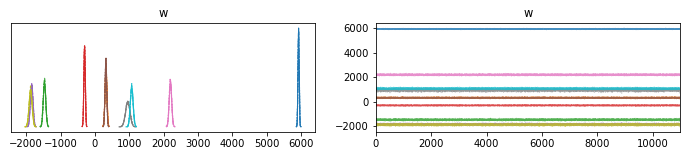

In [163]:
df = az.summary(trace)
df.to_csv('result2.csv')
axes = az.plot_trace(trace)
fig = axes.ravel()[0].figure
fig.savefig("result2.png")

In [35]:
w_cov = np.array([[298.83585649,   107.38288159,  -174.88577985,    43.14794963,
   -165.55770823,    87.47327194,    22.6553405,     61.59606038,
   -175.85325216,   -10.56036077],
 [  107.38288159,   757.33378515,  -853.39027475,   532.0634397,
   -628.78657625,   633.68802805,  -934.41866278,   117.98823377,
   -570.98117109,  -669.82853213],
 [ -174.88577985,  -853.39027475,  1268.56127781,  -521.25830701,
    208.05339066,  -832.24572436,   985.37374758,   968.93726529,
   1322.13155773,   193.95210035],
 [   43.14794963,   532.0634397,   -521.25830701,   395.20915379,
   -558.68769558,   416.64246681,  -683.57726117,   348.49486372,
   -229.36198148,  -613.11077678],
 [ -165.55770823,  -628.78657625,   208.05339066,  -558.68769558,
   1438.17742366,  -319.56618581,   800.62661495, -2040.07150888,
   -648.4668714,   1480.54862785],
 [   87.47327194,   633.68802805,  -832.24572436,   416.64246681,
   -319.56618581,   577.81419299, -767.98875348,  -345.71283974,
   -741.22030789,  -343.35217182],
 [   22.6553405,   -934.41866278,   985.37374758,  -683.57726117,
    800.62661495,  -767.98875348,  1243.13689738,  -264.39584255,
    567.4145513,    943.12997701],
 [   61.59606038,   117.98823377,   968.93726529,   348.49486372,
  -2040.07150888,  -345.71283974,  -264.39584255,  4186.61049585,
   2371.18838841, -2132.6910031 ],
 [ -175.85325216,  -570.98117109,  1322.13155773,  -229.36198148,
   -648.4668714,   -741.22030789,   567.4145513,   2371.18838841,
   1935.02497933,  -737.75133528],
 [  -10.56036077,  -669.82853213,   193.95210035,  -613.11077678,
   1480.54862785,  -343.35217182,   943.12997701, -2132.6910031,
   -737.75133528,  1619.75840474]])
w_mean = np.array([5922.777,319.312,-1469.315,-303.931,-1842.678,316.420,2194.443,953.884,-1872.522,1067.334])

In [113]:
62210.2-65869.00442643142

-3658.804426431423

In [114]:
3658.804426431423/20069.238450661025

0.18230908140467642

In [37]:
with pm.Model() as our_first_model:
    w = pm.MvNormal('w', mu=w_mean, cov=w_cov, shape=(num_of_vars, ))
    mu = pm.math.dot(X, w)
    likelihood = pm.Normal('likelihood', mu=mu, sigma=1/β, observed=y)
    trace = pm.sample(11000, random_seed=123)

<ipython-input-37-0682c2401cf9>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(11000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 384 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],5923.249,17.003,5892.438,5955.858,0.140,0.099,14761.0,14650.0,1.0
w[1],320.520,27.313,269.030,371.311,0.315,0.223,7507.0,9426.0,1.0
w[2],-1471.987,35.186,-1540.296,-1407.853,0.400,0.283,7741.0,9804.0,1.0
w[3],-303.400,19.771,-340.097,-265.961,0.226,0.160,7633.0,9756.0,1.0
w[4],-1841.656,37.889,-1912.131,-1770.395,0.408,0.289,8635.0,10820.0,1.0
w[5],317.930,23.792,273.314,362.474,0.274,0.194,7548.0,9705.0,1.0
w[6],2193.262,34.987,2127.410,2257.968,0.397,0.281,7761.0,9647.0,1.0
w[7],949.542,64.376,824.981,1065.995,0.677,0.479,9059.0,11617.0,1.0
w[8],-1876.279,43.459,-1956.040,-1792.297,0.470,0.332,8548.0,10370.0,1.0
w[9],1068.585,40.140,992.592,1143.341,0.434,0.307,8562.0,10663.0,1.0


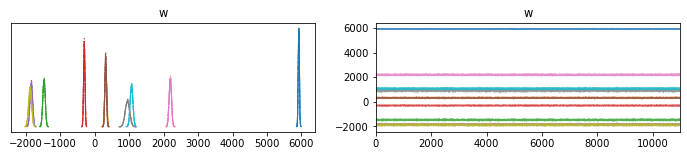

In [76]:
az.plot_trace(trace)
az.summary(trace)

In [57]:
errors = []
for i in range(325):
    y_hat = np.dot(X[i],w_mean)
    print(y_hat, y[i])
    errors.append(y[i] - y_hat)

14420.525814520894 19218.8
11560.185908749243 19433.3
10767.355202511451 18658.1
10109.522146413272 19146.5
5805.408522370659 19379.9
2078.043470775408 19170.7
2169.897961502956 18326.6
5615.948124172923 18546.0
4059.7282192968646 18247.2
3653.5402595280757 18023.6
2126.563181951829 18808.9
3402.0444798919652 19176.8
1783.3715847401156 19273.8
2514.049855599462 19434.9
4176.292337794234 21352.2
15646.247780348778 22825.4
22104.764045558444 23127.9
21270.706846286783 23844.0
17430.34227000504 23474.9
13315.49556860096 22728.5
17429.887112050914 23823.2
19220.270287942865 23257.9
17597.35244515186 23736.5
13629.331462445392 24689.6
16182.723718254003 26454.4
20632.178955815416 26261.3
23346.550963571794 27057.8
23335.859152829893 27376.0
20746.76487437824 28868.7
25158.559817083733 28949.4
22329.37387253918 29359.9
16944.432687942128 32193.3
33472.635781196666 32958.9
34968.847057282 32022.6
38181.63067914347 33991.5
40016.70889405446 36793.2
46851.0441205206 39460.2
53940.147267767825 4

In [65]:
np.std(errors)

10036.296738948993

In [93]:
with pm.Model() as prediction_model:
    w = pm.MvNormal('w', mu=w_mean, cov=w_cov, shape=(num_of_vars, ))
    mu = pm.math.dot(X[-1,:], w)
    error_std = 10036.296738948993
    y = pm.Normal('y', mu=mu, sigma=error_std)
    x_norm = pm.math.dot(X[-1,:], X[-1,:].T)
    y_sigma = error_std + pm.math.dot(w_cov, x_norm)
    #likilihood = pm.Normal('likelihood', mu=y, sigma=y_sigma, observed=X[-1,:])
    trace = pm.sample(1000, random_seed=123, start={'w': w_mean,'y': 0})

<ipython-input-93-6e8112245b3d>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, random_seed=123, start={'w': w_mean,'y': 0})
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 185 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\daisu\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

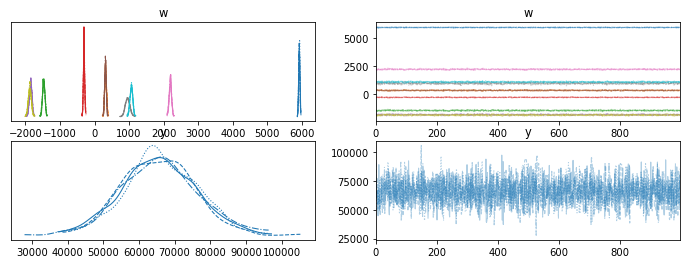

In [94]:
az.plot_trace(trace)

In [102]:
mu = np.dot(X[-1,:], w_mean)
error_std = 10036.296738948993
x_norm = np.dot(X[-1,:], X[-1,:].T)
y_sigma = error_std + np.dot(w_cov, x_norm)

In [115]:
mu

65869.00442643142

In [112]:
40138.47690132205/2

20069.238450661025

<AxesSubplot:xlabel='likelihood / likelihood'>

C:\Users\daisu\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


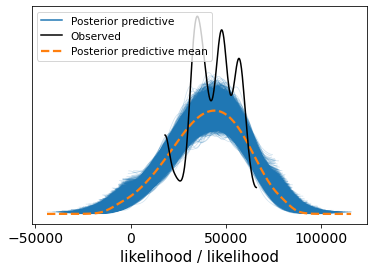

In [73]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=our_first_model))

In [82]:
X[-1,:].shape

(10,)

In [ ]:
y_hat = (ppc["w"] * X[:, None]).T

_, ax = plt.subplots()

ax.plot(X, y, "o", ms=4, alpha=0.4, label="Data")
ax.plot(X, y.mean(0), label="Mean outcome", alpha=0.6)
az.plot_hpd(
    X,
    y_hat,
    ax=ax,
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
az.plot_hpd(
    predictor_scaled,
    ppc["obs"],
    ax=ax,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Outcome 94% HPD"},
)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)")
ax.set_title("Posterior predictive checks")
ax.legend(ncol=2, fontsize=10);